# TESS Atlas fit for TOI 494

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 494.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-494.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-494.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-494.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 494

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 494 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

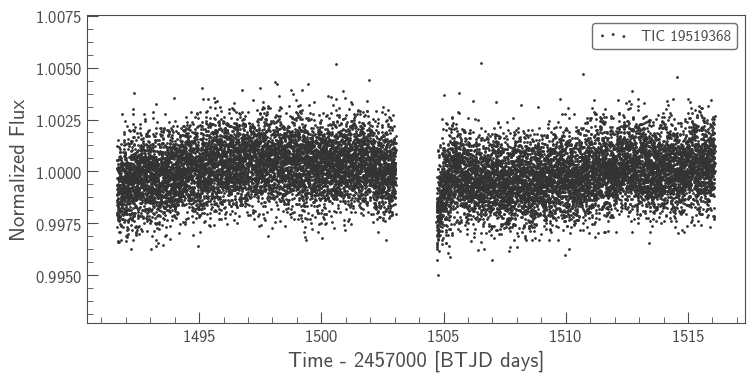

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -39664.70703186997 -> -39573.541381887095


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -25929.571638081503 -> -24709.69469747121


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24709.69469747121 -> -24701.39006720756


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -24701.39006720756 -> -24701.385523838308


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24701.385523838308 -> -24701.331861194943


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24701.331861194943 -> -24701.330838382466


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24701.330838382466 -> -24700.427389095163


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24700.427389095163 -> -24700.427389095163


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24700.427389095163 -> -24700.427389095097


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -24700.427389095097 -> -24700.42738909506


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24700.42738909506 -> -24700.427389094926


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24700.427389094926 -> -24700.427389094926


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24700.427389094926 -> -24700.427389094926


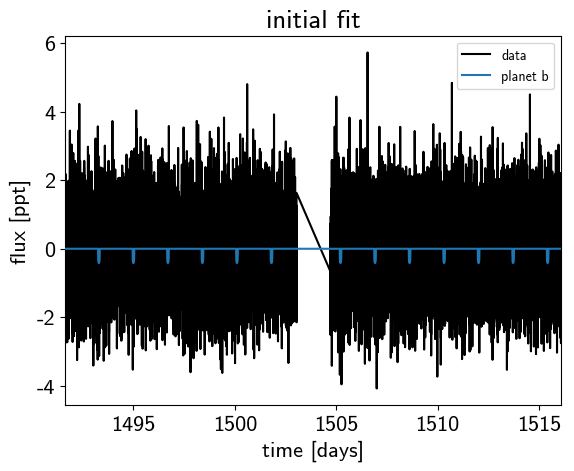

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 15.81draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:12,  7.70draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:16,  5.63draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.88draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:19,  4.35draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:17,  4.82draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:21,  3.91draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:20,  4.05draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:21,  3.85draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:21,  3.77draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:21,  3.82draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:21,  3.77draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.81draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:21,  3.63draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:20,  3.81draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:21,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:19,  3.79draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:21,  3.48draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:19,  3.78draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:20,  3.57draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:18,  3.87draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:19,  3.67draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:17,  3.93draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:18,  3.63draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:16,  4.00draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:19,  3.43draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:15,  4.10draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:18,  3.43draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:15,  4.14draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:18,  3.40draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:15,  4.03draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:17,  3.46draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:13,  4.25draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.33draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:16,  3.46draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:15,  3.54draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:14,  3.55draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:13,  3.59draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:13,  3.65draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:11,  4.16draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:13,  3.52draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:13,  3.27draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:11,  3.72draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:14<00:13,  3.24draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:11,  3.68draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:13,  3.06draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:12,  3.13draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:11,  3.31draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:13,  2.83draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:10,  3.60draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:12,  2.77draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:11,  2.95draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:10,  3.10draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:09,  3.28draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:07,  4.02draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:08,  3.36draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:06,  3.98draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:08,  3.24draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:20<00:06,  3.99draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:07,  3.21draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:05,  4.02draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:07,  3.12draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:06,  3.24draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.34draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:04,  3.80draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.33draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:22<00:03,  3.92draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:04,  3.40draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:03,  4.10draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.33draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.44draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.53draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:25<00:01,  3.78draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:01,  3.69draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:26<00:00,  3.73draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:28<00:00,  1.34draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:28<00:00,  1.72draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:02, 33.38draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:09,  9.86draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:17,  5.35draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:16,  5.62draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:20,  4.28draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:19,  4.44draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.81draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:21,  3.99draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:23,  3.67draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:25,  3.34draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:20,  4.11draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:24,  3.33draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:23,  3.39draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:19,  4.13draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:24,  3.19draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:22,  3.36draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  4.15draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:21,  3.45draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  4.04draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:20,  3.52draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:17,  4.07draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:19,  3.59draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:17,  4.04draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:18,  3.66draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:16,  4.02draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:19,  3.47draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:16,  4.06draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:15,  4.01draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:19,  3.29draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:15,  4.03draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:17,  3.40draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:14,  4.17draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:16,  3.51draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:15,  3.62draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:14,  3.70draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:10,  4.82draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:14,  3.71draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:11,  4.54draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:12,  3.81draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:10,  4.54draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:12,  3.67draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:10,  4.19draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:12,  3.70draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:10,  4.12draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:11,  3.76draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:13<00:09,  4.58draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:10,  3.73draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:08,  4.52draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:14<00:11,  3.47draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:10,  3.65draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:08,  4.37draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:09,  3.70draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:07,  4.45draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:09,  3.57draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:08,  3.59draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:07,  3.71draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:07,  3.77draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:17<00:05,  4.59draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:06,  3.71draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:05,  4.22draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:18<00:05,  4.32draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:18<00:05,  4.10draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:04,  4.10draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:19<00:04,  3.88draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:19<00:04,  3.95draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  3.77draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.75draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:20<00:03,  3.89draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:20<00:03,  4.25draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:02,  4.15draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:21<00:02,  4.05draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:01,  4.04draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:22<00:01,  4.65draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:22<00:01,  4.25draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:22<00:00,  4.39draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:23<00:00,  4.02draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  3.11draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.68draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:25<00:00,  1.57draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:44,  1.94draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:16,  2.63draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:17,  2.57draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:00,  3.31draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:05,  3.01draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:51,  3.79draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:00,  3.23draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:51,  3.77draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:45,  4.23draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:50,  3.83draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:45,  4.23draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:49,  3.86draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:39,  4.79draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:49,  3.77draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:47,  3.86draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:39,  4.62draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:04<00:48,  3.73draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:40,  4.55draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<00:48,  3.70draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<00:39,  4.51draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:05<00:48,  3.66draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:47,  3.75draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:38,  4.57draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:48,  3.65draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:07<00:40,  4.30draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:46,  3.70draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:07<00:39,  4.38draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:07<00:45,  3.74draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:08<00:43,  3.92draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:44,  3.83draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:08<00:41,  4.04draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:08<00:43,  3.87draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:40,  4.10draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:09<00:42,  3.87draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:09<00:39,  4.16draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:42,  3.82draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:10<00:38,  4.19draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:10<00:41,  3.86draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:10<00:37,  4.23draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:10<00:42,  3.74draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:11<00:36,  4.29draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:41,  3.76draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:11<00:35,  4.35draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:11<00:41,  3.74draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:12<00:37,  4.14draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:12<00:41,  3.73draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:12<00:40,  3.76draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:12<00:39,  3.81draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:13<00:55,  2.71draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:14<00:52,  2.80draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:14<00:48,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:14<00:37,  3.82draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:15<00:45,  3.14draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:15<00:42,  3.39draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:15<00:41,  3.41draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:16<00:37,  3.72draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:16<00:37,  3.71draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:16<00:35,  3.89draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:16<00:39,  3.46draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:17<00:33,  4.11draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:17<00:37,  3.63draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:17<00:33,  4.07draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:17<00:35,  3.79draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:18<00:31,  4.17draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:18<00:34,  3.84draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:18<00:32,  4.07draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:18<00:28,  4.60draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:18<00:27,  4.70draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:19<00:30,  4.26draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:19<00:28,  4.40draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:19<00:30,  4.13draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:19<00:29,  4.23draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:20<00:26,  4.72draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:20<00:32,  3.79draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:20<00:26,  4.65draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:21<00:32,  3.76draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:21<00:31,  3.81draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:21<00:25,  4.54draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:22<00:28,  4.13draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:22<00:27,  4.25draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:22<00:31,  3.66draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:22<00:27,  4.13draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:23<00:34,  3.28draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:23<00:32,  3.40draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:24<00:30,  3.57draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:24<00:28,  3.72draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:25<00:27,  3.79draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:25<00:26,  3.80draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:26<00:26,  3.84draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:26<00:22,  4.38draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:26<00:26,  3.75draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:26<00:22,  4.32draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:27<00:25,  3.71draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:27<00:21,  4.32draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:27<00:26,  3.57draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:27<00:21,  4.39draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:28<00:25,  3.60draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:28<00:21,  4.33draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:28<00:24,  3.64draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:29<00:20,  4.33draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:29<00:24,  3.64draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:29<00:19,  4.47draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:29<00:23,  3.69draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:30<00:21,  3.99draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:30<00:20,  4.10draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:30<00:21,  3.83draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:31<00:21,  3.74draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:31<00:22,  3.60draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:31<00:25,  3.13draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:32<00:23,  3.27draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:32<00:22,  3.33draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:33<00:21,  3.33draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:34<00:20,  3.42draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:34<00:19,  3.48draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:34<00:15,  4.32draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:35<00:19,  3.46draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:35<00:16,  3.98draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:35<00:19,  3.42draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:35<00:15,  4.07draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:35<00:13,  4.79draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:36<00:17,  3.62draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:36<00:16,  3.53draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:37<00:16,  3.58draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:37<00:17,  3.34draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:38<00:14,  3.82draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:38<00:16,  3.27draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:38<00:13,  4.01draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:39<00:17,  3.05draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:39<00:13,  3.73draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:39<00:17,  2.90draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:40<00:15,  3.07draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:40<00:14,  3.19draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:41<00:13,  3.35draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:41<00:12,  3.50draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:42<00:11,  3.43draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:43<00:11,  3.44draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:43<00:10,  3.55draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:43<00:07,  4.48draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:44<00:09,  3.73draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:44<00:08,  3.97draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:44<00:09,  3.25draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:45<00:08,  3.35draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:45<00:08,  3.45draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:46<00:07,  3.56draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:46<00:06,  3.97draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:46<00:06,  3.68draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:47<00:05,  4.01draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:47<00:04,  4.67draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:47<00:05,  3.62draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:47<00:04,  4.42draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:48<00:05,  3.60draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:48<00:03,  4.26draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:48<00:03,  4.08draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:49<00:03,  3.95draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:49<00:03,  4.10draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:50<00:04,  2.72draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:50<00:04,  2.40draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:51<00:04,  2.27draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:51<00:03,  2.28draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:52<00:02,  2.50draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:52<00:02,  2.27draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:53<00:02,  2.20draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:53<00:01,  2.15draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:54<00:01,  2.12draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:54<00:00,  2.09draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:55<00:00,  2.08draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:57<00:00,  1.04s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:09, 39.96draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:23, 17.26draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:47,  8.37draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:01<01:20,  4.92draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<01:10,  5.58draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:01<01:20,  4.88draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<01:23,  4.71draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:02<01:32,  4.20draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:02<01:30,  4.29draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:02<01:32,  4.18draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:02<01:19,  4.85draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:03<01:29,  4.31draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:03<01:18,  4.86draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:03<01:12,  5.25draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:04<01:05,  5.77draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:04<00:58,  6.40draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:04<00:56,  6.65draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:04<00:54,  6.83draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:05<00:48,  7.69draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:05<01:01,  5.98draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:05<01:04,  5.68draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:06<00:58,  6.22draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:06<00:56,  6.51draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:06<00:52,  6.95draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:06<00:49,  7.30draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:06<00:57,  6.31draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:07<01:11,  5.04draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:07<01:03,  5.66draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:07<00:50,  7.02draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:07<01:01,  5.83draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:07<00:56,  6.32draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:07<00:45,  7.72draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:08<00:56,  6.22draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:08<01:15,  4.64draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:08<01:14,  4.69draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:09<01:25,  4.09draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:09<01:24,  4.13draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:09<01:25,  4.03draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:09<01:06,  5.17draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:10<01:08,  5.04draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:10<01:05,  5.25draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:10<00:56,  6.04draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:10<01:10,  4.83draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:11<01:03,  5.31draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:11<01:09,  4.84draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:11<00:59,  5.62draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:11<00:53,  6.28draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:11<00:52,  6.28draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:11<00:50,  6.59draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:12<00:41,  7.91draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:12<00:35,  9.30draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:12<00:34,  9.43draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:12<00:32,  9.80draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:13<00:48,  6.58draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:13<00:56,  5.61draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:14<01:07,  4.72draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:14<00:58,  5.36draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:14<01:12,  4.33draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:15<01:16,  4.07draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:15<01:10,  4.42draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:15<01:01,  5.01draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:16<01:26,  3.56draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:16<01:16,  4.02draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:16<01:18,  3.89draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:17<01:07,  4.53draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:17<00:57,  5.25draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:17<01:01,  4.91draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:17<00:59,  5.09draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:17<00:48,  6.15draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:17<00:42,  6.95draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:17<00:34,  8.56draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:18<00:36,  8.11draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:18<00:41,  7.11draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:18<00:34,  8.51draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:19<00:49,  5.77draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:19<00:44,  6.40draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:19<00:43,  6.53draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:20<00:44,  6.40draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:20<00:41,  6.78draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:20<00:46,  6.05draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:20<00:41,  6.80draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:21<01:04,  4.28draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:21<00:52,  5.24draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:21<00:49,  5.52draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:21<00:57,  4.79draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:21<00:50,  5.44draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:22<00:41,  6.51draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:22<00:35,  7.51draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:22<00:49,  5.39draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:23<00:39,  6.74draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:23<00:45,  5.74draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:23<00:41,  6.33draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:23<00:49,  5.27draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:24<00:44,  5.79draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:24<00:42,  6.03draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:24<00:38,  6.69draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:24<00:34,  7.41draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:24<00:33,  7.49draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:24<00:34,  7.26draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:24<00:30,  8.18draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:25<00:26,  9.57draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:25<00:23, 10.49draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:25<00:23, 10.33draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:25<00:23, 10.41draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:25<00:21, 10.96draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:25<00:19, 12.48draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:26<00:18, 12.49draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:26<00:23, 10.00draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:26<00:25,  9.22draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:26<00:23,  9.75draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:26<00:20, 11.17draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:27<00:23,  9.54draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:27<00:37,  6.01draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:27<00:33,  6.72draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:28<00:49,  4.48draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:28<00:51,  4.29draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:28<00:59,  3.71draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:29<01:05,  3.34draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:29<00:54,  3.97draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:29<01:02,  3.46draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:30<00:56,  3.81draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:30<00:57,  3.77draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:30<00:47,  4.49draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:30<00:52,  4.04draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:31<00:52,  4.05draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:31<00:56,  3.71draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:31<00:59,  3.52draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:32<00:57,  3.60draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:32<00:45,  4.53draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:32<00:40,  5.11draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:32<00:36,  5.56draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:32<00:35,  5.70draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:32<00:33,  6.03draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:33<00:41,  4.79draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:33<00:38,  5.17draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:33<00:43,  4.58draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:34<00:46,  4.17draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:34<00:39,  4.95draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:34<00:36,  5.36draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:34<00:39,  4.85draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:35<00:36,  5.21draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:35<00:42,  4.52draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:35<00:44,  4.25draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:35<00:46,  4.05draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:36<00:46,  4.04draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:36<00:43,  4.33draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:36<00:39,  4.69draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:36<00:32,  5.70draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:37<00:45,  4.00draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:37<00:37,  4.80draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:37<00:35,  5.12draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:37<00:44,  4.04draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:37<00:34,  5.12draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:38<00:33,  5.32draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:38<00:26,  6.53draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:38<00:42,  4.09draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:38<00:35,  4.93draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:39<00:47,  3.66draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:39<00:39,  4.31draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:39<00:54,  3.10draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:40<00:52,  3.21draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:40<00:49,  3.39draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:41<00:40,  4.08draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:41<00:34,  4.74draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:41<00:37,  4.40draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:41<00:38,  4.20draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:41<00:29,  5.37draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:42<00:47,  3.31draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:42<00:41,  3.85draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:42<00:46,  3.41draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:43<00:46,  3.37draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:43<00:43,  3.58draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:43<00:44,  3.43draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:44<00:41,  3.65draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:44<00:42,  3.56draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:44<00:41,  3.66draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:44<00:42,  3.53draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:45<00:35,  4.18draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:45<00:45,  3.20draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:46<00:44,  3.26draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:46<00:36,  3.91draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:46<00:31,  4.61draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:46<00:38,  3.65draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:47<00:33,  4.16draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:47<00:37,  3.72draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:47<00:33,  4.14draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:47<00:38,  3.60draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:48<00:33,  4.05draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:48<00:34,  3.97draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:48<00:34,  3.91draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:49<00:34,  3.84draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:50<00:33,  3.85draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:50<00:33,  3.88draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:51<00:32,  3.88draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:51<00:32,  3.84draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:52<00:31,  3.92draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:52<00:25,  4.72draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:52<00:23,  5.17draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:52<00:30,  3.94draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:52<00:24,  4.79draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:53<00:26,  4.39draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:53<00:23,  4.86draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:53<00:29,  3.90draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:53<00:26,  4.38draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:54<00:30,  3.65draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:54<00:25,  4.35draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:54<00:30,  3.61draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:54<00:25,  4.33draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:55<00:31,  3.51draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:55<00:26,  4.07draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:55<00:31,  3.43draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:55<00:25,  4.12draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:56<00:21,  4.87draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:56<00:27,  3.72draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:56<00:24,  4.20draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:56<00:23,  4.33draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:57<00:18,  5.40draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:57<00:23,  4.19draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:57<00:20,  4.74draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:58<00:25,  3.77draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:58<00:22,  4.23draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:58<00:25,  3.70draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:58<00:23,  4.00draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:59<00:25,  3.63draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:59<00:23,  3.92draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:59<00:25,  3.57draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:59<00:22,  4.02draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [01:00<00:23,  3.68draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [01:00<00:21,  4.05draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [01:00<00:23,  3.64draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [01:00<00:20,  4.18draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [01:01<00:25,  3.27draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [01:01<00:24,  3.41draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [01:02<00:23,  3.45draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:02<00:22,  3.53draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [01:03<00:17,  4.39draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:03<00:21,  3.41draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [01:04<00:20,  3.56draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [01:04<00:17,  4.05draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:04<00:15,  4.46draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [01:04<00:13,  4.98draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:04<00:14,  4.85draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [01:05<00:16,  4.12draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:05<00:15,  4.35draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [01:05<00:16,  3.85draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [01:05<00:14,  4.48draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:06<00:12,  4.99draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [01:06<00:09,  6.19draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [01:06<00:12,  4.83draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:06<00:12,  4.59draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [01:07<00:13,  4.21draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [01:07<00:09,  5.41draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:07<00:08,  6.50draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [01:08<00:07,  6.44draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [01:08<00:07,  6.85draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [01:08<00:06,  7.08draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [01:08<00:05,  8.46draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [01:08<00:06,  6.43draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [01:09<00:05,  7.94draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [01:09<00:06,  5.87draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [01:09<00:07,  5.03draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [01:10<00:06,  5.51draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [01:10<00:07,  4.90draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [01:10<00:06,  5.51draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [01:10<00:08,  4.05draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [01:10<00:07,  4.79draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:11<00:09,  3.55draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [01:11<00:07,  4.10draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:11<00:06,  4.96draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [01:11<00:06,  4.69draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:12<00:07,  3.73draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [01:12<00:06,  4.38draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:12<00:07,  3.50draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:13<00:06,  3.66draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [01:13<00:05,  4.48draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:13<00:05,  3.99draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:14<00:04,  4.50draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:14<00:03,  5.21draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:14<00:03,  4.58draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:14<00:03,  4.74draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:15<00:03,  4.14draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:15<00:04,  3.33draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [01:16<00:04,  3.14draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:16<00:04,  2.53draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:17<00:04,  2.30draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:18<00:04,  2.20draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:18<00:04,  2.15draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:18<00:03,  2.10draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:19<00:03,  2.06draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:20<00:02,  2.05draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:20<00:02,  2.04draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:21<00:02,  1.99draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:21<00:01,  2.31draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:21<00:00,  2.19draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:23<00:00,  1.05draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:24<00:00,  1.22draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:23, 34.23draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:26, 30.16draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:34, 23.24draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:37, 20.88draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:42, 18.60draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:51, 15.16draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<00:42, 18.57draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:01<00:39, 19.90draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:48, 15.83draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:02<01:34,  8.18draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:02<02:01,  6.37draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:02<01:57,  6.56draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:03<02:27,  5.20draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:03<02:15,  5.66draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:03<02:26,  5.22draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:03<02:11,  5.82draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:04<02:31,  5.04draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:04<02:01,  6.26draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:04<01:55,  6.55draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:04<01:52,  6.76draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:04<01:33,  8.06draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:04<01:17,  9.73draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:04<01:02, 12.08draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:05<00:52, 14.26draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:05<00:48, 15.45draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:05<00:42, 17.26draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:05<00:43, 16.86draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:05<00:47, 15.42draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:05<00:42, 17.30draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:06<00:44, 16.43draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:06<00:44, 16.25draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:06<00:45, 15.80draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:06<00:42, 17.09draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:06<00:56, 12.84draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:06<00:52, 13.63draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:06<00:51, 13.79draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:07<00:43, 16.23draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:07<00:50, 14.09draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:07<00:43, 16.09draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:07<00:43, 16.25draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:07<00:43, 16.25draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:07<00:38, 18.07draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:07<00:44, 15.67draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:08<00:43, 15.82draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:08<00:43, 15.98draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:08<00:41, 16.54draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:08<00:39, 17.53draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:08<00:40, 17.09draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:08<00:36, 18.74draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:08<00:37, 17.93draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:09<00:37, 18.21draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:09<00:45, 14.77draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:09<00:44, 15.10draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:09<00:50, 13.36draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:09<00:47, 14.15draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:09<00:43, 15.43draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:09<00:38, 17.22draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:10<00:42, 15.73draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:10<00:54, 12.21draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:10<00:50, 13.14draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:10<00:53, 12.26draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:10<01:01, 10.57draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:11<01:28,  7.35draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:11<01:29,  7.28draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:11<01:49,  5.94draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:12<01:28,  7.30draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:12<01:16,  8.42draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:12<01:16,  8.42draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:12<01:18,  8.13draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:12<01:39,  6.43draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:13<01:34,  6.76draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:13<01:32,  6.85draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:13<01:42,  6.21draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:13<02:07,  5.00draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:14<02:07,  4.98draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:14<02:26,  4.33draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:14<02:33,  4.13draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:14<02:29,  4.22draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:15<02:33,  4.11draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:15<02:09,  4.84draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:15<01:53,  5.53draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:15<01:58,  5.26draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:15<01:37,  6.40draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:15<01:30,  6.86draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:16<01:26,  7.19draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:16<01:07,  9.11draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:16<00:58, 10.49draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:16<00:51, 12.05draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:16<00:48, 12.58draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:16<00:41, 14.63draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:16<00:45, 13.26draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:17<00:48, 12.44draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:17<00:56, 10.75draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:17<01:11,  8.41draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:17<01:12,  8.25draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:18<01:05,  9.16draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:18<01:01,  9.60draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:18<00:50, 11.72draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:18<00:46, 12.78draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:18<00:43, 13.64draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:18<00:38, 15.08draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:19<00:33, 17.27draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:19<00:34, 17.00draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:19<00:34, 16.80draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:19<00:34, 16.76draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:19<00:31, 18.38draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:19<00:33, 16.83draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:19<00:34, 16.48draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:19<00:30, 18.26draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:20<00:30, 18.57draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:20<00:28, 19.97draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:20<00:27, 19.92draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:20<00:25, 22.11draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:20<00:30, 17.80draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:20<00:40, 13.54draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:20<00:35, 15.24draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:21<00:34, 15.55draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:21<00:32, 16.81draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:21<00:31, 17.32draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:21<00:39, 13.40draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:22<01:16,  7.02draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:22<01:32,  5.74draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:23<01:36,  5.53draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:23<01:54,  4.65draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:23<01:54,  4.63draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:23<02:09,  4.07draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:24<02:00,  4.37draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:24<02:12,  3.97draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:24<02:02,  4.30draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:25<02:03,  4.22draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:25<02:04,  4.17draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:25<01:54,  4.55draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:26<01:32,  5.61draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:26<02:09,  3.98draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:26<02:14,  3.83draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:27<01:41,  5.03draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:27<02:14,  3.81draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:27<01:49,  4.64draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:27<02:14,  3.79draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:28<01:54,  4.43draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:28<02:19,  3.62draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:28<01:58,  4.27draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:29<02:15,  3.72draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:29<01:57,  4.30draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:29<02:12,  3.80draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:29<01:56,  4.32draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:29<02:10,  3.83draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:30<01:55,  4.32draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:30<02:27,  3.38draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:31<02:23,  3.46draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:31<02:16,  3.64draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:32<02:11,  3.74draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:32<01:48,  4.51draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:32<02:00,  4.06draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:32<01:51,  4.37draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:33<02:00,  4.04draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:33<01:54,  4.27draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:33<02:03,  3.94draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:33<01:55,  4.20draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:34<02:03,  3.91draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:34<01:54,  4.22draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:34<02:04,  3.88draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:34<01:53,  4.23draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:35<02:02,  3.93draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:35<01:53,  4.21draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:35<02:04,  3.82draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:35<01:55,  4.12draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:36<02:06,  3.76draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:36<02:04,  3.80draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:37<02:03,  3.81draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:37<01:40,  4.68draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:37<02:08,  3.65draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:37<02:05,  3.72draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:38<02:09,  3.62draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:38<02:06,  3.68draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:38<02:06,  3.68draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:39<02:09,  3.58draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:39<02:02,  3.80draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:39<02:07,  3.62draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:39<01:54,  4.05draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:40<02:07,  3.63draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:40<01:48,  4.24draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:40<02:13,  3.45draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:41<02:08,  3.55draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:41<01:58,  3.86draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:41<02:22,  3.19draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:42<02:17,  3.29draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:43<02:14,  3.34draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:43<02:30,  3.00draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:43<02:10,  3.43draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:43<02:08,  3.49draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:44<02:09,  3.44draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:44<01:56,  3.82draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:44<02:15,  3.28draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:45<02:10,  3.39draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:45<02:35,  2.84draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:45<02:01,  3.62draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:46<02:15,  3.25draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:46<02:43,  2.69draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:47<02:25,  3.00draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:47<02:46,  2.62draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:47<02:15,  3.21draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:48<02:19,  3.10draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:48<02:40,  2.70draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:48<02:14,  3.21draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:49<02:16,  3.15draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:49<02:45,  2.60draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:49<02:12,  3.24draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:50<02:35,  2.75draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:50<02:54,  2.45draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:51<03:03,  2.32draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:51<03:08,  2.26draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:52<02:42,  2.60draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:52<02:54,  2.42draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:53<02:32,  2.76draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:53<02:47,  2.50draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:54<02:27,  2.83draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:54<02:43,  2.55draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:55<02:23,  2.88draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:55<02:40,  2.58draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:56<02:21,  2.90draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:56<02:39,  2.57draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:57<02:20,  2.90draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:57<02:37,  2.59draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:58<02:20,  2.88draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:58<02:36,  2.58draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:59<02:18,  2.90draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:59<02:08,  3.11draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [01:00<02:01,  3.28draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [01:00<02:24,  2.75draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [01:01<02:15,  2.92draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [01:01<02:07,  3.07draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [01:02<02:30,  2.60draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [01:02<01:59,  3.27draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [01:02<02:07,  3.06draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [01:03<01:43,  3.77draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [01:03<01:55,  3.37draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [01:03<01:44,  3.72draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [01:04<01:56,  3.31draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [01:04<01:38,  3.92draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [01:04<02:10,  2.94draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [01:05<01:59,  3.21draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [01:05<01:44,  3.63draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [01:06<02:08,  2.95draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [01:06<01:57,  3.21draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [01:07<01:52,  3.31draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [01:07<01:39,  3.75draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [01:07<01:58,  3.13draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [01:08<02:25,  2.56draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [01:09<02:38,  2.33draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [01:09<02:18,  2.67draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [01:09<02:41,  2.28draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [01:10<02:25,  2.51draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [01:12<04:28,  1.36draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [01:12<04:31,  1.34draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [01:14<05:55,  1.02draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [01:14<05:12,  1.16draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [01:16<06:32,  1.09s/draws]

Sampling 2 chains:  55%|█████▌    | 444/804 [01:17<05:48,  1.03draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [01:18<06:08,  1.03s/draws]

Sampling 2 chains:  55%|█████▌    | 446/804 [01:18<04:54,  1.21draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [01:20<06:46,  1.14s/draws]

Sampling 2 chains:  56%|█████▌    | 448/804 [01:20<05:05,  1.16draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [01:21<05:26,  1.09draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [01:22<05:27,  1.08draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [01:23<05:08,  1.14draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [01:23<04:14,  1.38draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [01:25<04:53,  1.19draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [01:26<05:10,  1.13draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [01:26<04:10,  1.39draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [01:26<03:56,  1.47draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [01:28<04:42,  1.23draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [01:28<03:41,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [01:29<04:14,  1.35draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [01:29<04:05,  1.40draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [01:30<04:03,  1.41draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [01:30<03:19,  1.71draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [01:31<02:53,  1.97draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [01:32<03:20,  1.70draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [01:32<03:26,  1.64draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [01:33<02:58,  1.90draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [01:33<02:31,  2.22draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [01:33<02:01,  2.75draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [01:33<01:39,  3.34draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [01:34<01:39,  3.36draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [01:34<01:33,  3.54draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [01:34<01:36,  3.44draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [01:35<02:43,  2.02draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [01:35<02:12,  2.48draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [01:36<02:28,  2.21draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [01:36<02:46,  1.96draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [01:37<02:57,  1.83draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [01:37<02:29,  2.18draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [01:39<03:35,  1.50draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [01:39<03:25,  1.57draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [01:40<03:12,  1.67draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [01:40<02:40,  2.00draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [01:41<02:44,  1.94draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [01:41<02:51,  1.85draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [01:42<03:01,  1.74draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [01:43<02:33,  2.05draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [01:43<02:35,  2.01draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [01:44<02:37,  1.99draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [01:44<02:14,  2.32draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [01:44<02:15,  2.30draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [01:45<01:50,  2.79draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [01:45<01:47,  2.86draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [01:46<02:07,  2.40draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [01:46<02:00,  2.54draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [01:46<02:09,  2.36draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [01:47<01:47,  2.83draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [01:47<01:29,  3.38draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [01:47<01:13,  4.12draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [01:47<01:41,  2.95draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [01:48<01:58,  2.53draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [01:49<02:18,  2.17draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [01:49<02:13,  2.24draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [01:49<01:50,  2.70draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [01:50<02:11,  2.25draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [01:50<01:56,  2.53draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [01:51<02:05,  2.34draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [01:51<02:10,  2.25draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [01:52<02:31,  1.93draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [01:52<02:48,  1.73draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [01:53<02:42,  1.79draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [01:54<02:27,  1.95draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [01:55<02:59,  1.60draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [01:55<02:29,  1.92draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [01:56<02:44,  1.73draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [01:57<03:53,  1.22draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [01:58<03:42,  1.27draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [01:59<04:45,  1.01s/draws]

Sampling 2 chains:  65%|██████▌   | 523/804 [02:00<04:32,  1.03draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [02:01<04:54,  1.05s/draws]

Sampling 2 chains:  65%|██████▌   | 525/804 [02:02<04:40,  1.01s/draws]

Sampling 2 chains:  65%|██████▌   | 526/804 [02:03<04:45,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 527/804 [02:04<03:38,  1.27draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [02:04<03:36,  1.28draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [02:06<04:13,  1.09draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [02:06<03:08,  1.45draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [02:07<03:44,  1.22draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [02:08<03:38,  1.24draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [02:08<02:53,  1.56draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [02:08<02:31,  1.78draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [02:09<03:08,  1.42draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [02:10<02:51,  1.56draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [02:10<02:21,  1.88draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [02:10<01:59,  2.23draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [02:11<02:06,  2.09draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [02:11<02:12,  2.00draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [02:12<02:15,  1.95draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [02:12<01:52,  2.32draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [02:13<01:42,  2.55draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [02:13<01:52,  2.31draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [02:14<01:59,  2.16draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [02:14<01:44,  2.48draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [02:14<01:22,  3.11draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [02:14<01:14,  3.42draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [02:15<01:03,  4.00draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [02:15<01:04,  3.92draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [02:15<01:04,  3.90draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [02:15<01:12,  3.49draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [02:16<01:16,  3.27draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [02:16<01:12,  3.42draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [02:16<01:00,  4.12draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [02:16<00:52,  4.71draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [02:16<00:46,  5.23draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [02:17<00:38,  6.42draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [02:17<00:36,  6.69draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [02:17<00:34,  6.99draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [02:17<00:33,  7.25draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [02:17<00:31,  7.67draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [02:17<00:31,  7.45draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [02:17<00:31,  7.53draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [02:18<00:31,  7.46draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [02:18<00:26,  8.71draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [02:18<00:24,  9.55draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [02:18<00:25,  8.97draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [02:18<00:20, 10.92draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [02:18<00:18, 11.94draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [02:19<00:17, 12.37draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [02:19<00:16, 13.03draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [02:19<00:17, 12.11draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [02:19<00:20, 10.72draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [02:19<00:19, 10.94draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [02:20<00:20, 10.58draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [02:20<00:22,  9.36draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [02:20<00:23,  8.93draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [02:20<00:24,  8.54draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [02:20<00:25,  8.01draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [02:20<00:27,  7.36draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [02:21<00:27,  7.33draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [02:21<00:24,  8.14draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [02:21<00:21,  9.35draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [02:21<00:19, 10.17draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [02:21<00:17, 11.27draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [02:22<00:18, 10.20draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [02:22<00:17, 11.21draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [02:22<00:16, 11.63draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [02:22<00:18, 10.26draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [02:22<00:17, 10.32draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [02:23<00:17, 10.27draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [02:23<00:16, 11.04draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [02:23<00:15, 11.73draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [02:23<00:13, 12.69draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [02:23<00:13, 13.27draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [02:23<00:11, 15.34draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [02:23<00:11, 15.21draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [02:24<00:12, 13.64draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [02:27<01:37,  1.71draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [02:31<02:46,  1.02s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [02:33<03:35,  1.32s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [02:34<03:18,  1.23s/draws]

Sampling 2 chains:  80%|███████▉  | 643/804 [02:35<03:06,  1.16s/draws]

Sampling 2 chains:  80%|████████  | 644/804 [02:36<03:01,  1.14s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [02:38<03:17,  1.24s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [02:40<03:50,  1.46s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [02:42<04:17,  1.64s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [02:45<05:11,  2.00s/draws]

Sampling 2 chains:  81%|████████  | 649/804 [02:47<05:14,  2.03s/draws]

Sampling 2 chains:  81%|████████  | 650/804 [02:49<05:09,  2.01s/draws]

Sampling 2 chains:  81%|████████  | 651/804 [02:51<05:24,  2.12s/draws]

Sampling 2 chains:  81%|████████  | 652/804 [02:53<05:23,  2.13s/draws]

Sampling 2 chains:  81%|████████  | 653/804 [02:55<05:24,  2.15s/draws]

Sampling 2 chains:  81%|████████▏ | 654/804 [02:57<05:19,  2.13s/draws]

Sampling 2 chains:  81%|████████▏ | 655/804 [03:00<05:13,  2.10s/draws]

Sampling 2 chains:  82%|████████▏ | 656/804 [03:02<05:08,  2.09s/draws]

Sampling 2 chains:  82%|████████▏ | 657/804 [03:04<05:03,  2.06s/draws]

Sampling 2 chains:  82%|████████▏ | 658/804 [03:06<04:59,  2.05s/draws]

Sampling 2 chains:  82%|████████▏ | 659/804 [03:08<04:55,  2.03s/draws]

Sampling 2 chains:  82%|████████▏ | 660/804 [03:10<04:51,  2.03s/draws]

Sampling 2 chains:  82%|████████▏ | 661/804 [03:12<04:55,  2.07s/draws]

Sampling 2 chains:  82%|████████▏ | 662/804 [03:14<04:58,  2.10s/draws]

Sampling 2 chains:  82%|████████▏ | 663/804 [03:16<05:00,  2.13s/draws]

Sampling 2 chains:  83%|████████▎ | 664/804 [03:18<05:01,  2.15s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [03:21<05:11,  2.24s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [03:23<05:00,  2.18s/draws]

Sampling 2 chains:  83%|████████▎ | 667/804 [03:25<04:51,  2.13s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [03:27<04:43,  2.09s/draws]

Sampling 2 chains:  83%|████████▎ | 669/804 [03:29<04:54,  2.18s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [03:31<04:49,  2.16s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [03:33<04:41,  2.12s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [03:35<04:39,  2.12s/draws]

Sampling 2 chains:  84%|████████▎ | 673/804 [03:37<04:17,  1.97s/draws]

Sampling 2 chains:  84%|████████▍ | 674/804 [03:39<04:23,  2.03s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [03:41<04:25,  2.05s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [03:43<04:19,  2.03s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [03:45<04:15,  2.01s/draws]

Sampling 2 chains:  84%|████████▍ | 678/804 [03:47<04:15,  2.03s/draws]

Sampling 2 chains:  84%|████████▍ | 679/804 [03:49<04:10,  2.01s/draws]

Sampling 2 chains:  85%|████████▍ | 680/804 [03:51<04:07,  2.00s/draws]

Sampling 2 chains:  85%|████████▍ | 681/804 [03:53<04:07,  2.01s/draws]

Sampling 2 chains:  85%|████████▍ | 682/804 [03:55<04:05,  2.02s/draws]

Sampling 2 chains:  85%|████████▍ | 683/804 [03:57<04:06,  2.04s/draws]

Sampling 2 chains:  85%|████████▌ | 684/804 [04:00<04:06,  2.05s/draws]

Sampling 2 chains:  85%|████████▌ | 685/804 [04:02<04:06,  2.08s/draws]

Sampling 2 chains:  85%|████████▌ | 686/804 [04:03<03:34,  1.82s/draws]

Sampling 2 chains:  85%|████████▌ | 687/804 [04:05<03:45,  1.93s/draws]

Sampling 2 chains:  86%|████████▌ | 688/804 [04:07<03:46,  1.95s/draws]

Sampling 2 chains:  86%|████████▌ | 689/804 [04:09<03:46,  1.97s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [04:11<03:46,  1.99s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [04:13<03:47,  2.01s/draws]

Sampling 2 chains:  86%|████████▌ | 692/804 [04:15<03:46,  2.02s/draws]

Sampling 2 chains:  86%|████████▌ | 693/804 [04:17<03:51,  2.09s/draws]

Sampling 2 chains:  86%|████████▋ | 694/804 [04:20<03:49,  2.09s/draws]

Sampling 2 chains:  86%|████████▋ | 695/804 [04:22<03:49,  2.11s/draws]

Sampling 2 chains:  87%|████████▋ | 696/804 [04:24<03:47,  2.10s/draws]

Sampling 2 chains:  87%|████████▋ | 697/804 [04:26<03:42,  2.08s/draws]

Sampling 2 chains:  87%|████████▋ | 698/804 [04:28<03:41,  2.09s/draws]

Sampling 2 chains:  87%|████████▋ | 699/804 [04:30<03:26,  1.97s/draws]

Sampling 2 chains:  87%|████████▋ | 700/804 [04:32<03:32,  2.05s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [04:34<03:30,  2.04s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [04:36<03:26,  2.03s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [04:38<03:24,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [04:40<03:22,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [04:42<03:20,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [04:44<03:17,  2.01s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [04:46<03:15,  2.01s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [04:48<03:13,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 709/804 [04:50<03:14,  2.05s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [04:52<03:14,  2.07s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [04:54<03:14,  2.09s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [04:56<03:12,  2.10s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [04:59<03:16,  2.15s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [05:00<02:44,  1.83s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [05:01<02:23,  1.61s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [05:02<02:08,  1.46s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [05:04<02:29,  1.72s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [05:05<02:12,  1.54s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [05:07<02:01,  1.43s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [05:08<01:53,  1.35s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [05:09<01:38,  1.19s/draws]

Sampling 2 chains:  90%|████████▉ | 722/804 [05:10<01:35,  1.17s/draws]

Sampling 2 chains:  90%|████████▉ | 723/804 [05:11<01:36,  1.19s/draws]

Sampling 2 chains:  90%|█████████ | 724/804 [05:12<01:35,  1.20s/draws]

Sampling 2 chains:  90%|█████████ | 725/804 [05:14<01:56,  1.48s/draws]

Sampling 2 chains:  90%|█████████ | 726/804 [05:15<01:44,  1.34s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [05:16<01:36,  1.25s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [05:17<01:30,  1.18s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [05:19<01:47,  1.44s/draws]

Sampling 2 chains:  91%|█████████ | 730/804 [05:21<01:37,  1.32s/draws]

Sampling 2 chains:  91%|█████████ | 731/804 [05:22<01:29,  1.23s/draws]

Sampling 2 chains:  91%|█████████ | 732/804 [05:24<01:46,  1.47s/draws]

Sampling 2 chains:  91%|█████████ | 733/804 [05:25<01:34,  1.34s/draws]

Sampling 2 chains:  91%|█████████▏| 734/804 [05:25<01:12,  1.03s/draws]

Sampling 2 chains:  91%|█████████▏| 735/804 [05:25<01:00,  1.14draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [05:26<01:02,  1.08draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [05:27<01:03,  1.05draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [05:28<00:54,  1.21draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [05:29<00:57,  1.13draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [05:30<00:59,  1.08draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [05:30<00:46,  1.36draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [05:31<00:50,  1.22draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [05:32<00:53,  1.13draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [05:33<00:55,  1.08draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [05:34<00:56,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [05:35<00:56,  1.03draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [05:36<00:47,  1.20draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [05:36<00:40,  1.37draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [05:38<00:47,  1.16draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [05:39<00:48,  1.10draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [05:39<00:41,  1.26draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [05:41<01:01,  1.18s/draws]

Sampling 2 chains:  94%|█████████▎| 753/804 [05:43<01:16,  1.50s/draws]

Sampling 2 chains:  94%|█████████▍| 754/804 [05:45<01:10,  1.40s/draws]

Sampling 2 chains:  94%|█████████▍| 755/804 [05:46<01:09,  1.41s/draws]

Sampling 2 chains:  94%|█████████▍| 756/804 [05:47<01:05,  1.37s/draws]

Sampling 2 chains:  94%|█████████▍| 757/804 [05:49<01:02,  1.32s/draws]

Sampling 2 chains:  94%|█████████▍| 758/804 [05:50<00:59,  1.29s/draws]

Sampling 2 chains:  94%|█████████▍| 759/804 [05:51<00:55,  1.22s/draws]

Sampling 2 chains:  95%|█████████▍| 760/804 [05:52<00:52,  1.20s/draws]

Sampling 2 chains:  95%|█████████▍| 761/804 [05:53<00:51,  1.20s/draws]

Sampling 2 chains:  95%|█████████▍| 762/804 [05:54<00:48,  1.15s/draws]

Sampling 2 chains:  95%|█████████▍| 763/804 [05:57<01:01,  1.51s/draws]

Sampling 2 chains:  95%|█████████▌| 764/804 [05:58<00:56,  1.41s/draws]

Sampling 2 chains:  95%|█████████▌| 765/804 [06:00<01:00,  1.54s/draws]

Sampling 2 chains:  95%|█████████▌| 766/804 [06:01<00:53,  1.42s/draws]

Sampling 2 chains:  95%|█████████▌| 767/804 [06:03<01:05,  1.78s/draws]

Sampling 2 chains:  96%|█████████▌| 768/804 [06:06<01:09,  1.93s/draws]

Sampling 2 chains:  96%|█████████▌| 769/804 [06:08<01:10,  2.00s/draws]

Sampling 2 chains:  96%|█████████▌| 770/804 [06:10<01:08,  2.01s/draws]

Sampling 2 chains:  96%|█████████▌| 771/804 [06:11<00:56,  1.72s/draws]

Sampling 2 chains:  96%|█████████▌| 772/804 [06:12<00:48,  1.52s/draws]

Sampling 2 chains:  96%|█████████▌| 773/804 [06:13<00:42,  1.37s/draws]

Sampling 2 chains:  96%|█████████▋| 774/804 [06:14<00:38,  1.28s/draws]

Sampling 2 chains:  96%|█████████▋| 775/804 [06:15<00:35,  1.23s/draws]

Sampling 2 chains:  97%|█████████▋| 776/804 [06:16<00:33,  1.20s/draws]

Sampling 2 chains:  97%|█████████▋| 777/804 [06:17<00:31,  1.18s/draws]

Sampling 2 chains:  97%|█████████▋| 778/804 [06:19<00:30,  1.17s/draws]

Sampling 2 chains:  97%|█████████▋| 779/804 [06:19<00:24,  1.01draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [06:20<00:20,  1.16draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [06:20<00:17,  1.31draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [06:21<00:16,  1.32draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [06:22<00:15,  1.33draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [06:22<00:15,  1.33draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [06:23<00:13,  1.42draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [06:24<00:13,  1.34draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [06:24<00:10,  1.65draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [06:25<00:08,  1.90draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [06:25<00:07,  2.12draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [06:25<00:06,  2.24draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [06:26<00:05,  2.40draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [06:26<00:04,  2.65draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [06:26<00:03,  3.32draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [06:26<00:02,  4.05draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [06:26<00:01,  4.64draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [06:26<00:01,  5.30draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [06:27<00:01,  5.72draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [06:27<00:01,  4.89draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [06:27<00:00,  5.41draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [06:27<00:00,  5.86draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [06:27<00:00,  5.07draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [06:27<00:00,  5.59draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [06:28<00:00,  4.71draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [06:30<00:00,  1.20draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<01:34, 46.79draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<01:52, 39.02draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<03:14, 22.57draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<03:38, 20.07draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<05:08, 14.23draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<06:08, 11.92draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<05:36, 13.02draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:25, 13.46draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<07:18,  9.98draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:02<09:57,  7.33draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:02<12:48,  5.70draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:02<11:29,  6.35draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:02<11:28,  6.35draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:02<11:24,  6.39draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:03<11:21,  6.42draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:03<10:48,  6.74draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:03<09:25,  7.73draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:03<12:00,  6.06draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:03<10:48,  6.74draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:04<10:41,  6.80draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:04<10:39,  6.82draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:04<13:13,  5.50draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:04<12:10,  5.97draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:04<11:03,  6.57draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:05<11:35,  6.27draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:05<14:25,  5.04draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:05<11:13,  6.46draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:05<08:59,  8.07draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:06<09:34,  7.57draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:06<08:02,  9.01draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:06<09:31,  7.60draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:07<12:51,  5.63draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:07<13:10,  5.50draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:07<15:41,  4.61draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:07<13:50,  5.22draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:08<15:07,  4.78draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:08<13:09,  5.49draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:08<11:53,  6.08draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:08<11:11,  6.45draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:08<10:16,  7.02draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:08<08:54,  8.10draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:09<09:27,  7.63draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:09<09:01,  7.99draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:09<08:30,  8.48draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:09<07:30,  9.60draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:10<07:46,  9.27draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:10<08:21,  8.62draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:10<07:07, 10.09draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:10<06:00, 11.96draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:10<07:10, 10.02draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:10<06:46, 10.61draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:11<08:59,  7.99draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:11<13:00,  5.52draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:12<15:01,  4.77draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:12<17:36,  4.07draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:12<15:10,  4.73draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:12<12:26,  5.76draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:13<12:55,  5.54draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:13<11:17,  6.34draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:13<10:31,  6.80draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:13<08:58,  7.97draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:13<08:33,  8.37draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:13<08:58,  7.97draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:13<07:53,  9.06draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:14<07:01, 10.17draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:14<06:09, 11.62draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:14<07:43,  9.25draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:14<09:23,  7.60draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:15<10:38,  6.70draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:15<13:08,  5.43draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:15<11:38,  6.13draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:15<17:53,  3.99draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:16<15:17,  4.66draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:16<12:05,  5.90draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:16<11:16,  6.32draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:16<09:15,  7.70draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:17<12:22,  5.75draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:17<14:24,  4.94draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:17<11:32,  6.16draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:17<17:14,  4.13draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:18<15:04,  4.71draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:18<16:26,  4.32draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:18<17:31,  4.05draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:19<19:40,  3.61draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:19<18:48,  3.78draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:19<23:47,  2.98draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:19<19:50,  3.58draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:20<22:22,  3.17draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:20<18:59,  3.73draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:20<21:47,  3.25draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:21<21:35,  3.28draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:21<20:25,  3.47draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:21<21:55,  3.23draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:21<19:04,  3.72draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:22<21:45,  3.26draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:22<19:15,  3.68draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:22<21:18,  3.32draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:23<18:40,  3.79draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:23<23:51,  2.97draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:24<23:38,  2.99draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:24<22:48,  3.10draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:25<22:52,  3.09draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:26<22:21,  3.16draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:26<21:11,  3.33draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:26<18:02,  3.91draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:27<19:09,  3.68draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:27<18:41,  3.77draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:27<18:43,  3.77draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:28<18:08,  3.89draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:28<20:37,  3.42draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:28<17:12,  4.09draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:28<20:12,  3.48draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:29<16:39,  4.23draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:29<14:51,  4.74draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:29<16:23,  4.30draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:30<18:09,  3.88draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:30<18:13,  3.86draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:31<18:01,  3.90draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:31<15:02,  4.68draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:31<13:22,  5.25draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:31<14:35,  4.81draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:31<12:42,  5.53draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:31<11:37,  6.04draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:32<14:18,  4.91draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:32<14:41,  4.78draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:32<11:29,  6.11draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:32<11:51,  5.92draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:32<10:54,  6.43draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:33<09:16,  7.55draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:33<08:52,  7.89draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:33<08:31,  8.21draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:33<08:54,  7.86draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:33<11:28,  6.10draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:33<10:18,  6.79draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:34<10:05,  6.93draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:34<09:40,  7.23draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:34<09:10,  7.62draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:34<07:45,  9.02draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:34<06:41, 10.43draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:34<06:03, 11.53draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:34<06:20, 10.99draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:35<05:49, 11.97draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:35<05:14, 13.29draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:35<05:38, 12.34draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:35<05:33, 12.53draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:35<06:55, 10.06draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:36<07:27,  9.32draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:36<06:31, 10.64draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:36<06:04, 11.42draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:36<05:34, 12.45draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:36<04:46, 14.53draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:36<03:53, 17.82draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:37<04:27, 15.51draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:37<04:27, 15.51draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:37<05:44, 12.03draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:37<05:25, 12.74draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:37<05:57, 11.60draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:38<06:34, 10.51draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:38<05:53, 11.73draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:38<06:26, 10.72draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:38<06:35, 10.47draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:39<06:20, 10.86draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:39<07:14,  9.51draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:39<06:22, 10.79draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:39<06:28, 10.63draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:39<05:41, 12.10draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:39<04:51, 14.15draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:40<06:24, 10.71draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:40<06:44, 10.17draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:40<09:39,  7.10draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:41<08:13,  8.33draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:41<08:41,  7.89draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:41<08:59,  7.62draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:41<07:41,  8.90draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:41<06:51,  9.98draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:41<07:29,  9.13draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:42<06:08, 11.13draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:42<05:40, 12.05draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:42<05:15, 12.99draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:42<05:07, 13.34draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:42<04:56, 13.80draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:43<07:53,  8.64draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:43<07:12,  9.45draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:43<06:47, 10.03draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:43<06:02, 11.27draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:44<07:40,  8.87draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:44<07:38,  8.91draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:44<09:32,  7.12draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:45<12:14,  5.55draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:45<13:34,  5.00draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:45<11:17,  6.01draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:45<13:39,  4.97draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:45<12:50,  5.29draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:46<11:07,  6.10draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:46<10:25,  6.51draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:46<11:35,  5.85draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:46<09:58,  6.79draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:46<13:00,  5.21draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:47<10:34,  6.40draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:47<10:19,  6.56draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:47<09:59,  6.77draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:47<09:57,  6.80draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:47<09:45,  6.94draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:47<08:12,  8.24draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:47<07:06,  9.50draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:48<06:20, 10.64draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:48<06:15, 10.78draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:48<05:15, 12.84draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:48<04:46, 14.12draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:48<04:30, 14.93draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:48<04:25, 15.25draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:48<04:32, 14.82draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:48<03:53, 17.30draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:49<04:01, 16.70draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:49<04:21, 15.41draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:49<03:44, 17.96draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:49<03:59, 16.78draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:49<03:40, 18.29draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:49<03:36, 18.56draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:49<03:11, 21.01draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:50<02:55, 22.86draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:50<02:54, 22.98draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:50<03:30, 19.03draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:50<03:33, 18.77draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:50<03:47, 17.56draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:50<04:35, 14.52draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:51<04:31, 14.73draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:51<08:09,  8.17draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:52<10:42,  6.22draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:52<10:01,  6.63draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:52<12:02,  5.53draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:52<09:50,  6.75draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:52<11:57,  5.56draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:53<10:52,  6.11draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:53<10:08,  6.55draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:53<09:03,  7.33draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:53<07:25,  8.94draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:54<09:07,  7.27draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:54<08:39,  7.66draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:54<14:14,  4.65draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:54<12:10,  5.44draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:55<16:36,  3.99draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:55<16:34,  3.99draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:56<16:34,  3.99draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:56<16:52,  3.92draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:57<22:55,  2.88draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:57<21:10,  3.12draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:58<25:36,  2.58draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:58<23:05,  2.86draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:59<22:14,  2.97draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:59<23:15,  2.84draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:59<18:35,  3.55draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [01:00<20:45,  3.18draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [01:00<18:20,  3.59draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [01:00<18:54,  3.48draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [01:01<16:57,  3.88draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [01:01<18:00,  3.66draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [01:01<16:14,  4.05draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [01:01<17:46,  3.70draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [01:02<15:48,  4.16draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [01:02<17:27,  3.77draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [01:02<15:32,  4.23draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [01:02<17:20,  3.79draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [01:03<15:29,  4.24draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [01:03<17:16,  3.81draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [01:03<15:28,  4.25draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [01:03<17:15,  3.81draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [01:04<13:46,  4.77draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [01:04<16:19,  4.02draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [01:04<14:44,  4.46draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [01:04<16:57,  3.87draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [01:05<15:51,  4.14draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [01:05<13:59,  4.69draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [01:05<13:48,  4.75draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [01:05<15:38,  4.19draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [01:06<14:47,  4.43draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [01:06<16:38,  3.94draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [01:06<15:10,  4.32draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [01:06<16:52,  3.88draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [01:07<14:35,  4.48draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [01:07<17:16,  3.79draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [01:07<14:53,  4.39draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [01:07<17:25,  3.76draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [01:08<15:02,  4.35draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [01:08<12:46,  5.12draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [01:08<16:35,  3.94draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [01:08<14:21,  4.55draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [01:09<17:25,  3.75draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [01:09<14:28,  4.51draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [01:09<15:16,  4.28draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [01:09<17:19,  3.77draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [01:10<14:45,  4.42draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [01:10<15:38,  4.17draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [01:10<13:36,  4.79draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [01:10<14:54,  4.37draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [01:11<13:10,  4.94draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [01:11<11:11,  5.82draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [01:11<14:13,  4.58draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [01:11<13:42,  4.75draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [01:12<14:36,  4.45draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [01:12<12:34,  5.17draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [01:12<13:53,  4.68draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [01:13<16:22,  3.97draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [01:13<16:54,  3.84draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [01:13<13:51,  4.68draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [01:13<13:26,  4.83draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [01:14<16:49,  3.86draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [01:14<15:29,  4.19draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [01:14<15:32,  4.17draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [01:14<14:08,  4.58draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [01:15<13:48,  4.69draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [01:15<12:35,  5.14draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [01:15<10:54,  5.93draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [01:15<10:15,  6.31draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [01:16<10:03,  6.44draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [01:16<09:26,  6.85draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [01:16<09:00,  7.17draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [01:16<09:57,  6.50draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [01:16<09:23,  6.88draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [01:16<08:57,  7.21draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [01:17<08:43,  7.41draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [01:17<07:19,  8.82draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [01:17<07:32,  8.55draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [01:17<08:02,  8.02draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [01:17<08:12,  7.86draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [01:17<06:14, 10.33draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [01:18<06:36,  9.74draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [01:18<06:09, 10.45draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [01:18<09:18,  6.91draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [01:19<12:16,  5.24draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [01:19<19:17,  3.33draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [01:20<21:26,  3.00draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [01:20<17:04,  3.76draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [01:20<21:33,  2.98draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [01:21<22:23,  2.87draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [01:21<17:53,  3.59draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [01:21<17:15,  3.72draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [01:21<14:30,  4.42draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [01:22<13:47,  4.65draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [01:22<11:43,  5.47draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [01:22<17:20,  3.70draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [01:23<17:02,  3.76draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [01:23<17:30,  3.66draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [01:24<14:57,  4.28draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [01:24<15:47,  4.05draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [01:24<13:29,  4.74draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [01:25<19:08,  3.34draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [01:25<18:34,  3.44draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [01:25<17:25,  3.67draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [01:25<15:01,  4.25draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [01:26<15:14,  4.19draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [01:26<15:27,  4.13draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [01:26<20:17,  3.14draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [01:27<16:36,  3.84draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [01:27<13:59,  4.56draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [01:27<12:10,  5.24draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [01:27<10:59,  5.80draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [01:27<14:02,  4.54draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [01:28<14:36,  4.36draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [01:28<12:35,  5.06draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [01:28<13:32,  4.70draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [01:28<11:41,  5.44draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [01:28<10:32,  6.03draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [01:29<12:10,  5.22draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [01:29<10:55,  5.82draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [01:29<10:13,  6.22draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [01:29<09:45,  6.51draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [01:29<08:44,  7.27draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [01:29<07:31,  8.43draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [01:30<08:12,  7.73draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [01:30<08:31,  7.44draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [01:30<07:09,  8.86draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [01:30<07:26,  8.52draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [01:30<06:27,  9.81draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [01:31<06:11, 10.23draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [01:31<05:31, 11.44draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [01:31<04:49, 13.11draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [01:31<05:45, 10.98draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [01:31<05:13, 12.09draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [01:31<04:20, 14.55draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [01:32<04:12, 14.99draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [01:32<04:50, 13.00draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [01:32<05:25, 11.61draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [01:32<05:23, 11.66draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [01:32<05:05, 12.36draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [01:33<09:20,  6.73draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [01:34<11:46,  5.34draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [01:34<19:03,  3.30draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [01:35<18:13,  3.44draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [01:35<23:27,  2.67draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [01:36<26:41,  2.35draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [01:36<27:01,  2.32draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [01:37<24:42,  2.54draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [01:37<24:16,  2.58draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [01:37<19:29,  3.21draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [01:37<22:28,  2.79draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [01:38<23:31,  2.66draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [01:38<19:39,  3.18draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [01:38<17:10,  3.64draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [01:39<14:27,  4.33draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [01:39<13:50,  4.52draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [01:39<16:23,  3.81draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [01:39<15:38,  3.99draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [01:40<14:04,  4.44draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [01:40<14:57,  4.18draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [01:40<13:03,  4.78draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [01:41<15:54,  3.92draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [01:41<14:04,  4.43draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [01:41<16:22,  3.81draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [01:41<14:41,  4.24draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [01:41<12:27,  5.00draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [01:42<18:10,  3.43draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [01:42<20:13,  3.08draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [01:42<16:06,  3.87draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [01:43<20:36,  3.02draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [01:43<22:17,  2.79draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [01:44<18:43,  3.32draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [01:44<16:10,  3.85draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [01:44<14:27,  4.30draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [01:44<13:44,  4.52draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [01:45<12:42,  4.89draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [01:45<12:08,  5.12draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [01:45<11:29,  5.40draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [01:45<12:46,  4.85draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [01:46<14:03,  4.41draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [01:46<11:25,  5.42draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [01:47<14:40,  4.22draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [01:47<12:58,  4.78draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [01:47<13:52,  4.46draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [01:47<12:04,  5.12draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [01:47<11:09,  5.55draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [01:48<15:53,  3.89draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [01:48<16:08,  3.83draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [01:49<14:13,  4.34draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [01:49<16:08,  3.83draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [01:49<16:02,  3.85draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [01:49<16:50,  3.67draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [01:50<22:04,  2.80draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [01:50<23:18,  2.65draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [01:51<19:40,  3.14draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [01:51<24:07,  2.56draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [01:51<21:20,  2.89draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [01:52<19:13,  3.21draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [01:52<19:15,  3.20draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [01:53<24:21,  2.53draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [01:53<27:17,  2.26draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [01:53<24:00,  2.57draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [01:54<21:42,  2.84draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [01:54<17:38,  3.49draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [01:54<14:19,  4.29draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [01:55<19:31,  3.15draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [01:56<34:23,  1.79draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [01:56<30:29,  2.02draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [01:56<24:32,  2.50draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [01:57<37:30,  1.64draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [01:58<36:00,  1.71draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [01:58<30:02,  2.04draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [01:58<24:40,  2.49draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [01:59<22:46,  2.69draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [02:00<35:39,  1.72draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [02:00<28:01,  2.19draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [02:00<22:01,  2.78draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [02:01<25:59,  2.36draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [02:03<59:04,  1.04draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [02:05<1:02:46,  1.03s/draws]

Sampling 2 chains:  17%|█▋        | 732/4404 [02:06<50:04,  1.22draws/s]  

Sampling 2 chains:  17%|█▋        | 733/4404 [02:07<1:04:54,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 734/4404 [02:08<57:59,  1.05draws/s]  

Sampling 2 chains:  17%|█▋        | 735/4404 [02:08<46:48,  1.31draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [02:11<1:11:46,  1.17s/draws]

Sampling 2 chains:  17%|█▋        | 738/4404 [02:12<1:01:17,  1.00s/draws]

Sampling 2 chains:  17%|█▋        | 739/4404 [02:12<49:07,  1.24draws/s]  

Sampling 2 chains:  17%|█▋        | 740/4404 [02:12<37:18,  1.64draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [02:13<37:29,  1.63draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [02:13<29:17,  2.08draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [02:13<26:37,  2.29draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [02:15<48:48,  1.25draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [02:15<37:40,  1.62draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [02:17<1:01:41,  1.01s/draws]

Sampling 2 chains:  17%|█▋        | 747/4404 [02:18<52:07,  1.17draws/s]  

Sampling 2 chains:  17%|█▋        | 748/4404 [02:18<51:09,  1.19draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [02:19<50:58,  1.20draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [02:21<1:04:44,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 751/4404 [02:21<56:06,  1.09draws/s]  

Sampling 2 chains:  17%|█▋        | 752/4404 [02:23<1:06:58,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 753/4404 [02:24<1:02:13,  1.02s/draws]

Sampling 2 chains:  17%|█▋        | 754/4404 [02:25<1:10:10,  1.15s/draws]

Sampling 2 chains:  17%|█▋        | 755/4404 [02:26<1:04:59,  1.07s/draws]

Sampling 2 chains:  17%|█▋        | 756/4404 [02:28<1:12:25,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 757/4404 [02:28<1:04:04,  1.05s/draws]

Sampling 2 chains:  17%|█▋        | 758/4404 [02:29<59:08,  1.03draws/s]  

Sampling 2 chains:  17%|█▋        | 759/4404 [02:31<1:07:06,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 760/4404 [02:32<1:07:14,  1.11s/draws]

Sampling 2 chains:  17%|█▋        | 761/4404 [02:33<1:04:18,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 762/4404 [02:34<1:08:29,  1.13s/draws]

Sampling 2 chains:  17%|█▋        | 763/4404 [02:35<1:03:14,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 764/4404 [02:36<1:10:16,  1.16s/draws]

Sampling 2 chains:  17%|█▋        | 765/4404 [02:37<1:03:36,  1.05s/draws]

Sampling 2 chains:  17%|█▋        | 766/4404 [02:38<1:06:50,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 767/4404 [02:39<1:01:15,  1.01s/draws]

Sampling 2 chains:  17%|█▋        | 768/4404 [02:40<1:05:03,  1.07s/draws]

Sampling 2 chains:  17%|█▋        | 769/4404 [02:41<1:00:29,  1.00draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [02:42<1:04:07,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 771/4404 [02:43<1:00:01,  1.01draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [02:44<1:04:46,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 773/4404 [02:46<1:08:47,  1.14s/draws]

Sampling 2 chains:  18%|█▊        | 774/4404 [02:46<1:03:02,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 775/4404 [02:48<1:05:43,  1.09s/draws]

Sampling 2 chains:  18%|█▊        | 776/4404 [02:49<1:04:50,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 777/4404 [02:50<1:03:02,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 778/4404 [02:51<1:10:30,  1.17s/draws]

Sampling 2 chains:  18%|█▊        | 779/4404 [02:52<59:48,  1.01draws/s]  

Sampling 2 chains:  18%|█▊        | 780/4404 [02:53<1:13:11,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 781/4404 [02:54<58:30,  1.03draws/s]  

Sampling 2 chains:  18%|█▊        | 782/4404 [02:56<1:18:00,  1.29s/draws]

Sampling 2 chains:  18%|█▊        | 783/4404 [02:56<57:30,  1.05draws/s]  

Sampling 2 chains:  18%|█▊        | 784/4404 [02:57<58:57,  1.02draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [02:58<59:08,  1.02draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [02:59<1:02:47,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 787/4404 [03:00<1:01:56,  1.03s/draws]

Sampling 2 chains:  18%|█▊        | 788/4404 [03:02<1:07:22,  1.12s/draws]

Sampling 2 chains:  18%|█▊        | 789/4404 [03:02<1:02:21,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 790/4404 [03:03<47:31,  1.27draws/s]  

Sampling 2 chains:  18%|█▊        | 791/4404 [03:03<42:33,  1.41draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [03:04<40:09,  1.50draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [03:04<37:29,  1.61draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [03:05<34:10,  1.76draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [03:07<1:06:15,  1.10s/draws]

Sampling 2 chains:  18%|█▊        | 796/4404 [03:07<50:13,  1.20draws/s]  

Sampling 2 chains:  18%|█▊        | 797/4404 [03:09<1:08:32,  1.14s/draws]

Sampling 2 chains:  18%|█▊        | 798/4404 [03:09<50:11,  1.20draws/s]  

Sampling 2 chains:  18%|█▊        | 799/4404 [03:10<54:47,  1.10draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [03:11<59:43,  1.01draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [03:13<1:00:13,  1.00s/draws]

Sampling 2 chains:  18%|█▊        | 802/4404 [03:14<1:02:30,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 803/4404 [03:15<1:04:48,  1.08s/draws]

Sampling 2 chains:  18%|█▊        | 804/4404 [03:16<1:03:21,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 805/4404 [03:17<1:08:42,  1.15s/draws]

Sampling 2 chains:  18%|█▊        | 806/4404 [03:18<1:02:41,  1.05s/draws]

Sampling 2 chains:  18%|█▊        | 807/4404 [03:19<1:10:15,  1.17s/draws]

Sampling 2 chains:  18%|█▊        | 808/4404 [03:20<1:06:47,  1.11s/draws]

Sampling 2 chains:  18%|█▊        | 809/4404 [03:22<1:14:18,  1.24s/draws]

Sampling 2 chains:  18%|█▊        | 810/4404 [03:24<1:23:52,  1.40s/draws]

Sampling 2 chains:  18%|█▊        | 811/4404 [03:24<1:07:16,  1.12s/draws]

Sampling 2 chains:  18%|█▊        | 812/4404 [03:26<1:20:57,  1.35s/draws]

Sampling 2 chains:  18%|█▊        | 813/4404 [03:27<1:03:54,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 814/4404 [03:29<1:26:53,  1.45s/draws]

Sampling 2 chains:  19%|█▊        | 815/4404 [03:29<1:11:05,  1.19s/draws]

Sampling 2 chains:  19%|█▊        | 816/4404 [03:31<1:24:56,  1.42s/draws]

Sampling 2 chains:  19%|█▊        | 817/4404 [03:32<1:07:54,  1.14s/draws]

Sampling 2 chains:  19%|█▊        | 818/4404 [03:34<1:20:15,  1.34s/draws]

Sampling 2 chains:  19%|█▊        | 819/4404 [03:34<1:06:06,  1.11s/draws]

Sampling 2 chains:  19%|█▊        | 820/4404 [03:35<1:03:55,  1.07s/draws]

Sampling 2 chains:  19%|█▊        | 821/4404 [03:36<1:03:24,  1.06s/draws]

Sampling 2 chains:  19%|█▊        | 822/4404 [03:36<46:28,  1.28draws/s]  

Sampling 2 chains:  19%|█▊        | 823/4404 [03:39<1:14:27,  1.25s/draws]

Sampling 2 chains:  19%|█▊        | 825/4404 [03:41<1:16:45,  1.29s/draws]

Sampling 2 chains:  19%|█▉        | 826/4404 [03:42<59:03,  1.01draws/s]  

Sampling 2 chains:  19%|█▉        | 827/4404 [03:42<50:55,  1.17draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [03:44<1:09:59,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 829/4404 [03:45<59:53,  1.01s/draws]  

Sampling 2 chains:  19%|█▉        | 830/4404 [03:47<1:15:12,  1.26s/draws]

Sampling 2 chains:  19%|█▉        | 831/4404 [03:47<59:53,  1.01s/draws]  

Sampling 2 chains:  19%|█▉        | 832/4404 [03:48<58:56,  1.01draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [03:49<58:20,  1.02draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [03:51<1:00:22,  1.01s/draws]

Sampling 2 chains:  19%|█▉        | 837/4404 [03:52<47:15,  1.26draws/s]  

Sampling 2 chains:  19%|█▉        | 838/4404 [03:54<1:04:32,  1.09s/draws]

Sampling 2 chains:  19%|█▉        | 839/4404 [03:54<53:10,  1.12draws/s]  

Sampling 2 chains:  19%|█▉        | 840/4404 [03:56<1:09:29,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 841/4404 [03:56<56:30,  1.05draws/s]  

Sampling 2 chains:  19%|█▉        | 842/4404 [03:57<59:28,  1.00s/draws]

Sampling 2 chains:  19%|█▉        | 843/4404 [03:59<1:04:19,  1.08s/draws]

Sampling 2 chains:  19%|█▉        | 844/4404 [03:59<47:06,  1.26draws/s]  

Sampling 2 chains:  19%|█▉        | 845/4404 [04:01<1:12:04,  1.22s/draws]

Sampling 2 chains:  19%|█▉        | 846/4404 [04:01<59:34,  1.00s/draws]  

Sampling 2 chains:  19%|█▉        | 847/4404 [04:03<1:10:46,  1.19s/draws]

Sampling 2 chains:  19%|█▉        | 848/4404 [04:04<1:08:53,  1.16s/draws]

Sampling 2 chains:  19%|█▉        | 850/4404 [04:06<1:08:07,  1.15s/draws]

Sampling 2 chains:  19%|█▉        | 851/4404 [04:07<51:52,  1.14draws/s]  

Sampling 2 chains:  19%|█▉        | 852/4404 [04:07<41:54,  1.41draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [04:08<48:26,  1.22draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [04:09<48:26,  1.22draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [04:09<38:41,  1.53draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [04:10<35:36,  1.66draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [04:12<57:54,  1.02draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [04:12<46:24,  1.27draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [04:14<1:15:41,  1.28s/draws]

Sampling 2 chains:  20%|█▉        | 860/4404 [04:15<1:00:24,  1.02s/draws]

Sampling 2 chains:  20%|█▉        | 861/4404 [04:17<1:18:27,  1.33s/draws]

Sampling 2 chains:  20%|█▉        | 862/4404 [04:17<1:03:13,  1.07s/draws]

Sampling 2 chains:  20%|█▉        | 863/4404 [04:19<1:15:29,  1.28s/draws]

Sampling 2 chains:  20%|█▉        | 864/4404 [04:20<1:08:12,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 865/4404 [04:22<1:26:10,  1.46s/draws]

Sampling 2 chains:  20%|█▉        | 867/4404 [04:24<1:20:21,  1.36s/draws]

Sampling 2 chains:  20%|█▉        | 868/4404 [04:24<59:52,  1.02s/draws]  

Sampling 2 chains:  20%|█▉        | 869/4404 [04:25<56:08,  1.05draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [04:26<57:20,  1.03draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [04:27<47:12,  1.25draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [04:27<44:54,  1.31draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [04:29<51:27,  1.14draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [04:29<42:31,  1.38draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [04:30<42:32,  1.38draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [04:31<49:07,  1.20draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [04:31<40:31,  1.45draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [04:32<41:36,  1.41draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [04:33<48:10,  1.22draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [04:33<44:09,  1.33draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [04:34<39:45,  1.48draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [04:35<47:55,  1.22draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [04:36<45:20,  1.29draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [04:37<37:49,  1.55draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [04:38<52:34,  1.12draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [04:39<48:13,  1.21draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [04:40<52:46,  1.11draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [04:40<38:56,  1.50draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [04:42<45:53,  1.28draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [04:43<50:06,  1.17draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [04:43<39:32,  1.48draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [04:43<32:01,  1.83draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [04:44<39:42,  1.47draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [04:45<36:33,  1.60draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [04:45<32:47,  1.78draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [04:46<28:22,  2.06draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [04:46<28:58,  2.01draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [04:47<29:55,  1.95draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [04:47<29:48,  1.96draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [04:48<27:21,  2.13draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [04:48<22:49,  2.56draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [04:48<25:36,  2.28draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [04:49<27:33,  2.12draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [04:49<28:49,  2.02draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [04:50<29:55,  1.95draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [04:50<23:17,  2.50draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [04:50<20:52,  2.79draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [04:51<16:57,  3.43draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [04:51<16:37,  3.50draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [04:51<16:09,  3.60draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [04:51<13:35,  4.28draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [04:51<12:04,  4.81draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [04:52<10:46,  5.39draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [04:52<12:12,  4.76draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [04:52<10:53,  5.33draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [04:52<10:20,  5.61draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [04:52<11:39,  4.98draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [04:53<10:00,  5.80draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [04:53<11:48,  4.91draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [04:53<10:01,  5.78draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [04:53<11:55,  4.86draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [04:54<13:10,  4.40draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [04:54<15:41,  3.69draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [04:54<14:24,  4.02draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [04:55<13:46,  4.20draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [04:55<12:40,  4.57draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [04:55<13:39,  4.23draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [04:55<12:12,  4.73draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [04:55<11:15,  5.13draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [04:56<13:13,  4.37draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [04:56<13:54,  4.15draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [04:56<12:32,  4.61draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [04:56<11:11,  5.16draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [04:56<10:21,  5.57draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [04:57<11:46,  4.90draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [04:57<10:24,  5.55draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [04:57<08:27,  6.81draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [04:57<08:10,  7.05draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [04:57<07:33,  7.62draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [04:57<07:32,  7.64draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [04:58<06:27,  8.91draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [04:58<05:56,  9.67draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [04:58<05:21, 10.72draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [04:58<04:55, 11.67draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [04:58<05:07, 11.19draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [04:58<04:57, 11.56draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [04:59<05:13, 10.98draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [04:59<05:15, 10.92draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [04:59<05:01, 11.41draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [04:59<04:38, 12.34draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [04:59<04:07, 13.87draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [04:59<04:09, 13.74draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [04:59<04:00, 14.25draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [05:00<04:55, 11.60draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [05:00<04:34, 12.46draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [05:00<04:08, 13.76draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [05:00<03:49, 14.87draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [05:00<03:44, 15.20draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [05:01<03:51, 14.75draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [05:01<03:49, 14.88draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [05:01<06:03,  9.38draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [05:01<05:55,  9.58draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [05:01<05:05, 11.17draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [05:02<05:57,  9.52draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [05:02<05:41,  9.96draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [05:02<05:35, 10.14draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [05:02<07:29,  7.55draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [05:03<08:52,  6.38draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [05:03<11:03,  5.12draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [05:03<13:25,  4.21draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [05:03<13:10,  4.29draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [05:04<10:54,  5.18draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [05:04<09:56,  5.69draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [05:04<09:10,  6.16draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [05:04<08:12,  6.88draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [05:04<08:07,  6.95draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [05:04<10:37,  5.31draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [05:05<09:52,  5.71draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [05:05<08:37,  6.54draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [05:05<08:32,  6.60draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [05:05<10:49,  5.21draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [05:05<10:07,  5.57draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [05:06<13:46,  4.09draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [05:06<11:08,  5.06draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [05:06<14:27,  3.90draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [05:07<12:38,  4.45draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [05:07<12:12,  4.61draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [05:07<10:20,  5.44draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [05:07<10:12,  5.51draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [05:07<09:44,  5.77draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [05:07<09:50,  5.71draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [05:08<07:57,  7.05draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [05:08<08:02,  6.98draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [05:08<08:26,  6.65draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [05:08<14:01,  4.00draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [05:09<12:20,  4.54draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [05:09<13:41,  4.09draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [05:09<11:51,  4.72draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [05:09<10:47,  5.19draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [05:10<12:48,  4.37draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [05:10<13:56,  4.01draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [05:10<14:45,  3.79draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [05:10<15:10,  3.69draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [05:11<15:33,  3.59draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [05:11<14:26,  3.87draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [05:11<11:52,  4.71draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [05:11<13:12,  4.23draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [05:12<14:09,  3.94draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [05:12<12:05,  4.62draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [05:12<11:28,  4.87draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [05:12<12:38,  4.41draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [05:13<11:17,  4.94draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [05:13<12:33,  4.44draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [05:13<13:24,  4.16draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [05:13<14:10,  3.93draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [05:13<10:58,  5.07draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [05:14<14:23,  3.87draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [05:15<15:00,  3.71draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [05:15<16:32,  3.36draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [05:16<17:32,  3.17draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [05:16<17:11,  3.23draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [05:17<21:02,  2.64draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [05:17<22:31,  2.47draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [05:18<34:19,  1.62draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [05:19<33:04,  1.68draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [05:19<27:27,  2.02draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [05:20<28:40,  1.93draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [05:20<28:55,  1.92draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [05:21<29:35,  1.87draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [05:21<23:24,  2.37draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [05:21<20:52,  2.65draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [05:22<23:47,  2.33draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [05:22<24:17,  2.28draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [05:23<22:17,  2.48draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [05:23<23:14,  2.38draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [05:24<20:42,  2.67draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [05:25<19:35,  2.82draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [05:25<22:24,  2.46draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [05:26<24:27,  2.26draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [05:26<19:28,  2.84draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [05:26<20:05,  2.75draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [05:27<24:23,  2.26draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [05:27<28:23,  1.94draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [05:28<29:42,  1.86draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [05:29<29:50,  1.85draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [05:29<26:18,  2.09draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [05:30<31:24,  1.75draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [05:31<32:32,  1.69draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [05:31<27:29,  2.00draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [05:32<29:24,  1.87draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [05:32<31:27,  1.75draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [05:33<31:40,  1.74draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [05:34<28:03,  1.96draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [05:34<30:24,  1.81draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [05:35<33:42,  1.63draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [05:36<33:23,  1.64draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [05:36<29:11,  1.88draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [05:37<30:43,  1.79draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [05:38<30:34,  1.79draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [05:38<30:41,  1.79draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [05:38<24:35,  2.23draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [05:39<21:15,  2.58draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [05:39<17:53,  3.06draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [05:39<17:33,  3.12draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [05:40<22:25,  2.44draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [05:40<17:51,  3.06draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [05:40<19:52,  2.75draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [05:41<23:19,  2.34draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [05:41<20:47,  2.63draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [05:42<19:27,  2.81draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [05:42<18:33,  2.94draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [05:42<17:43,  3.08draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [05:43<22:59,  2.37draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [05:44<27:33,  1.98draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [05:44<24:29,  2.23draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [05:45<21:57,  2.48draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [05:45<24:49,  2.19draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [05:46<22:11,  2.45draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [05:46<22:00,  2.47draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [05:47<26:11,  2.08draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [05:48<33:00,  1.65draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [05:48<26:58,  2.02draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [05:49<37:31,  1.45draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [05:49<30:36,  1.78draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [05:50<38:27,  1.41draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [05:51<33:38,  1.61draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [05:51<27:06,  2.00draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [05:52<25:46,  2.11draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [05:52<30:43,  1.77draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [05:53<28:42,  1.89draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [05:53<21:48,  2.49draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [05:54<33:14,  1.63draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [05:54<26:20,  2.06draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [05:55<22:23,  2.42draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [05:55<25:58,  2.08draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [05:56<24:16,  2.23draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [05:56<21:23,  2.53draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [05:56<23:31,  2.30draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [05:57<25:15,  2.14draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [05:57<19:45,  2.74draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [05:58<22:36,  2.39draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [05:59<25:33,  2.11draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [06:00<23:56,  2.25draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [06:00<26:03,  2.07draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [06:00<20:29,  2.63draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [06:01<22:27,  2.40draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [06:01<24:23,  2.21draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [06:02<22:16,  2.42draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [06:02<29:42,  1.81draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [06:03<30:25,  1.77draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [06:04<39:15,  1.37draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [06:05<31:54,  1.69draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [06:05<33:07,  1.62draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [06:06<25:08,  2.14draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [06:07<34:31,  1.56draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [06:07<26:22,  2.04draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [06:07<26:41,  2.01draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [06:08<23:31,  2.28draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [06:08<21:12,  2.53draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [06:08<25:28,  2.11draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [06:09<20:25,  2.63draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [06:09<21:23,  2.51draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [06:10<35:48,  1.50draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [06:11<35:20,  1.52draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [06:11<27:02,  1.98draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [06:12<26:49,  2.00draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [06:12<20:51,  2.57draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [06:12<17:07,  3.13draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [06:12<16:34,  3.23draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [06:13<20:00,  2.68draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [06:13<22:42,  2.36draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [06:14<19:58,  2.68draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [06:14<19:08,  2.79draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [06:14<17:38,  3.03draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [06:14<17:20,  3.08draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [06:15<16:50,  3.17draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [06:15<16:35,  3.22draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [06:16<16:16,  3.28draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [06:16<15:52,  3.36draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [06:16<14:53,  3.58draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [06:17<18:48,  2.83draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [06:17<18:36,  2.86draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [06:18<30:55,  1.72draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [06:18<26:49,  1.99draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [06:19<30:56,  1.72draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [06:20<28:22,  1.88draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [06:21<34:23,  1.55draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [06:21<27:07,  1.96draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [06:21<25:00,  2.13draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [06:22<29:03,  1.83draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [06:22<26:49,  1.98draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [06:22<20:51,  2.55draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [06:23<21:11,  2.51draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [06:23<17:10,  3.09draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [06:24<20:47,  2.55draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [06:24<20:33,  2.58draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [06:24<19:27,  2.73draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [06:25<24:53,  2.13draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [06:25<21:52,  2.42draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [06:26<23:28,  2.26draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [06:27<20:54,  2.53draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [06:27<19:11,  2.76draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [06:28<17:34,  3.01draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [06:28<16:13,  3.26draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [06:28<15:16,  3.46draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [06:28<11:38,  4.53draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [06:28<10:15,  5.15draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [06:29<11:23,  4.63draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [06:29<11:49,  4.46draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [06:29<12:15,  4.30draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [06:29<12:14,  4.31draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [06:30<11:00,  4.79draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [06:30<09:53,  5.32draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [06:30<11:00,  4.78draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [06:30<11:51,  4.44draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [06:30<10:14,  5.14draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [06:31<09:19,  5.64draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [06:31<08:51,  5.93draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [06:31<07:38,  6.87draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [06:31<06:28,  8.11draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [06:31<06:55,  7.57draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [06:31<06:38,  7.91draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [06:32<07:47,  6.73draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [06:32<06:26,  8.15draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [06:32<06:08,  8.54draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [06:32<06:21,  8.23draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [06:32<06:02,  8.66draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [06:33<06:01,  8.68draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [06:33<05:48,  9.01draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [06:33<06:03,  8.62draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [06:33<05:22,  9.72draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [06:33<04:27, 11.73draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [06:33<04:08, 12.58draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [06:33<03:38, 14.29draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [06:34<04:38, 11.24draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [06:34<04:50, 10.73draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [06:34<05:30,  9.43draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [06:34<04:57, 10.48draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [06:35<05:02, 10.30draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [06:35<04:59, 10.40draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [06:35<06:01,  8.61draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [06:35<05:23,  9.61draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [06:35<05:22,  9.63draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [06:36<05:07, 10.10draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [06:36<04:50, 10.67draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [06:36<05:28,  9.43draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [06:36<05:23,  9.58draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [06:36<05:12,  9.93draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [06:37<06:46,  7.62draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [06:37<06:52,  7.51draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [06:37<06:57,  7.41draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [06:37<07:50,  6.58draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [06:37<08:32,  6.04draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [06:38<09:00,  5.72draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [06:38<08:02,  6.40draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [06:38<07:27,  6.90draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [06:38<06:54,  7.44draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [06:38<07:44,  6.64draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [06:39<07:09,  7.17draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [06:39<07:02,  7.29draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [06:39<07:44,  6.63draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [06:39<06:16,  8.18draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [06:39<05:00, 10.25draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [06:39<04:49, 10.62draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [06:40<05:36,  9.12draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [06:40<05:28,  9.34draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [06:40<05:11,  9.86draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [06:40<04:33, 11.21draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [06:40<05:20,  9.55draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [06:41<04:36, 11.06draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [06:41<05:15,  9.70draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [06:41<08:36,  5.92draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [06:42<07:16,  7.00draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [06:42<07:07,  7.14draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [06:42<07:33,  6.74draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [06:42<08:18,  6.12draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [06:43<10:05,  5.04draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [06:43<08:52,  5.73draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [06:43<08:36,  5.90draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [06:43<10:12,  4.97draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [06:43<09:16,  5.48draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [06:43<08:09,  6.22draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [06:44<08:11,  6.20draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [06:44<07:44,  6.56draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [06:44<07:14,  7.00draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [06:44<06:15,  8.11draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [06:44<05:50,  8.66draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [06:44<06:10,  8.19draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [06:44<05:47,  8.74draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [06:45<05:39,  8.95draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [06:45<06:23,  7.92draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [06:45<05:16,  9.59draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [06:45<05:05,  9.90draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [06:45<05:34,  9.04draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [06:46<05:15,  9.60draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [06:46<04:41, 10.74draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [06:46<04:31, 11.13draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [06:46<04:36, 10.90draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [06:46<04:46, 10.54draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [06:47<05:31,  9.10draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [06:47<06:06,  8.21draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [06:47<04:56, 10.14draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [06:47<05:07,  9.77draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [06:47<04:45, 10.54draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [06:47<04:04, 12.29draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [06:48<03:52, 12.93draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [06:48<03:28, 14.41draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [06:48<03:35, 13.92draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [06:48<03:22, 14.81draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [06:48<03:58, 12.53draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [06:48<05:10,  9.64draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [06:49<05:07,  9.71draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [06:49<04:59,  9.98draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [06:49<04:12, 11.84draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [06:49<03:30, 14.15draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [06:50<05:16,  9.42draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [06:50<04:37, 10.73draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [06:50<05:24,  9.16draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [06:50<06:36,  7.48draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [06:51<08:18,  5.96draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [06:51<09:33,  5.18draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [06:51<10:26,  4.74draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [06:52<09:11,  5.38draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [06:52<08:58,  5.51draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [06:52<08:08,  6.06draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [06:52<06:48,  7.25draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [06:52<05:39,  8.72draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [06:53<05:06,  9.64draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [06:53<05:58,  8.24draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [06:53<07:55,  6.21draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [06:53<07:23,  6.65draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [06:53<08:53,  5.54draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [06:54<08:03,  6.10draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [06:54<07:29,  6.57draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [06:54<07:05,  6.92draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [06:54<06:46,  7.25draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [06:54<06:33,  7.49draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [06:54<06:25,  7.65draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [06:54<06:19,  7.77draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [06:55<05:47,  8.47draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [06:55<05:03,  9.68draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [06:55<05:18,  9.24draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [06:55<05:11,  9.43draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [06:55<04:55,  9.92draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [06:56<04:33, 10.70draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [06:56<04:44, 10.30draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [06:56<04:25, 11.04draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [06:56<04:56,  9.86draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [06:57<06:13,  7.83draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [06:57<05:22,  9.07draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [06:57<04:34, 10.62draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [06:57<06:55,  7.02draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [06:58<08:27,  5.75draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [06:58<09:30,  5.11draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [06:58<10:16,  4.73draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [06:58<08:58,  5.40draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [06:59<09:54,  4.90draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [06:59<08:46,  5.53draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [06:59<07:57,  6.09draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [06:59<07:23,  6.56draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [06:59<06:43,  7.20draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [07:00<06:04,  7.97draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [07:00<06:03,  7.99draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [07:00<06:04,  7.96draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [07:00<06:04,  7.95draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [07:00<05:12,  9.28draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [07:00<05:00,  9.65draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [07:00<05:05,  9.47draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [07:01<04:28, 10.78draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [07:01<04:02, 11.95draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [07:01<04:38, 10.37draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [07:01<04:37, 10.40draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [07:01<05:04,  9.48draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [07:02<04:55,  9.76draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [07:02<04:21, 11.03draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [07:02<04:23, 10.92draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [07:02<03:58, 12.06draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [07:02<03:41, 12.96draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [07:02<03:30, 13.63draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [07:02<03:24, 14.04draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [07:03<03:40, 13.03draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [07:03<03:06, 15.40draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [07:03<02:49, 16.89draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [07:03<02:53, 16.53draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [07:03<03:03, 15.60draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [07:03<02:51, 16.61draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [07:03<03:19, 14.28draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [07:04<03:24, 13.96draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [07:04<03:20, 14.25draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [07:04<03:06, 15.26draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [07:04<03:04, 15.45draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [07:04<02:58, 15.92draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [07:04<02:39, 17.76draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [07:04<02:24, 19.58draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [07:05<02:28, 19.11draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [07:05<02:17, 20.60draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [07:05<02:05, 22.50draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [07:05<02:22, 19.84draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [07:05<02:36, 18.02draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [07:05<03:03, 15.38draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [07:06<03:56, 11.91draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [07:06<04:28, 10.46draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [07:06<04:17, 10.92draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [07:06<04:44,  9.87draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [07:06<04:37, 10.11draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [07:07<04:12, 11.12draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [07:07<03:49, 12.25draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [07:07<03:22, 13.82draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [07:07<03:16, 14.26draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [07:07<03:35, 12.99draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [07:07<03:29, 13.32draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [07:08<03:29, 13.31draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [07:08<03:39, 12.74draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [07:08<03:50, 12.08draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [07:08<03:28, 13.39draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [07:08<03:14, 14.30draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [07:08<03:00, 15.41draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [07:08<03:19, 13.92draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [07:09<03:11, 14.48draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [07:09<02:54, 15.94draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [07:09<02:46, 16.62draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [07:09<02:56, 15.69draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [07:09<03:02, 15.14draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [07:09<03:52, 11.89draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [07:10<04:26, 10.36draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [07:10<04:50,  9.52draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [07:10<04:35, 10.02draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [07:10<04:56,  9.32draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [07:10<04:19, 10.64draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [07:11<04:18, 10.64draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [07:11<04:19, 10.63draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [07:11<03:44, 12.26draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [07:11<04:19, 10.57draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [07:11<03:53, 11.74draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [07:11<03:32, 12.90draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [07:12<03:33, 12.87draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [07:12<03:20, 13.69draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [07:12<03:05, 14.74draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [07:12<03:13, 14.12draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [07:12<03:30, 12.98draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [07:12<03:28, 13.07draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [07:13<03:34, 12.72draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [07:13<03:23, 13.42draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [07:13<03:24, 13.31draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [07:13<02:46, 16.36draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [07:13<02:41, 16.85draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [07:13<02:36, 17.39draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [07:14<03:56, 11.47draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [07:14<04:22, 10.34draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [07:14<05:55,  7.62draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [07:14<05:31,  8.16draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [07:15<05:57,  7.57draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [07:15<05:42,  7.90draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [07:15<05:50,  7.70draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [07:15<07:31,  5.98draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [07:16<06:55,  6.49draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [07:16<08:11,  5.49draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [07:16<07:36,  5.91draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [07:16<06:58,  6.44draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [07:16<08:11,  5.49draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [07:16<07:18,  6.14draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [07:17<07:36,  5.90draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [07:17<07:04,  6.35draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [07:17<06:37,  6.78draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [07:17<06:00,  7.45draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [07:17<06:48,  6.58draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [07:18<08:05,  5.54draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [07:18<07:20,  6.09draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [07:18<06:02,  7.40draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [07:18<07:33,  5.92draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [07:18<06:38,  6.73draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [07:18<05:29,  8.14draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [07:19<06:25,  6.95draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [07:19<06:00,  7.42draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [07:19<05:52,  7.58draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [07:19<05:29,  8.10draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [07:19<05:48,  7.67draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [07:20<06:12,  7.17draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [07:20<08:05,  5.50draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [07:20<06:30,  6.83draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [07:20<06:18,  7.04draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [07:20<07:41,  5.77draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [07:21<07:01,  6.32draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [07:21<10:04,  4.41draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [07:21<10:48,  4.11draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [07:21<08:23,  5.28draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [07:22<07:33,  5.86draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [07:22<06:32,  6.77draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [07:22<07:58,  5.55draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [07:23<13:03,  3.39draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [07:23<15:24,  2.87draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [07:24<14:23,  3.07draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [07:24<16:46,  2.63draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [07:25<18:29,  2.39draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [07:25<19:26,  2.27draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [07:26<18:41,  2.36draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [07:26<15:03,  2.93draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [07:26<17:03,  2.58draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [07:27<18:43,  2.35draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [07:27<16:32,  2.66draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [07:28<18:15,  2.41draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [07:28<16:02,  2.74draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [07:28<19:12,  2.29draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [07:29<16:56,  2.59draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [07:30<19:39,  2.24draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [07:30<23:56,  1.84draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [07:31<30:19,  1.45draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [07:32<24:38,  1.78draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [07:32<20:04,  2.19draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [07:33<20:38,  2.12draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [07:33<17:44,  2.47draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [07:33<21:40,  2.02draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [07:34<20:12,  2.17draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [07:35<22:44,  1.92draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [07:35<25:48,  1.70draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [07:36<24:43,  1.77draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [07:36<24:35,  1.78draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [07:37<20:44,  2.11draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [07:37<16:46,  2.60draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [07:38<18:18,  2.39draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [07:38<19:15,  2.26draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [07:39<16:41,  2.61draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [07:39<15:04,  2.89draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [07:39<13:52,  3.14draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [07:40<13:31,  3.22draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [07:40<15:55,  2.73draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [07:41<17:32,  2.48draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [07:41<21:49,  1.99draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [07:42<20:25,  2.13draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [07:43<28:39,  1.52draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [07:43<25:41,  1.69draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [07:44<25:08,  1.73draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [07:45<29:17,  1.48draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [07:46<24:13,  1.79draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [07:46<23:30,  1.84draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [07:47<22:58,  1.89draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [07:47<22:09,  1.96draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [07:48<19:29,  2.22draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [07:49<26:40,  1.62draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [07:49<23:15,  1.86draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [07:50<24:29,  1.76draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [07:50<23:32,  1.84draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [07:51<22:57,  1.88draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [07:51<20:22,  2.12draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [07:51<16:43,  2.58draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [07:52<15:21,  2.81draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [07:52<15:07,  2.85draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [07:52<14:51,  2.90draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [07:53<17:40,  2.44draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [07:53<16:14,  2.65draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [07:53<13:59,  3.08draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [07:54<14:10,  3.04draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [07:54<13:31,  3.18draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [07:55<16:22,  2.63draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [07:55<18:36,  2.31draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [07:55<16:21,  2.63draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [07:55<12:55,  3.32draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [07:56<11:16,  3.81draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [07:56<09:53,  4.34draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [07:56<10:08,  4.23draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [07:56<10:17,  4.17draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [07:57<10:35,  4.05draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [07:57<10:46,  3.98draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [07:57<11:02,  3.88draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [07:57<09:36,  4.46draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [07:57<09:53,  4.33draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [07:58<10:14,  4.18draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [07:58<08:38,  4.95draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [07:58<08:18,  5.15draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [07:59<10:44,  3.98draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [07:59<11:52,  3.59draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [07:59<10:31,  4.06draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [07:59<09:13,  4.63draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [07:59<08:12,  5.20draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [08:00<09:20,  4.56draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [08:00<08:19,  5.12draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [08:00<06:41,  6.36draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [08:00<06:32,  6.50draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [08:00<06:20,  6.71draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [08:00<06:26,  6.60draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [08:01<05:50,  7.27draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [08:01<07:43,  5.50draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [08:01<07:14,  5.86draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [08:01<06:42,  6.33draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [08:01<06:20,  6.70draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [08:01<06:09,  6.88draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [08:01<05:58,  7.09draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [08:02<06:13,  6.80draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [08:02<05:10,  8.18draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [08:02<05:15,  8.05draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [08:02<05:21,  7.91draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [08:02<05:31,  7.65draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [08:03<06:30,  6.50draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [08:03<08:10,  5.17draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [08:03<07:22,  5.73draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [08:03<06:34,  6.43draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [08:03<06:01,  7.01draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [08:03<05:46,  7.31draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [08:04<05:22,  7.84draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [08:04<06:10,  6.82draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [08:04<05:55,  7.12draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [08:04<04:56,  8.51draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [08:04<05:04,  8.29draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [08:04<04:58,  8.45draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [08:04<05:12,  8.07draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [08:05<05:22,  7.82draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [08:05<04:34,  9.16draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [08:05<05:22,  7.81draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [08:05<05:12,  8.06draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [08:05<04:53,  8.58draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [08:06<04:59,  8.39draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [08:06<05:02,  8.31draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [08:06<04:16,  9.79draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [08:06<04:08, 10.11draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [08:06<04:04, 10.26draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [08:06<03:59, 10.45draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [08:06<03:45, 11.08draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [08:07<04:12,  9.90draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [08:07<04:22,  9.53draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [08:07<03:44, 11.13draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [08:07<03:32, 11.72draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [08:07<03:16, 12.67draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [08:07<02:55, 14.19draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [08:08<03:05, 13.44draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [08:08<03:16, 12.67draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [08:08<03:00, 13.77draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [08:08<02:37, 15.72draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [08:08<03:23, 12.16draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [08:08<03:09, 13.07draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [08:09<02:59, 13.81draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [08:09<02:45, 14.96draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [08:09<02:56, 13.98draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [08:09<03:18, 12.45draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [08:09<03:01, 13.58draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [08:09<02:48, 14.64draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [08:09<02:43, 15.05draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [08:10<02:43, 15.08draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [08:10<02:42, 15.12draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [08:10<02:32, 16.09draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [08:10<02:48, 14.54draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [08:10<02:27, 16.64draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [08:10<02:33, 15.95draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [08:10<02:24, 16.95draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [08:11<02:19, 17.54draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [08:11<02:32, 16.05draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [08:11<03:04, 13.19draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [08:11<03:47, 10.70draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [08:11<04:14,  9.55draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [08:12<05:31,  7.35draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [08:12<06:21,  6.36draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [08:12<06:13,  6.51draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [08:12<05:44,  7.05draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [08:13<06:33,  6.16draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [08:13<06:14,  6.48draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [08:13<05:18,  7.60draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [08:13<04:56,  8.18draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [08:13<04:04,  9.88draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [08:13<03:19, 12.13draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [08:14<03:26, 11.71draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [08:14<04:39,  8.62draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [08:14<04:11,  9.58draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [08:14<04:41,  8.55draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [08:15<05:08,  7.81draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [08:15<06:45,  5.93draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [08:15<09:23,  4.27draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [08:15<08:19,  4.82draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [08:16<09:07,  4.39draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [08:16<09:37,  4.16draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [08:16<09:49,  4.07draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [08:16<08:12,  4.87draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [08:17<07:23,  5.41draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [08:17<08:09,  4.89draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [08:17<08:39,  4.62draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [08:17<09:01,  4.43draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [08:18<09:19,  4.28draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [08:18<09:44,  4.09draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [08:18<08:42,  4.58draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [08:19<13:27,  2.96draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [08:19<11:37,  3.43draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [08:20<15:04,  2.64draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [08:20<14:12,  2.80draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [08:20<16:14,  2.45draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [08:21<15:39,  2.54draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [08:21<16:43,  2.37draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [08:22<17:27,  2.27draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [08:22<17:59,  2.21draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [08:23<18:23,  2.16draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [08:23<15:47,  2.51draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [08:24<17:33,  2.26draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [08:24<16:05,  2.46draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [08:25<17:58,  2.20draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [08:25<16:50,  2.35draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [08:25<15:49,  2.50draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [08:26<18:24,  2.15draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [08:27<24:44,  1.60draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [08:27<19:29,  2.03draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [08:28<17:49,  2.22draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [08:28<18:47,  2.10draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [08:29<25:44,  1.53draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [08:30<24:13,  1.63draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [08:30<23:21,  1.69draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [08:31<23:09,  1.70draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [08:32<29:04,  1.35draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [08:32<22:52,  1.72draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [08:32<19:35,  2.01draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [08:33<19:41,  2.00draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [08:33<20:25,  1.93draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [08:34<20:58,  1.87draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [08:35<21:03,  1.87draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [08:35<17:49,  2.20draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [08:36<18:28,  2.13draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [08:36<19:44,  1.99draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [08:37<19:48,  1.98draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [08:37<15:08,  2.59draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [08:37<15:27,  2.54draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [08:38<14:12,  2.76draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [08:38<16:11,  2.42draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [08:39<18:03,  2.17draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [08:39<15:12,  2.57draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [08:39<14:10,  2.76draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [08:39<13:54,  2.81draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [08:40<14:10,  2.76draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [08:40<11:37,  3.36draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [08:41<18:41,  2.09draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [08:41<16:03,  2.43draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [08:42<21:43,  1.79draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [08:42<16:30,  2.36draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [08:43<17:29,  2.23draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [08:43<18:07,  2.15draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [08:44<18:36,  2.09draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [08:44<17:18,  2.25draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [08:44<13:53,  2.80draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [08:45<19:52,  1.96draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [08:45<17:02,  2.28draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [08:46<14:58,  2.59draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [08:46<13:17,  2.92draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [08:46<15:13,  2.55draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [08:47<13:37,  2.85draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [08:47<12:29,  3.10draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [08:48<14:38,  2.65draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [08:48<13:14,  2.93draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [08:49<15:18,  2.53draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [08:50<16:54,  2.29draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [08:51<17:20,  2.23draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [08:51<14:33,  2.65draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [08:52<20:14,  1.91draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [08:52<16:25,  2.35draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [08:53<17:36,  2.19draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [08:53<15:43,  2.45draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [08:53<13:51,  2.78draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [08:54<18:08,  2.12draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [08:54<14:59,  2.57draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [08:55<16:25,  2.34draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [08:56<17:18,  2.22draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [08:57<15:11,  2.53draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [08:57<16:39,  2.30draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [08:58<17:23,  2.20draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [08:58<14:59,  2.55draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [08:59<16:56,  2.26draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [08:59<15:01,  2.55draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [09:00<16:10,  2.37draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [09:00<12:46,  2.99draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [09:00<11:56,  3.20draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [09:01<13:57,  2.74draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [09:01<12:36,  3.02draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [09:02<14:27,  2.64draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [09:02<13:16,  2.87draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [09:03<11:17,  3.37draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [09:03<10:39,  3.57draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [09:04<13:01,  2.92draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [09:04<11:55,  3.18draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [09:05<11:10,  3.39draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [09:05<11:49,  3.21draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [09:05<09:53,  3.83draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [09:06<12:36,  3.01draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [09:06<11:42,  3.23draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [09:06<13:48,  2.74draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [09:07<15:19,  2.47draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [09:07<13:34,  2.79draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [09:07<12:16,  3.08draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [09:08<09:49,  3.84draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [09:08<08:17,  4.55draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [09:08<07:08,  5.29draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [09:08<07:50,  4.81draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [09:09<11:04,  3.40draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [09:09<11:07,  3.39draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [09:10<13:41,  2.75draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [09:10<11:17,  3.33draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [09:10<12:09,  3.10draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [09:11<10:04,  3.73draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [09:11<09:58,  3.77draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [09:11<09:58,  3.77draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [09:11<08:48,  4.27draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [09:12<09:10,  4.09draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [09:12<08:16,  4.54draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [09:12<08:08,  4.60draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [09:12<07:08,  5.25draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [09:12<06:54,  5.43draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [09:12<06:13,  6.01draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [09:14<25:05,  1.49draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [09:14<19:22,  1.93draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [09:15<21:25,  1.75draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [09:15<16:51,  2.22draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [09:16<18:05,  2.07draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [09:17<25:02,  1.49draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [09:17<20:36,  1.81draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [09:18<24:27,  1.53draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [09:18<18:49,  1.98draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [09:19<22:49,  1.63draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [09:20<27:27,  1.36draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [09:20<21:33,  1.73draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [09:21<24:12,  1.54draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [09:22<22:45,  1.64draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [09:22<22:35,  1.65draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [09:23<18:48,  1.98draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [09:23<16:59,  2.19draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [09:24<19:05,  1.95draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [09:24<19:44,  1.88draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [09:25<20:58,  1.77draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [09:25<17:54,  2.07draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [09:25<15:12,  2.44draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [09:26<13:27,  2.76draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [09:26<16:20,  2.27draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [09:27<17:36,  2.10draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [09:27<17:34,  2.11draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [09:27<13:25,  2.76draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [09:28<15:54,  2.33draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [09:28<17:02,  2.17draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [09:30<24:21,  1.52draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [09:30<19:33,  1.89draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [09:30<17:29,  2.11draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [09:31<18:28,  2.00draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [09:31<19:23,  1.90draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [09:32<19:55,  1.85draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [09:33<21:41,  1.70draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [09:33<20:10,  1.83draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [09:34<20:19,  1.81draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [09:35<25:41,  1.43draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [09:35<21:17,  1.73draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [09:35<17:28,  2.10draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [09:36<17:17,  2.13draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [09:36<15:29,  2.37draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [09:37<17:15,  2.13draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [09:37<16:20,  2.25draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [09:37<13:38,  2.69draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [09:38<16:28,  2.22draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [09:39<17:29,  2.09draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [09:39<18:37,  1.97draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [09:39<16:02,  2.28draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [09:40<12:35,  2.91draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [09:40<13:49,  2.64draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [09:41<15:52,  2.30draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [09:41<18:00,  2.03draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [09:42<19:13,  1.90draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [09:42<16:33,  2.21draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [09:42<14:29,  2.52draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [09:43<15:47,  2.31draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [09:43<14:07,  2.58draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [09:44<16:59,  2.15draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [09:44<17:09,  2.12draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [09:45<15:20,  2.37draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [09:45<13:44,  2.65draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [09:45<12:30,  2.91draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [09:46<10:03,  3.61draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [09:46<08:28,  4.28draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [09:46<12:00,  3.02draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [09:47<11:30,  3.15draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [09:47<09:50,  3.69draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [09:47<08:03,  4.50draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [09:47<09:11,  3.94draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [09:47<09:41,  3.74draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [09:48<10:41,  3.39draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [09:48<10:26,  3.46draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [09:49<09:45,  3.70draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [09:49<10:16,  3.52draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [09:49<08:43,  4.14draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [09:49<08:50,  4.08draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [09:50<08:56,  4.03draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [09:50<07:31,  4.79draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [09:50<06:37,  5.43draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [09:50<07:27,  4.82draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [09:50<07:55,  4.54draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [09:51<06:57,  5.18draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [09:51<06:16,  5.73draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [09:51<05:23,  6.66draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [09:51<05:16,  6.80draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [09:51<05:04,  7.08draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [09:51<04:12,  8.53draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [09:51<03:54,  9.18draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [09:52<03:34, 10.00draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [09:52<03:55,  9.10draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [09:52<04:25,  8.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [09:52<04:25,  8.07draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [09:52<04:41,  7.60draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [09:53<04:59,  7.16draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [09:53<04:27,  7.99draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [09:53<03:52,  9.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [09:53<03:27, 10.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [09:53<03:27, 10.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [09:53<03:04, 11.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [09:54<02:49, 12.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [09:54<03:22, 10.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [09:54<03:02, 11.67draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [09:54<03:33,  9.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [09:54<03:42,  9.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [09:55<04:08,  8.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [09:55<04:30,  7.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [09:55<04:41,  7.53draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [09:55<04:40,  7.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [09:55<04:32,  7.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [09:55<04:38,  7.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [09:56<04:32,  7.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [09:56<03:46,  9.33draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [09:56<03:28, 10.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [09:56<03:23, 10.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [09:56<03:41,  9.49draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [09:57<03:30, 10.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [09:57<03:57,  8.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [09:57<04:09,  8.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [09:57<04:28,  7.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [09:57<04:14,  8.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [09:57<04:19,  8.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [09:58<04:02,  8.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [09:58<04:07,  8.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [09:58<03:28, 10.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [09:58<03:12, 10.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [09:58<03:07, 11.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [09:58<02:51, 12.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [09:59<03:02, 11.40draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [09:59<03:05, 11.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [09:59<03:09, 10.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [09:59<03:15, 10.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [09:59<03:34,  9.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [10:00<03:34,  9.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [10:00<03:10, 10.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [10:00<02:58, 11.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [10:00<02:36, 13.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [10:00<02:30, 13.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [10:00<02:11, 15.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [10:00<02:12, 15.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [10:01<02:16, 15.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [10:01<02:02, 16.69draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [10:01<01:58, 17.23draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [10:01<02:37, 12.97draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [10:01<03:16, 10.41draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [10:02<03:54,  8.73draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [10:02<03:20, 10.19draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [10:02<03:20, 10.16draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [10:02<03:01, 11.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [10:02<03:05, 10.97draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [10:02<02:51, 11.89draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [10:03<02:27, 13.77draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [10:03<01:58, 17.06draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [10:03<02:49, 11.92draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [10:03<03:17, 10.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [10:04<03:35,  9.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [10:04<03:41,  9.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [10:04<03:35,  9.34draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [10:04<03:43,  9.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [10:04<03:25,  9.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [10:05<02:51, 11.68draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [10:05<02:46, 12.08draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [10:05<02:18, 14.46draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [10:05<02:35, 12.90draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [10:05<03:03, 10.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [10:06<03:23,  9.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [10:06<03:02, 10.95draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [10:06<03:24,  9.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [10:06<03:23,  9.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [10:06<03:42,  8.93draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [10:07<03:43,  8.90draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [10:07<03:15, 10.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [10:07<04:41,  7.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [10:07<05:58,  5.53draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [10:08<09:52,  3.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [10:09<12:22,  2.67draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [10:09<09:59,  3.30draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [10:09<11:36,  2.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [10:10<15:10,  2.17draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [10:10<13:24,  2.46draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [10:11<15:10,  2.17draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [10:11<14:13,  2.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [10:11<11:50,  2.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [10:13<25:28,  1.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [10:13<21:51,  1.50draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [10:15<25:59,  1.26draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [10:15<23:51,  1.38draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [10:16<21:59,  1.49draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [10:16<16:22,  2.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [10:17<21:14,  1.54draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [10:18<25:39,  1.28draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [10:18<19:58,  1.64draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [10:19<22:44,  1.44draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [10:20<26:41,  1.22draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [10:20<20:31,  1.59draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [10:21<23:48,  1.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [10:21<18:28,  1.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [10:23<32:30,  1.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [10:24<25:50,  1.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [10:25<28:16,  1.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [10:25<25:13,  1.29draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [10:26<20:12,  1.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [10:26<21:44,  1.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [10:27<25:39,  1.27draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [10:28<20:11,  1.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [10:28<22:06,  1.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [10:29<16:49,  1.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [10:30<21:43,  1.49draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [10:30<19:31,  1.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [10:31<20:05,  1.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [10:32<25:24,  1.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [10:32<21:12,  1.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [10:33<21:31,  1.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [10:34<28:06,  1.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [10:34<21:01,  1.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [10:35<23:20,  1.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [10:36<24:18,  1.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [10:36<18:52,  1.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [10:37<23:02,  1.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [10:38<21:52,  1.48draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [10:38<19:02,  1.69draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [10:39<18:07,  1.78draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [10:40<22:42,  1.42draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [10:41<20:36,  1.56draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [10:42<24:36,  1.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [10:43<25:59,  1.24draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [10:44<27:38,  1.16draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [10:44<20:19,  1.58draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [10:45<22:37,  1.42draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [10:46<26:03,  1.23draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [10:47<23:01,  1.39draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [10:48<25:18,  1.27draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [10:49<24:52,  1.29draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [10:50<22:22,  1.43draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [10:50<19:59,  1.60draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [10:52<28:31,  1.12draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [10:52<23:49,  1.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [10:53<25:53,  1.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [10:54<23:58,  1.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [10:55<26:58,  1.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [10:55<21:44,  1.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [10:56<24:19,  1.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [10:57<23:30,  1.35draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [10:58<28:13,  1.13draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [10:59<27:11,  1.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [10:59<21:23,  1.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [10:59<17:11,  1.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [11:00<19:40,  1.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [11:01<25:34,  1.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [11:02<19:55,  1.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [11:02<22:19,  1.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [11:04<26:54,  1.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [11:04<19:49,  1.60draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [11:04<15:21,  2.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [11:05<18:11,  1.74draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [11:06<22:38,  1.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [11:06<18:34,  1.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [11:07<19:54,  1.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [11:08<23:46,  1.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [11:08<19:21,  1.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [11:09<20:34,  1.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [11:10<24:18,  1.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [11:10<19:12,  1.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [11:11<21:05,  1.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [11:12<24:40,  1.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [11:12<18:38,  1.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [11:13<21:27,  1.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [11:14<24:13,  1.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [11:14<18:10,  1.73draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [11:15<20:31,  1.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [11:16<21:59,  1.43draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [11:16<18:12,  1.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [11:17<24:33,  1.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [11:18<22:21,  1.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [11:18<20:07,  1.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [11:19<24:01,  1.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [11:21<26:45,  1.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [11:22<23:30,  1.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [11:24<31:31,  1.01s/draws]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [11:24<26:13,  1.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [11:26<34:13,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [11:26<28:10,  1.11draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [11:28<36:59,  1.19s/draws]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [11:28<29:17,  1.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [11:30<38:02,  1.22s/draws]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [11:31<30:19,  1.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [11:31<27:05,  1.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [11:33<34:05,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [11:33<28:35,  1.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [11:34<28:51,  1.08draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [11:35<27:41,  1.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [11:36<23:36,  1.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [11:38<38:08,  1.23s/draws]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [11:40<38:01,  1.23s/draws]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [11:41<27:33,  1.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [11:42<29:18,  1.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [11:43<31:10,  1.01s/draws]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [11:43<24:51,  1.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [11:45<34:41,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [11:45<28:02,  1.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [11:46<25:25,  1.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [11:48<28:10,  1.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [11:48<21:34,  1.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [11:49<23:11,  1.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [11:50<25:27,  1.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [11:50<19:08,  1.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [11:51<21:54,  1.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [11:52<23:09,  1.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [11:53<20:28,  1.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [11:54<28:37,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [11:54<21:14,  1.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [11:55<21:03,  1.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [11:56<26:59,  1.13draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [11:57<20:29,  1.49draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [11:59<34:10,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [11:59<25:25,  1.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [12:01<36:53,  1.21s/draws]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [12:01<27:15,  1.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [12:02<27:39,  1.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [12:03<29:40,  1.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [12:04<24:03,  1.27draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [12:04<23:19,  1.31draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [12:05<26:18,  1.16draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [12:06<25:48,  1.18draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [12:06<20:20,  1.50draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [12:08<24:38,  1.23draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [12:09<25:51,  1.17draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [12:09<19:27,  1.56draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [12:10<24:05,  1.26draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [12:11<23:12,  1.31draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [12:11<19:02,  1.59draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [12:12<23:08,  1.31draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [12:13<23:10,  1.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [12:13<19:17,  1.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [12:14<18:17,  1.65draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [12:15<22:57,  1.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [12:15<18:07,  1.67draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [12:16<20:19,  1.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [12:17<23:53,  1.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [12:17<19:10,  1.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [12:18<20:04,  1.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [12:19<23:02,  1.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [12:19<18:04,  1.67draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [12:20<20:20,  1.48draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [12:21<23:49,  1.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [12:21<17:40,  1.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [12:21<13:26,  2.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [12:22<15:41,  1.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [12:23<21:31,  1.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [12:23<17:01,  1.76draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [12:24<20:37,  1.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [12:25<22:53,  1.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [12:25<18:45,  1.60draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [12:28<32:09,  1.07s/draws]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [12:30<32:23,  1.08s/draws]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [12:32<32:44,  1.10s/draws]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [12:33<25:44,  1.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [12:34<28:57,  1.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [12:35<25:58,  1.15draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [12:37<29:33,  1.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [12:37<22:26,  1.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [12:38<23:44,  1.25draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [12:40<28:15,  1.05draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [12:40<28:16,  1.05draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [12:42<31:53,  1.07s/draws]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [12:43<29:02,  1.02draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [12:44<32:01,  1.08s/draws]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [12:45<31:22,  1.06s/draws]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [12:46<31:50,  1.07s/draws]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [12:47<30:40,  1.04s/draws]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [12:49<30:29,  1.03s/draws]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [12:51<29:59,  1.02s/draws]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [12:53<29:43,  1.01s/draws]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [12:54<25:24,  1.16draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [12:55<27:40,  1.06draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [12:57<27:42,  1.06draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [12:57<22:19,  1.32draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [12:58<21:50,  1.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [12:59<26:23,  1.11draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [13:00<26:01,  1.13draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [13:01<27:39,  1.06draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [13:02<22:44,  1.29draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [13:03<25:02,  1.17draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [13:03<19:45,  1.48draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [13:03<17:23,  1.68draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [13:04<17:03,  1.72draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [13:05<21:10,  1.38draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [13:06<22:22,  1.31draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [13:06<18:46,  1.56draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [13:07<23:02,  1.27draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [13:08<23:49,  1.22draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [13:08<18:18,  1.59draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [13:09<22:43,  1.28draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [13:10<23:41,  1.23draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [13:11<18:19,  1.59draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [13:11<18:52,  1.54draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [13:13<26:46,  1.09draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [13:13<23:48,  1.22draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [13:14<25:47,  1.13draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [13:15<22:39,  1.28draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [13:16<20:30,  1.41draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [13:17<24:03,  1.21draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [13:17<21:21,  1.36draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [13:18<17:14,  1.68draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [13:18<16:38,  1.74draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [13:19<16:15,  1.78draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [13:19<16:16,  1.77draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [13:20<16:09,  1.79draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [13:22<17:16,  1.67draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [13:23<18:24,  1.56draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [13:23<15:28,  1.86draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [13:23<13:09,  2.19draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [13:23<11:40,  2.46draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [13:24<14:40,  1.96draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [13:25<14:30,  1.98draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [13:25<15:03,  1.91draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [13:25<12:43,  2.25draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [13:27<14:12,  2.02draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [13:27<11:44,  2.44draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [13:27<11:18,  2.53draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [13:28<13:11,  2.17draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [13:29<16:52,  1.69draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [13:30<19:24,  1.47draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [13:30<15:31,  1.84draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [13:30<15:32,  1.84draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [13:31<15:15,  1.87draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [13:31<11:57,  2.38draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [13:33<20:23,  1.40draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [13:33<18:08,  1.57draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [13:34<18:54,  1.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [13:34<18:01,  1.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [13:35<17:28,  1.63draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [13:35<14:59,  1.89draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [13:36<15:04,  1.88draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [13:36<15:33,  1.82draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [13:37<15:51,  1.79draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [13:37<13:55,  2.03draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [13:38<18:02,  1.57draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [13:38<13:41,  2.07draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [13:39<13:30,  2.09draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [13:39<15:11,  1.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [13:40<15:53,  1.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [13:40<14:44,  1.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [13:41<11:45,  2.40draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [13:41<10:38,  2.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [13:41<09:26,  2.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [13:42<09:18,  3.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [13:42<11:30,  2.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [13:43<13:31,  2.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [13:43<12:37,  2.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [13:44<10:40,  2.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [13:44<12:55,  2.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [13:45<14:00,  2.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [13:45<12:12,  2.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [13:46<13:30,  2.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [13:46<12:55,  2.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [13:46<11:43,  2.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [13:47<14:23,  1.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [13:48<14:52,  1.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [13:48<15:00,  1.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [13:49<12:46,  2.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [13:49<13:43,  2.03draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [13:50<11:57,  2.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [13:50<10:47,  2.58draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [13:50<09:58,  2.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [13:51<09:39,  2.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [13:51<08:37,  3.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [13:51<08:15,  3.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [13:51<08:12,  3.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [13:52<08:26,  3.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [13:52<08:10,  3.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [13:52<08:21,  3.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [13:53<07:02,  3.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [13:53<07:22,  3.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [13:53<06:17,  4.40draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [13:53<06:35,  4.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [13:54<06:51,  4.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [13:54<05:57,  4.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [13:54<05:25,  5.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [13:54<06:40,  4.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [13:55<09:46,  2.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [13:55<08:43,  3.16draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [13:55<06:57,  3.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [13:56<07:45,  3.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [13:56<07:55,  3.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [13:56<07:58,  3.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [13:57<08:38,  3.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [13:57<10:49,  2.53draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [13:57<09:54,  2.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [13:58<09:05,  3.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [13:58<07:36,  3.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [13:58<09:45,  2.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [14:00<16:38,  1.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [14:00<13:52,  1.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [14:00<12:11,  2.24draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [14:01<09:44,  2.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [14:01<09:50,  2.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [14:01<09:58,  2.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [14:02<12:11,  2.23draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [14:02<11:52,  2.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [14:03<10:11,  2.67draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [14:03<08:21,  3.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [14:03<07:32,  3.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [14:03<06:33,  4.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [14:04<07:08,  3.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [14:04<07:14,  3.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [14:04<07:07,  3.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [14:04<07:10,  3.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [14:05<07:29,  3.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [14:05<07:00,  3.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [14:05<05:51,  4.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [14:05<06:24,  4.21draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [14:06<06:52,  3.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [14:06<07:24,  3.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [14:07<10:18,  2.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [14:07<10:01,  2.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [14:07<08:21,  3.22draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [14:07<06:17,  4.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [14:07<05:29,  4.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [14:08<06:41,  4.01draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [14:09<07:54,  3.39draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [14:09<08:27,  3.17draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [14:09<08:14,  3.25draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [14:10<10:16,  2.60draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [14:10<09:08,  2.92draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [14:10<07:45,  3.44draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [14:11<07:55,  3.37draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [14:11<07:55,  3.37draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [14:11<08:08,  3.27draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [14:12<08:26,  3.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [14:12<08:52,  3.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [14:12<09:17,  2.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [14:13<08:04,  3.29draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [14:13<08:41,  3.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [14:13<07:40,  3.46draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [14:14<07:05,  3.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [14:14<06:51,  3.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [14:15<07:59,  3.31draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [14:15<08:13,  3.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [14:15<08:36,  3.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [14:15<07:55,  3.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [14:16<07:04,  3.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [14:16<07:14,  3.64draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [14:16<07:25,  3.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [14:17<07:47,  3.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [14:17<07:35,  3.47draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [14:17<06:37,  3.97draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [14:18<07:01,  3.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [14:18<07:09,  3.66draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [14:18<05:48,  4.51draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [14:18<05:30,  4.75draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [14:18<06:44,  3.88draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [14:19<07:26,  3.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [14:19<07:58,  3.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [14:19<07:56,  3.29draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [14:20<06:40,  3.91draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [14:20<05:56,  4.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [14:20<06:52,  3.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [14:20<07:00,  3.72draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [14:21<05:34,  4.67draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [14:21<05:05,  5.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [14:21<04:37,  5.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [14:21<04:16,  6.07draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [14:21<03:58,  6.53draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [14:21<03:51,  6.73draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [14:22<03:31,  7.35draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [14:22<03:06,  8.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [14:22<03:12,  8.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [14:22<03:18,  7.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [14:22<03:24,  7.57draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [14:22<02:43,  9.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [14:23<02:59,  8.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [14:23<02:36,  9.88draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [14:23<03:14,  7.91draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [14:23<03:18,  7.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [14:24<03:23,  7.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [14:24<03:32,  7.21draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [14:24<03:32,  7.22draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [14:24<03:31,  7.27draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [14:24<03:23,  7.51draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [14:24<02:54,  8.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [14:25<02:40,  9.53draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [14:25<02:22, 10.72draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [14:25<01:55, 13.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [14:25<02:18, 11.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [14:25<02:45,  9.17draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [14:26<02:37,  9.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [14:26<02:31,  9.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [14:26<02:23, 10.53draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [14:26<02:31,  9.98draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [14:26<02:45,  9.11draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [14:27<02:48,  8.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [14:27<02:44,  9.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [14:27<02:55,  8.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [14:27<02:27, 10.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [14:27<02:29, 10.06draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [14:28<03:12,  7.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [14:28<03:02,  8.20draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [14:28<02:38,  9.41draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [14:28<02:52,  8.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [14:28<03:11,  7.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [14:29<03:20,  7.45draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [14:29<05:34,  4.45draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [14:29<04:57,  5.00draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [14:29<04:33,  5.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [14:29<04:23,  5.65draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [14:30<04:25,  5.59draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [14:30<03:54,  6.33draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [14:30<03:25,  7.23draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [14:30<04:36,  5.37draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [14:30<05:25,  4.55draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [14:31<05:48,  4.24draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [14:31<05:06,  4.83draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [14:31<05:38,  4.36draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [14:32<08:13,  2.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [14:32<06:53,  3.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [14:33<09:22,  2.62draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [14:33<10:39,  2.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [14:33<09:02,  2.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [14:34<12:02,  2.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [14:34<10:05,  2.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [14:35<08:17,  2.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [14:35<08:11,  2.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [14:35<07:41,  3.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [14:36<07:41,  3.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [14:36<06:38,  3.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [14:36<07:56,  3.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [14:37<08:07,  3.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [14:37<08:15,  2.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [14:37<08:42,  2.80draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [14:38<10:39,  2.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [14:38<08:30,  2.86draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [14:38<06:45,  3.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [14:39<08:02,  3.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [14:39<10:11,  2.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [14:39<08:11,  2.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [14:40<09:38,  2.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [14:41<11:23,  2.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [14:41<10:15,  2.36draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [14:42<11:16,  2.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [14:42<10:21,  2.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [14:43<11:16,  2.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [14:44<13:04,  1.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [14:44<12:38,  1.91draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [14:45<11:09,  2.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [14:46<16:23,  1.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [14:46<13:35,  1.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [14:47<13:27,  1.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [14:48<14:55,  1.61draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [14:48<13:03,  1.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [14:48<10:45,  2.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [14:49<09:46,  2.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [14:49<09:33,  2.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [14:50<08:51,  2.69draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [14:50<07:27,  3.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [14:50<08:09,  2.92draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [14:51<09:53,  2.41draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [14:52<09:04,  2.62draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [14:52<10:22,  2.29draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [14:53<09:04,  2.61draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [14:53<07:21,  3.22draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [14:54<10:37,  2.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [14:54<08:43,  2.72draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [14:54<10:09,  2.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [14:55<09:10,  2.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [14:55<07:27,  3.17draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [14:56<13:46,  1.71draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [14:57<10:50,  2.18draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [14:57<10:28,  2.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [14:57<11:19,  2.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [14:58<08:47,  2.68draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [14:58<09:10,  2.56draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [14:59<10:44,  2.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [14:59<08:18,  2.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [14:59<08:10,  2.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [15:00<10:42,  2.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [15:00<08:42,  2.69draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [15:01<09:06,  2.57draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [15:01<07:30,  3.12draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [15:01<09:15,  2.52draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [15:02<08:54,  2.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [15:02<07:25,  3.14draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [15:02<05:59,  3.89draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [15:02<07:20,  3.17draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [15:02<06:03,  3.84draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [15:03<08:54,  2.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [15:04<08:54,  2.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [15:04<07:32,  3.08draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [15:04<09:04,  2.56draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [15:05<09:23,  2.47draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [15:05<08:58,  2.58draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [15:06<08:58,  2.58draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [15:06<07:19,  3.15draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [15:06<07:12,  3.20draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [15:07<07:19,  3.15draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [15:07<06:40,  3.46draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [15:07<05:30,  4.19draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [15:07<05:48,  3.96draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [15:07<05:06,  4.50draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [15:08<06:20,  3.62draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [15:08<05:29,  4.18draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [15:08<06:46,  3.39draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [15:09<05:48,  3.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [15:09<05:58,  3.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [15:09<06:45,  3.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [15:10<06:46,  3.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [15:10<06:22,  3.59draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [15:10<08:12,  2.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [15:11<09:25,  2.42draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [15:12<08:38,  2.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [15:12<07:02,  3.24draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [15:12<06:38,  3.43draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [15:13<06:28,  3.51draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [15:13<05:33,  4.09draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [15:13<05:03,  4.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [15:13<05:03,  4.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [15:14<07:37,  2.97draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [15:14<07:18,  3.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [15:14<06:44,  3.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [15:15<06:49,  3.32draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [15:15<05:32,  4.08draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [15:15<05:10,  4.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [15:15<05:36,  4.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [15:15<05:34,  4.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [15:16<06:02,  3.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [15:16<05:39,  3.98draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [15:16<05:42,  3.93draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [15:17<05:52,  3.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [15:18<05:50,  3.84draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [15:18<05:54,  3.79draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [15:19<06:16,  3.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [15:19<06:15,  3.57draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [15:20<06:25,  3.47draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [15:20<06:23,  3.48draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [15:21<08:03,  2.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [15:22<07:25,  2.99draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [15:22<08:37,  2.57draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [15:23<07:50,  2.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [15:23<07:13,  3.06draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [15:23<06:48,  3.24draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [15:24<08:37,  2.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [15:24<06:55,  3.18draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [15:25<06:50,  3.22draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [15:25<06:49,  3.23draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [15:25<05:44,  3.83draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [15:25<04:44,  4.63draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [15:25<04:34,  4.80draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [15:26<05:23,  4.07draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [15:26<06:59,  3.14draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [15:27<08:07,  2.70draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [15:27<08:54,  2.46draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [15:28<10:38,  2.06draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [15:28<09:36,  2.28draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [15:28<08:19,  2.63draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [15:29<08:41,  2.51draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [15:29<07:04,  3.08draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [15:29<06:15,  3.48draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [15:30<06:20,  3.43draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [15:30<05:41,  3.83draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [15:30<04:56,  4.40draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [15:31<06:37,  3.27draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [15:31<05:53,  3.68draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [15:31<05:54,  3.67draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [15:32<06:56,  3.11draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [15:32<05:28,  3.95draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [15:32<06:59,  3.09draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [15:33<06:52,  3.13draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [15:33<05:59,  3.60draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [15:33<05:46,  3.73draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [15:33<04:50,  4.45draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [15:34<06:22,  3.38draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [15:34<05:03,  4.24draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [15:34<05:41,  3.77draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [15:34<05:02,  4.25draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [15:35<05:09,  4.15draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [15:35<07:30,  2.85draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [15:35<06:19,  3.38draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [15:36<05:59,  3.57draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [15:36<07:20,  2.91draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [15:36<05:55,  3.60draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [15:37<06:50,  3.12draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [15:37<06:20,  3.35draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [15:37<05:30,  3.86draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [15:38<04:53,  4.34draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [15:38<04:12,  5.04draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [15:38<04:30,  4.70draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [15:38<04:43,  4.49draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [15:38<04:22,  4.83draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [15:39<03:32,  5.96draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [15:39<04:01,  5.24draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [15:39<04:23,  4.81draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [15:39<03:49,  5.51draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [15:39<03:10,  6.64draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [15:40<03:47,  5.55draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [15:40<04:11,  5.00draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [15:40<04:28,  4.68draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [15:40<03:31,  5.95draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [15:40<03:14,  6.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [15:41<03:08,  6.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [15:41<02:50,  7.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [15:41<03:31,  5.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [15:41<02:50,  7.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [15:41<02:45,  7.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [15:41<02:56,  7.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [15:42<02:49,  7.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [15:42<02:44,  7.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [15:42<02:41,  7.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [15:42<02:38,  7.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [15:42<02:17,  9.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [15:42<01:55, 10.77draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [15:42<02:06,  9.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [15:43<02:02, 10.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [15:43<02:11,  9.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [15:43<01:53, 10.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [15:43<01:42, 12.03draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [15:43<01:25, 14.41draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [15:43<01:44, 11.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [15:44<01:31, 13.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [15:44<01:25, 14.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [15:44<01:15, 16.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [15:44<01:28, 13.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [15:44<01:24, 14.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [15:44<01:40, 12.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [15:45<01:33, 13.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [15:45<01:38, 12.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [15:45<01:31, 13.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [15:45<01:26, 13.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [15:45<01:22, 14.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [15:45<01:12, 16.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [15:45<01:23, 14.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [15:46<01:20, 14.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [15:46<01:16, 15.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [15:46<01:19, 14.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [15:46<01:19, 14.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [15:46<01:17, 15.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [15:46<01:10, 16.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [15:46<01:06, 17.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [15:47<01:08, 17.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [15:47<01:26, 13.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [15:47<01:17, 15.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [15:47<01:33, 12.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [15:47<01:40, 11.65draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [15:48<01:48, 10.76draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [15:48<01:44, 11.18draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [15:48<01:33, 12.38draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [15:48<01:32, 12.52draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [15:48<01:47, 10.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [15:48<01:46, 10.86draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [15:49<01:45, 10.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [15:49<01:33, 12.26draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [15:49<01:24, 13.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [15:49<01:30, 12.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [15:49<01:24, 13.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [15:49<01:17, 14.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [15:49<01:15, 15.16draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [15:50<01:28, 12.85draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [15:50<01:43, 11.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [15:50<01:53,  9.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [15:50<01:49, 10.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [15:50<01:34, 12.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [15:51<01:29, 12.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [15:51<01:23, 13.50draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [15:51<01:18, 14.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [15:51<01:36, 11.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [15:51<01:43, 10.86draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [15:51<01:36, 11.55draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [15:52<01:34, 11.84draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [15:52<01:39, 11.24draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [15:52<01:27, 12.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [15:52<01:30, 12.21draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [15:52<01:36, 11.42draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [15:52<01:25, 12.86draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [15:53<01:31, 12.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [15:53<01:34, 11.62draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [15:53<01:36, 11.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [15:53<01:29, 12.27draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [15:53<01:32, 11.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [15:53<01:17, 14.11draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [15:54<01:14, 14.52draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [15:54<01:12, 14.93draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [15:54<01:10, 15.30draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [15:54<01:09, 15.57draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [15:54<01:01, 17.66draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [15:54<01:02, 17.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [15:54<00:56, 18.87draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [15:54<00:51, 20.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [15:55<00:55, 19.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [15:55<00:58, 18.20draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [15:55<00:52, 20.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [15:55<00:48, 21.69draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [15:55<00:53, 19.76draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [15:55<00:56, 18.61draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [15:56<00:55, 18.85draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [15:56<00:58, 17.96draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [15:56<01:00, 17.37draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [15:56<01:01, 16.99draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [15:56<01:02, 16.71draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [15:56<01:02, 16.52draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [15:56<01:03, 16.45draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [15:56<00:59, 17.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [15:57<01:00, 17.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [15:57<00:54, 19.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [15:57<01:01, 16.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [15:57<00:51, 19.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [15:57<00:50, 20.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [15:57<01:11, 14.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [15:59<04:15,  3.98draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [15:59<03:10,  5.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [16:00<04:26,  3.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [16:01<05:45,  2.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [16:02<06:07,  2.74draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [16:02<05:10,  3.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [16:02<05:11,  3.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [16:03<05:06,  3.28draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [16:03<05:28,  3.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [16:03<04:58,  3.35draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [16:04<05:54,  2.82draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [16:04<05:21,  3.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [16:04<04:17,  3.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [16:05<04:55,  3.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [16:05<05:50,  2.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [16:05<04:44,  3.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [16:06<05:18,  3.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [16:06<06:10,  2.68draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [16:06<04:57,  3.33draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [16:07<05:13,  3.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [16:07<04:51,  3.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [16:07<04:35,  3.58draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [16:07<03:55,  4.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [16:08<03:37,  4.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [16:08<04:59,  3.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [16:08<04:08,  3.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [16:09<04:48,  3.40draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [16:09<05:54,  2.77draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [16:09<04:41,  3.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [16:10<03:54,  4.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [16:10<05:12,  3.13draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [16:10<05:18,  3.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [16:11<04:23,  3.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [16:11<04:15,  3.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [16:11<04:10,  3.88draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [16:11<04:06,  3.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [16:12<04:11,  3.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [16:12<04:00,  4.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [16:12<04:06,  3.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [16:13<05:19,  3.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [16:13<05:11,  3.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [16:13<04:38,  3.47draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [16:14<05:42,  2.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [16:14<05:17,  3.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [16:14<04:46,  3.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [16:14<03:57,  4.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [16:15<03:27,  4.64draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [16:15<04:07,  3.88draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [16:15<03:32,  4.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [16:15<04:11,  3.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [16:16<05:18,  3.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [16:16<04:20,  3.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [16:16<03:41,  4.31draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [16:16<03:45,  4.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [16:17<03:48,  4.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [16:17<03:32,  4.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [16:17<03:03,  5.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [16:17<03:17,  4.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [16:17<02:54,  5.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [16:18<04:26,  3.55draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [16:18<04:09,  3.79draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [16:18<04:12,  3.75draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [16:19<06:16,  2.51draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [16:20<06:12,  2.53draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [16:20<05:29,  2.86draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [16:21<06:15,  2.50draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [16:22<05:41,  2.74draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [16:22<05:09,  3.03draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [16:22<04:26,  3.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [16:22<04:35,  3.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [16:23<03:59,  3.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [16:23<04:23,  3.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [16:24<06:30,  2.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [16:24<06:24,  2.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [16:24<04:57,  3.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [16:24<05:14,  2.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [16:25<06:03,  2.55draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [16:25<04:52,  3.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [16:25<04:34,  3.37draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [16:26<04:15,  3.62draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [16:26<04:15,  3.61draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [16:26<04:35,  3.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [16:26<03:56,  3.90draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [16:27<05:58,  2.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [16:27<04:38,  3.30draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [16:28<05:01,  3.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [16:28<04:02,  3.79draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [16:28<04:32,  3.36draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [16:28<03:52,  3.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [16:29<04:15,  3.58draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [16:29<04:00,  3.79draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [16:29<04:05,  3.71draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [16:29<03:51,  3.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [16:30<04:03,  3.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [16:30<03:26,  4.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [16:30<02:56,  5.14draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [16:30<04:21,  3.47draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [16:31<04:42,  3.21draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [16:31<03:51,  3.90draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [16:31<04:22,  3.45draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [16:31<03:36,  4.17draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [16:32<03:54,  3.84draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [16:32<03:33,  4.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [16:32<04:44,  3.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [16:33<05:28,  2.74draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [16:33<04:36,  3.25draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [16:34<05:28,  2.73draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [16:34<05:25,  2.75draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [16:34<04:27,  3.34draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [16:35<04:47,  3.10draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [16:35<04:18,  3.45draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [16:35<03:57,  3.76draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [16:35<04:04,  3.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [16:36<05:07,  2.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [16:36<04:53,  3.03draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [16:36<04:19,  3.42draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [16:37<05:19,  2.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [16:37<05:07,  2.88draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [16:37<04:27,  3.31draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [16:38<04:32,  3.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [16:38<03:59,  3.68draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [16:38<04:11,  3.51draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [16:38<04:04,  3.60draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [16:39<03:56,  3.72draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [16:39<04:56,  2.96draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [16:40<05:37,  2.60draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [16:40<04:30,  3.24draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [16:41<05:29,  2.65draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [16:41<06:24,  2.27draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [16:42<07:01,  2.07draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [16:42<06:19,  2.29draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [16:43<06:53,  2.10draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [16:44<07:37,  1.90draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [16:44<07:29,  1.93draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [16:45<10:40,  1.35draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [16:46<10:15,  1.41draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [16:47<09:32,  1.51draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [16:47<07:19,  1.96draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [16:47<06:49,  2.11draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [16:48<08:09,  1.76draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [16:48<07:07,  2.01draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [16:49<07:26,  1.92draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [16:49<06:06,  2.34draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [16:50<06:34,  2.17draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [16:51<06:59,  2.04draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [16:52<06:31,  2.18draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [16:53<06:55,  2.05draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [16:53<08:32,  1.66draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [16:55<11:08,  1.27draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [16:55<10:21,  1.36draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [16:56<09:46,  1.44draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [16:57<09:22,  1.50draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [16:58<08:46,  1.60draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [16:58<07:26,  1.89draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [16:59<07:24,  1.89draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [16:59<07:31,  1.86draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [17:00<07:37,  1.83draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [17:01<08:30,  1.64draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [17:01<07:21,  1.90draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [17:02<08:34,  1.63draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [17:02<06:54,  2.01draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [17:03<08:03,  1.73draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [17:04<10:54,  1.27draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [17:04<08:27,  1.64draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [17:05<09:16,  1.49draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [17:05<07:20,  1.88draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [17:06<08:48,  1.57draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [17:07<10:17,  1.34draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [17:07<07:46,  1.77draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [17:08<09:00,  1.53draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [17:08<06:51,  2.00draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [17:09<08:34,  1.60draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [17:10<08:15,  1.66draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [17:11<07:52,  1.74draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [17:12<07:31,  1.81draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [17:12<07:15,  1.88draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [17:13<07:18,  1.86draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [17:13<06:53,  1.98draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [17:14<07:02,  1.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [17:14<06:53,  1.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [17:15<09:33,  1.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [17:16<08:31,  1.58draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [17:18<08:20,  1.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [17:19<09:52,  1.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [17:20<09:11,  1.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [17:21<10:48,  1.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [17:22<11:13,  1.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [17:23<12:17,  1.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [17:24<12:48,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [17:26<12:20,  1.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [17:26<11:05,  1.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [17:27<13:08,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [17:28<11:09,  1.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [17:28<08:18,  1.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [17:29<10:05,  1.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [17:31<15:06,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [17:33<18:26,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [17:35<21:09,  1.60s/draws]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [17:37<22:52,  1.74s/draws]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [17:39<24:09,  1.84s/draws]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [17:41<24:54,  1.89s/draws]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [17:43<25:28,  1.94s/draws]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [17:46<26:39,  2.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [17:48<26:22,  2.01s/draws]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [17:50<26:16,  2.01s/draws]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [17:52<26:21,  2.02s/draws]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [17:54<26:18,  2.02s/draws]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [17:56<26:09,  2.01s/draws]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [17:58<26:15,  2.02s/draws]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [18:00<26:34,  2.04s/draws]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [18:02<26:32,  2.04s/draws]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [18:04<26:33,  2.05s/draws]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [18:06<26:21,  2.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [18:07<22:18,  1.72s/draws]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [18:08<19:34,  1.52s/draws]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [18:10<21:31,  1.67s/draws]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [18:12<22:56,  1.78s/draws]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [18:14<23:48,  1.85s/draws]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [18:15<20:36,  1.60s/draws]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [18:16<18:17,  1.43s/draws]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [18:16<13:47,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [18:17<13:29,  1.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [18:18<13:20,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [18:20<13:38,  1.07s/draws]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [18:21<13:51,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [18:22<14:04,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [18:23<13:49,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [18:24<13:40,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [18:25<13:59,  1.10s/draws]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [18:26<14:26,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [18:28<18:19,  1.45s/draws]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [18:31<20:26,  1.62s/draws]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [18:33<21:55,  1.74s/draws]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [18:34<19:06,  1.52s/draws]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [18:35<17:29,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [18:37<20:00,  1.59s/draws]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [18:38<17:50,  1.42s/draws]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [18:39<16:23,  1.31s/draws]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [18:41<19:02,  1.52s/draws]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [18:41<15:01,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [18:43<18:12,  1.46s/draws]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [18:44<16:31,  1.33s/draws]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [18:44<12:01,  1.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [18:45<09:44,  1.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [18:47<14:51,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [18:49<18:16,  1.47s/draws]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [18:51<20:08,  1.63s/draws]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [18:53<21:24,  1.73s/draws]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [18:55<22:17,  1.81s/draws]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [18:56<19:09,  1.55s/draws]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [18:57<16:58,  1.38s/draws]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [18:58<15:32,  1.26s/draws]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [18:58<12:41,  1.03s/draws]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [18:59<12:36,  1.03s/draws]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [19:00<12:39,  1.03s/draws]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [19:02<12:40,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [19:04<18:15,  1.49s/draws]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [19:05<16:21,  1.34s/draws]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [19:06<15:06,  1.24s/draws]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [19:07<14:16,  1.17s/draws]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [19:08<13:50,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [19:09<13:30,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [19:10<13:13,  1.09s/draws]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [19:11<13:14,  1.09s/draws]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [19:13<16:38,  1.38s/draws]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [19:14<15:16,  1.27s/draws]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [19:15<14:24,  1.20s/draws]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [19:16<11:46,  1.02draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [19:18<15:34,  1.30s/draws]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [19:20<18:12,  1.52s/draws]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [19:22<21:42,  1.81s/draws]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [19:25<24:33,  2.05s/draws]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [19:28<28:11,  2.36s/draws]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [19:30<27:38,  2.32s/draws]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [19:32<26:50,  2.25s/draws]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [19:35<26:15,  2.21s/draws]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [19:37<25:42,  2.16s/draws]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [19:39<25:15,  2.13s/draws]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [19:41<24:58,  2.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [19:43<25:17,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [19:45<24:59,  2.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [19:47<25:55,  2.20s/draws]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [19:50<25:49,  2.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [19:52<26:14,  2.23s/draws]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [19:54<26:04,  2.22s/draws]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [19:56<25:16,  2.15s/draws]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [19:58<24:43,  2.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [20:00<24:28,  2.09s/draws]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [20:02<24:17,  2.08s/draws]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [20:03<18:25,  1.58s/draws]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [20:05<20:02,  1.72s/draws]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [20:06<17:32,  1.51s/draws]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [20:08<19:55,  1.71s/draws]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [20:10<21:54,  1.89s/draws]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [20:12<23:14,  2.01s/draws]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [20:14<23:19,  2.02s/draws]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [20:17<24:39,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [20:19<24:42,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [20:22<25:42,  2.23s/draws]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [20:23<21:35,  1.88s/draws]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [20:24<18:40,  1.63s/draws]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [20:25<16:39,  1.45s/draws]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [20:27<18:34,  1.62s/draws]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [20:28<16:23,  1.43s/draws]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [20:29<14:52,  1.30s/draws]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [20:31<17:40,  1.55s/draws]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [20:33<19:59,  1.76s/draws]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [20:35<20:04,  1.77s/draws]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [20:37<21:54,  1.93s/draws]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [20:38<18:52,  1.67s/draws]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [20:39<16:37,  1.47s/draws]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [20:41<18:35,  1.65s/draws]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [20:43<19:54,  1.76s/draws]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [20:46<22:25,  1.99s/draws]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [20:48<23:48,  2.12s/draws]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [20:50<24:21,  2.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [20:53<24:58,  2.23s/draws]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [20:55<24:47,  2.21s/draws]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [20:57<24:27,  2.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [20:58<20:38,  1.85s/draws]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [21:01<23:07,  2.07s/draws]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [21:03<24:30,  2.20s/draws]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [21:05<24:09,  2.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [21:07<23:44,  2.14s/draws]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [21:10<23:44,  2.14s/draws]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [21:12<24:13,  2.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [21:14<24:10,  2.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [21:16<23:50,  2.16s/draws]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [21:18<23:25,  2.13s/draws]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [21:20<23:08,  2.10s/draws]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [21:23<23:21,  2.13s/draws]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [21:25<23:05,  2.11s/draws]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [21:27<22:55,  2.09s/draws]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [21:29<23:09,  2.12s/draws]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [21:31<23:13,  2.13s/draws]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [21:33<23:10,  2.13s/draws]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [21:35<24:00,  2.21s/draws]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [21:38<24:11,  2.23s/draws]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [21:40<24:39,  2.27s/draws]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [21:41<19:54,  1.84s/draws]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [21:43<21:33,  1.99s/draws]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [21:45<22:00,  2.04s/draws]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [21:48<22:33,  2.09s/draws]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [21:50<23:01,  2.14s/draws]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [21:52<23:42,  2.20s/draws]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [21:55<23:54,  2.23s/draws]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [21:57<26:07,  2.44s/draws]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [21:59<23:06,  2.16s/draws]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [22:00<18:45,  1.76s/draws]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [22:02<20:20,  1.91s/draws]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [22:05<22:35,  2.12s/draws]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [22:08<25:27,  2.39s/draws]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [22:10<25:27,  2.40s/draws]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [22:12<25:06,  2.37s/draws]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [22:15<24:41,  2.33s/draws]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [22:18<26:26,  2.50s/draws]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [22:20<27:20,  2.59s/draws]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [22:23<26:38,  2.53s/draws]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [22:25<25:49,  2.46s/draws]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [22:27<24:56,  2.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [22:30<24:40,  2.35s/draws]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [22:32<24:12,  2.31s/draws]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [22:34<23:54,  2.29s/draws]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [22:36<23:56,  2.29s/draws]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [22:39<23:58,  2.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [22:41<23:48,  2.29s/draws]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [22:43<23:42,  2.28s/draws]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [22:45<23:29,  2.27s/draws]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [22:47<20:00,  1.93s/draws]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [22:49<20:52,  2.02s/draws]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [22:51<21:23,  2.07s/draws]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [22:54<23:44,  2.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [22:56<23:20,  2.27s/draws]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [22:58<23:24,  2.28s/draws]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [23:01<23:14,  2.27s/draws]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [23:03<23:10,  2.26s/draws]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [23:05<22:55,  2.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [23:07<22:39,  2.22s/draws]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [23:09<22:41,  2.23s/draws]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [23:12<23:01,  2.26s/draws]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [23:14<22:42,  2.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [23:14<17:41,  1.75s/draws]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [23:17<19:45,  1.95s/draws]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [23:19<20:38,  2.04s/draws]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [23:21<21:07,  2.10s/draws]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [23:23<21:02,  2.09s/draws]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [23:25<20:41,  2.06s/draws]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [23:26<17:26,  1.74s/draws]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [23:29<18:54,  1.89s/draws]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [23:31<19:30,  1.95s/draws]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [23:33<19:36,  1.96s/draws]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [23:35<19:37,  1.97s/draws]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [23:36<16:41,  1.68s/draws]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [23:37<14:38,  1.47s/draws]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [23:39<18:18,  1.85s/draws]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [23:41<16:04,  1.62s/draws]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [23:42<14:33,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [23:43<13:08,  1.33s/draws]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [23:44<12:10,  1.24s/draws]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [23:44<10:21,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [23:45<08:43,  1.13draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [23:45<07:35,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [23:46<08:18,  1.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [23:47<07:46,  1.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [23:48<07:01,  1.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [23:49<08:08,  1.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [23:50<08:43,  1.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [23:51<09:06,  1.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [23:52<10:11,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [23:53<10:21,  1.07s/draws]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [23:55<13:50,  1.44s/draws]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [23:57<15:00,  1.56s/draws]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [24:00<16:59,  1.77s/draws]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [24:01<15:21,  1.60s/draws]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [24:03<17:47,  1.86s/draws]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [24:05<18:15,  1.91s/draws]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [24:08<19:28,  2.04s/draws]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [24:10<21:25,  2.25s/draws]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [24:13<21:19,  2.24s/draws]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [24:14<17:59,  1.89s/draws]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [24:15<15:48,  1.67s/draws]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [24:17<17:27,  1.84s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [24:18<13:48,  1.46s/draws]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [24:19<12:39,  1.34s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [24:20<11:53,  1.26s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [24:21<11:23,  1.21s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [24:22<11:01,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [24:23<11:02,  1.18s/draws]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [24:24<09:19,  1.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [24:25<09:49,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [24:26<10:00,  1.07s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [24:27<10:03,  1.08s/draws]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [24:28<10:07,  1.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [24:29<10:32,  1.14s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [24:31<10:18,  1.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [24:32<10:38,  1.15s/draws]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [24:33<10:51,  1.18s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [24:34<10:33,  1.15s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [24:35<08:46,  1.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [24:35<07:31,  1.22draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [24:36<08:01,  1.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [24:37<06:59,  1.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [24:37<06:14,  1.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [24:38<05:42,  1.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [24:38<05:19,  1.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [24:39<04:53,  1.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [24:39<04:45,  1.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [24:40<04:39,  1.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [24:40<04:37,  1.95draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [24:40<03:55,  2.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [24:41<04:09,  2.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [24:42<06:10,  1.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [24:43<06:42,  1.33draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [24:43<06:02,  1.48draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [24:45<07:07,  1.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [24:46<07:58,  1.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [24:47<08:25,  1.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [24:48<08:47,  1.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [24:49<08:55,  1.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [24:50<09:10,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [24:51<07:53,  1.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [24:51<07:03,  1.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [24:52<06:35,  1.33draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [24:52<05:18,  1.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [24:53<06:43,  1.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [24:54<06:07,  1.43draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [24:54<05:57,  1.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [24:55<05:39,  1.54draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [24:55<04:40,  1.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [24:56<04:36,  1.88draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [24:56<04:42,  1.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [24:57<03:57,  2.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [24:57<04:09,  2.07draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [24:58<04:17,  2.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [24:58<03:40,  2.33draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [24:58<03:55,  2.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [24:59<04:13,  2.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [24:59<03:38,  2.34draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [25:00<03:13,  2.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [25:00<02:54,  2.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [25:00<02:34,  3.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [25:00<02:29,  3.39draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [25:01<02:26,  3.47draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [25:01<02:20,  3.59draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [25:01<02:18,  3.65draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [25:01<01:59,  4.20draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [25:01<02:05,  4.01draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [25:02<01:41,  4.91draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [25:02<01:40,  4.96draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [25:02<01:52,  4.44draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [25:02<01:57,  4.23draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [25:03<02:05,  3.95draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [25:03<02:02,  4.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [25:03<01:53,  4.37draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [25:04<02:43,  3.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [25:04<03:02,  2.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [25:05<03:24,  2.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [25:05<02:55,  2.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [25:05<02:39,  3.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [25:06<02:28,  3.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [25:06<02:02,  3.96draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [25:06<02:04,  3.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [25:06<02:03,  3.91draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [25:06<01:35,  5.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [25:07<01:44,  4.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [25:07<02:33,  3.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [25:07<02:27,  3.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [25:08<02:21,  3.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [25:08<02:57,  2.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [25:09<03:21,  2.37draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [25:09<03:35,  2.21draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [25:10<03:45,  2.10draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [25:10<03:52,  2.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [25:11<03:57,  1.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [25:11<04:01,  1.96draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [25:12<03:28,  2.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [25:12<03:04,  2.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [25:12<02:44,  2.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [25:12<02:12,  3.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [25:13<02:08,  3.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [25:13<02:04,  3.73draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [25:13<02:04,  3.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [25:13<02:06,  3.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [25:14<01:48,  4.27draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [25:14<01:34,  4.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [25:14<01:29,  5.15draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [25:14<01:37,  4.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [25:14<01:43,  4.43draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [25:15<01:27,  5.23draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [25:15<01:43,  4.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [25:15<01:50,  4.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [25:15<01:52,  4.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [25:16<01:52,  4.04draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [25:16<01:54,  3.95draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [25:16<01:54,  3.95draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [25:16<01:37,  4.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [25:17<01:42,  4.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [25:17<01:45,  4.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [25:17<01:51,  4.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [25:17<01:51,  4.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [25:18<01:41,  4.40draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [25:18<01:45,  4.21draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [25:18<01:32,  4.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [25:19<02:21,  3.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [25:19<02:15,  3.26draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [25:19<02:16,  3.23draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [25:20<02:12,  3.30draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [25:20<01:50,  3.96draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [25:20<02:33,  2.86draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [25:21<02:21,  3.09draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [25:21<02:14,  3.22draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [25:21<02:07,  3.40draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [25:22<02:39,  2.72draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [25:22<02:56,  2.44draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [25:22<02:37,  2.74draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [25:23<02:22,  3.02draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [25:23<02:53,  2.47draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [25:23<02:36,  2.73draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [25:24<03:01,  2.36draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [25:25<03:13,  2.20draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [25:25<03:23,  2.09draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [25:26<03:30,  2.02draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [25:26<03:00,  2.34draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [25:26<02:40,  2.63draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [25:27<02:57,  2.37draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [25:27<03:12,  2.18draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [25:27<02:50,  2.46draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [25:28<03:06,  2.24draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [25:29<03:29,  2.00draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [25:29<04:04,  1.70draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [25:30<04:29,  1.54draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [25:31<04:37,  1.49draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [25:32<04:42,  1.46draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [25:33<05:10,  1.33draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [25:33<05:05,  1.35draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [25:34<05:10,  1.32draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [25:35<05:02,  1.35draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [25:36<04:57,  1.37draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [25:36<04:48,  1.41draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [25:37<04:31,  1.49draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [25:37<03:42,  1.82draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [25:37<03:22,  2.00draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [25:38<02:53,  2.32draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [25:38<02:33,  2.62draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [25:38<02:19,  2.87draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [25:38<02:09,  3.08draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [25:39<02:04,  3.20draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [25:39<02:00,  3.31draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [25:39<01:56,  3.40draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [25:40<01:53,  3.50draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [25:40<02:19,  2.84draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [25:41<02:14,  2.91draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [25:41<02:46,  2.36draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [25:42<03:58,  1.64draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [25:43<03:47,  1.72draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [25:43<03:36,  1.79draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [25:44<03:00,  2.16draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [25:44<03:06,  2.07draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [25:45<03:09,  2.03draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [25:45<02:40,  2.39draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [25:45<02:22,  2.69draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [25:45<02:08,  2.98draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [25:46<01:57,  3.24draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [25:46<01:50,  3.45draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [25:46<02:14,  2.83draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [25:47<02:31,  2.50draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [25:47<02:13,  2.83draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [25:48<02:30,  2.51draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [25:48<02:43,  2.30draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [25:48<02:22,  2.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [25:49<02:34,  2.42draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [25:49<02:16,  2.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [25:50<02:31,  2.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [25:50<02:41,  2.30draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [25:51<02:46,  2.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [25:51<02:23,  2.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [25:51<02:34,  2.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [25:52<02:43,  2.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [25:52<02:49,  2.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [25:53<02:25,  2.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [25:53<02:09,  2.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [25:53<01:57,  3.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [25:53<01:48,  3.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [25:54<02:09,  2.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [25:54<01:56,  3.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [25:54<01:34,  3.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [25:55<01:32,  3.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [25:55<01:31,  3.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [25:55<01:29,  3.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [25:55<01:29,  3.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [25:56<01:44,  3.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [25:56<02:06,  2.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [25:57<02:22,  2.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [25:57<02:05,  2.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [25:57<01:51,  3.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [25:57<01:36,  3.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [25:58<01:34,  3.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [25:58<01:31,  3.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [25:58<01:30,  3.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [25:58<01:30,  3.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [25:59<01:32,  3.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [25:59<01:38,  3.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [26:00<02:06,  2.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [26:00<02:22,  2.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [26:00<02:13,  2.55draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [26:01<02:26,  2.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [26:02<03:31,  1.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [26:03<03:22,  1.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [26:04<04:08,  1.35draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [26:05<04:50,  1.15draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [26:05<04:20,  1.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [26:06<04:43,  1.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [26:07<04:07,  1.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [26:07<03:44,  1.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [26:08<04:18,  1.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [26:09<03:51,  1.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [26:09<03:30,  1.56draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [26:10<03:15,  1.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [26:11<03:52,  1.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [26:11<03:30,  1.54draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [26:12<03:22,  1.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [26:13<03:13,  1.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [26:13<03:09,  1.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [26:14<03:05,  1.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [26:14<02:36,  2.04draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [26:15<03:54,  1.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [26:16<04:30,  1.18draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [26:17<03:42,  1.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [26:19<06:09,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [26:22<08:46,  1.67s/draws]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [26:23<07:55,  1.52s/draws]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [26:24<07:11,  1.38s/draws]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [26:25<06:38,  1.28s/draws]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [26:26<06:13,  1.20s/draws]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [26:27<06:03,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [26:28<05:55,  1.15s/draws]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [26:29<05:46,  1.13s/draws]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [26:30<05:39,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [26:32<05:47,  1.14s/draws]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [26:33<06:01,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [26:34<05:56,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [26:35<05:03,  1.00s/draws]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [26:35<04:30,  1.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [26:37<05:11,  1.03s/draws]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [26:38<05:22,  1.08s/draws]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [26:39<05:32,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [26:40<05:25,  1.09s/draws]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [26:41<05:37,  1.13s/draws]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [26:43<06:03,  1.23s/draws]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [26:43<05:06,  1.04s/draws]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [26:45<05:20,  1.09s/draws]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [26:45<04:54,  1.01s/draws]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [26:46<04:36,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [26:47<04:13,  1.15draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [26:48<03:58,  1.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [26:48<03:38,  1.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [26:49<04:06,  1.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [26:50<03:40,  1.30draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [26:50<03:18,  1.44draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [26:51<03:14,  1.46draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [26:52<03:07,  1.51draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [26:52<02:58,  1.59draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [26:53<02:56,  1.60draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [26:53<02:55,  1.60draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [26:54<02:51,  1.64draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [26:55<02:49,  1.64draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [26:55<02:28,  1.87draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [26:56<03:41,  1.25draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [26:57<03:07,  1.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [26:58<03:16,  1.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [26:58<03:24,  1.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [27:00<04:08,  1.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [27:01<04:49,  1.07s/draws]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [27:02<04:29,  1.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [27:03<03:53,  1.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [27:04<04:21,  1.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [27:05<04:28,  1.00s/draws]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [27:05<03:52,  1.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [27:07<04:19,  1.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [27:08<04:33,  1.03s/draws]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [27:09<05:04,  1.15s/draws]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [27:09<03:41,  1.19draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [27:12<05:27,  1.25s/draws]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [27:14<06:42,  1.54s/draws]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [27:16<07:33,  1.74s/draws]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [27:19<08:33,  1.98s/draws]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [27:21<09:09,  2.13s/draws]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [27:23<09:01,  2.11s/draws]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [27:26<09:44,  2.28s/draws]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [27:28<09:46,  2.30s/draws]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [27:30<09:28,  2.24s/draws]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [27:32<09:10,  2.18s/draws]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [27:35<09:45,  2.32s/draws]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [27:38<10:04,  2.41s/draws]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [27:38<07:31,  1.81s/draws]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [27:39<06:54,  1.67s/draws]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [27:40<06:09,  1.49s/draws]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [27:43<07:05,  1.72s/draws]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [27:44<06:17,  1.54s/draws]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [27:45<06:31,  1.60s/draws]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [27:48<07:19,  1.80s/draws]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [27:50<08:06,  2.00s/draws]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [27:52<08:20,  2.07s/draws]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [27:55<08:31,  2.12s/draws]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [27:57<09:00,  2.25s/draws]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [28:00<09:10,  2.30s/draws]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [28:02<09:05,  2.29s/draws]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [28:04<09:04,  2.30s/draws]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [28:07<09:43,  2.47s/draws]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [28:09<09:31,  2.43s/draws]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [28:12<09:13,  2.37s/draws]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [28:14<09:26,  2.43s/draws]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [28:17<09:15,  2.39s/draws]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [28:18<07:41,  2.00s/draws]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [28:19<06:43,  1.75s/draws]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [28:20<05:57,  1.56s/draws]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [28:21<05:28,  1.44s/draws]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [28:23<06:22,  1.68s/draws]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [28:26<06:58,  1.85s/draws]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [28:27<06:09,  1.64s/draws]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [28:29<07:08,  1.91s/draws]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [28:32<08:11,  2.21s/draws]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [28:34<08:08,  2.20s/draws]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [28:37<08:29,  2.30s/draws]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [28:38<07:25,  2.02s/draws]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [28:41<08:15,  2.26s/draws]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [28:43<08:24,  2.32s/draws]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [28:46<08:42,  2.41s/draws]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [28:48<08:22,  2.33s/draws]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [28:50<08:01,  2.24s/draws]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [28:52<07:53,  2.21s/draws]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [28:55<07:52,  2.22s/draws]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [28:57<08:19,  2.36s/draws]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [29:00<08:28,  2.41s/draws]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [29:02<08:37,  2.47s/draws]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [29:05<08:31,  2.45s/draws]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [29:07<08:20,  2.41s/draws]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [29:10<08:27,  2.45s/draws]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [29:12<08:17,  2.41s/draws]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [29:14<08:04,  2.36s/draws]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [29:17<07:52,  2.31s/draws]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [29:19<07:40,  2.27s/draws]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [29:21<07:39,  2.28s/draws]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [29:23<07:25,  2.22s/draws]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [29:25<07:30,  2.25s/draws]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [29:28<07:24,  2.23s/draws]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [29:30<07:33,  2.29s/draws]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [29:32<07:32,  2.30s/draws]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [29:33<06:13,  1.90s/draws]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [29:36<06:35,  2.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [29:38<06:46,  2.09s/draws]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [29:40<07:00,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [29:42<07:00,  2.19s/draws]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [29:45<06:58,  2.19s/draws]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [29:47<07:00,  2.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [29:48<05:55,  1.88s/draws]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [29:50<06:12,  1.98s/draws]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [29:52<06:20,  2.04s/draws]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [29:55<06:24,  2.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [29:56<05:23,  1.75s/draws]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [29:57<05:03,  1.65s/draws]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [29:59<05:33,  1.82s/draws]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [30:01<05:53,  1.94s/draws]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [30:04<06:06,  2.02s/draws]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [30:07<06:52,  2.29s/draws]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [30:09<06:48,  2.28s/draws]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [30:12<07:34,  2.56s/draws]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [30:12<05:36,  1.90s/draws]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [30:15<05:56,  2.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [30:16<05:34,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [30:19<06:00,  2.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [30:22<07:20,  2.54s/draws]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [30:25<07:00,  2.45s/draws]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [30:27<06:45,  2.37s/draws]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [30:29<06:32,  2.31s/draws]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [30:31<06:28,  2.30s/draws]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [30:33<06:14,  2.23s/draws]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [30:35<06:02,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [30:37<05:56,  2.15s/draws]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [30:40<06:00,  2.18s/draws]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [30:42<06:19,  2.32s/draws]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [30:45<06:12,  2.29s/draws]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [30:47<06:04,  2.25s/draws]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [30:49<06:04,  2.26s/draws]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [30:51<05:59,  2.25s/draws]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [30:53<05:54,  2.23s/draws]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [30:56<05:56,  2.26s/draws]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [30:58<06:06,  2.33s/draws]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [31:01<06:00,  2.31s/draws]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [31:03<05:48,  2.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [31:05<05:50,  2.28s/draws]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [31:07<05:50,  2.29s/draws]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [31:10<05:47,  2.29s/draws]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [31:12<05:42,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [31:14<05:40,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [31:16<05:36,  2.26s/draws]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [31:19<05:33,  2.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [31:21<05:31,  2.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [31:23<05:29,  2.26s/draws]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [31:25<05:25,  2.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [31:28<05:22,  2.24s/draws]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [31:30<05:24,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [31:32<05:26,  2.30s/draws]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [31:34<05:21,  2.28s/draws]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [31:37<05:17,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [31:39<05:16,  2.28s/draws]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [31:40<04:09,  1.81s/draws]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [31:42<04:31,  1.98s/draws]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [31:45<05:04,  2.24s/draws]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [31:47<04:57,  2.21s/draws]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [31:49<04:52,  2.18s/draws]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [31:51<04:52,  2.20s/draws]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [31:54<04:51,  2.21s/draws]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [31:56<04:45,  2.18s/draws]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [31:58<04:41,  2.16s/draws]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [32:00<04:42,  2.19s/draws]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [32:02<04:40,  2.19s/draws]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [32:05<04:46,  2.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [32:07<04:50,  2.31s/draws]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [32:10<04:58,  2.39s/draws]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [32:12<04:57,  2.40s/draws]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [32:15<05:10,  2.52s/draws]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [32:18<05:08,  2.53s/draws]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [32:20<05:01,  2.49s/draws]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [32:22<04:57,  2.48s/draws]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [32:25<04:50,  2.44s/draws]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [32:27<04:56,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [32:30<04:46,  2.45s/draws]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [32:32<04:42,  2.44s/draws]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [32:33<03:52,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [32:36<04:01,  2.12s/draws]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [32:38<04:00,  2.13s/draws]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [32:40<04:00,  2.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [32:42<04:00,  2.17s/draws]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [32:45<04:09,  2.27s/draws]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [32:47<04:03,  2.23s/draws]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [32:49<04:01,  2.24s/draws]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [32:51<04:01,  2.26s/draws]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [32:54<04:04,  2.31s/draws]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [32:56<03:58,  2.27s/draws]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [32:58<03:52,  2.23s/draws]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [33:00<03:49,  2.23s/draws]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [33:02<03:44,  2.20s/draws]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [33:05<03:49,  2.27s/draws]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [33:07<03:51,  2.31s/draws]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [33:10<03:59,  2.42s/draws]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [33:12<03:59,  2.44s/draws]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [33:13<03:10,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [33:14<02:45,  1.72s/draws]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [33:16<02:41,  1.71s/draws]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [33:18<02:44,  1.75s/draws]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [33:20<02:58,  1.92s/draws]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [33:23<03:07,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [33:25<03:22,  2.23s/draws]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [33:28<03:25,  2.28s/draws]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [33:30<03:30,  2.37s/draws]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [33:32<03:23,  2.31s/draws]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [33:35<03:18,  2.28s/draws]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [33:37<03:19,  2.32s/draws]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [33:39<03:14,  2.29s/draws]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [33:41<03:10,  2.27s/draws]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [33:44<03:09,  2.28s/draws]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [33:46<03:08,  2.30s/draws]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [33:47<02:37,  1.95s/draws]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [33:49<02:41,  2.02s/draws]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [33:52<02:45,  2.09s/draws]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [33:53<02:21,  1.81s/draws]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [33:55<02:28,  1.93s/draws]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [33:56<02:06,  1.67s/draws]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [33:57<01:54,  1.53s/draws]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [33:59<02:00,  1.63s/draws]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [34:00<01:48,  1.48s/draws]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [34:03<02:02,  1.70s/draws]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [34:04<01:50,  1.56s/draws]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [34:06<02:12,  1.89s/draws]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [34:09<02:20,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [34:11<02:24,  2.12s/draws]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [34:14<02:29,  2.23s/draws]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [34:16<02:28,  2.25s/draws]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [34:18<02:32,  2.34s/draws]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [34:20<02:05,  1.97s/draws]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [34:22<02:14,  2.13s/draws]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [34:24<02:14,  2.17s/draws]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [34:26<02:11,  2.16s/draws]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [34:29<02:11,  2.19s/draws]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [34:31<02:10,  2.21s/draws]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [34:33<02:13,  2.29s/draws]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [34:36<02:09,  2.27s/draws]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [34:38<02:06,  2.26s/draws]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [34:40<02:02,  2.24s/draws]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [34:42<01:59,  2.22s/draws]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [34:43<01:40,  1.89s/draws]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [34:44<01:23,  1.60s/draws]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [34:46<01:29,  1.75s/draws]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [34:49<01:36,  1.93s/draws]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [34:50<01:22,  1.69s/draws]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [34:52<01:31,  1.90s/draws]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [34:55<01:33,  1.99s/draws]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [34:56<01:19,  1.73s/draws]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [34:57<01:09,  1.53s/draws]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [34:59<01:17,  1.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [35:01<01:20,  1.87s/draws]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [35:03<01:13,  1.74s/draws]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [35:04<01:03,  1.56s/draws]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [35:05<01:00,  1.51s/draws]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [35:06<00:54,  1.39s/draws]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [35:07<00:50,  1.32s/draws]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [35:08<00:46,  1.24s/draws]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [35:10<00:43,  1.20s/draws]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [35:11<00:40,  1.15s/draws]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [35:11<00:33,  1.02draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [35:12<00:33,  1.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [35:14<00:36,  1.15s/draws]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [35:15<00:37,  1.21s/draws]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [35:16<00:36,  1.23s/draws]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [35:19<00:47,  1.63s/draws]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [35:20<00:42,  1.51s/draws]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [35:21<00:38,  1.43s/draws]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [35:23<00:38,  1.47s/draws]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [35:25<00:43,  1.74s/draws]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [35:26<00:33,  1.40s/draws]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [35:27<00:31,  1.37s/draws]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [35:27<00:21,  1.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [35:30<00:30,  1.43s/draws]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [35:32<00:34,  1.71s/draws]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [35:32<00:24,  1.27s/draws]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [35:34<00:24,  1.36s/draws]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [35:37<00:29,  1.76s/draws]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [35:39<00:32,  2.01s/draws]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [35:42<00:32,  2.18s/draws]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [35:44<00:29,  2.08s/draws]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [35:46<00:28,  2.19s/draws]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [35:49<00:27,  2.28s/draws]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [35:50<00:22,  2.06s/draws]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [35:53<00:24,  2.40s/draws]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [35:56<00:22,  2.48s/draws]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [35:59<00:20,  2.54s/draws]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [36:02<00:18,  2.64s/draws]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [36:04<00:15,  2.57s/draws]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [36:06<00:12,  2.54s/draws]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [36:07<00:08,  2.04s/draws]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [36:10<00:06,  2.17s/draws]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [36:13<00:04,  2.34s/draws]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [36:16<00:02,  2.55s/draws]

Sampling 2 chains: 100%|██████████| 4404/4404 [36:17<00:00,  2.17s/draws]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:29, 33.37draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:37, 26.75draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:48, 20.54draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:44, 22.53draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<01:08, 14.48draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<01:06, 14.84draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:01, 15.93draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:01<01:14, 13.26draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:01<01:15, 12.91draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:01<01:24, 11.58draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<01:20, 12.12draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:02<01:29, 10.92draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:02<01:46,  9.11draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:02<01:32, 10.51draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:02<01:17, 12.42draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:02<01:09, 13.90draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<01:16, 12.51draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:03<01:18, 12.18draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:03<01:28, 10.89draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:55,  8.27draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:04<02:10,  7.30draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:04<02:12,  7.21draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:04<01:47,  8.83draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:04<01:35,  9.93draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:04<01:37,  9.76draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:04<01:24, 11.24draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:04<01:20, 11.72draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:05<01:08, 13.64draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:05<01:02, 14.96draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:05<00:59, 15.85draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:05<01:02, 14.89draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:05<01:02, 14.83draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:05<01:04, 14.51draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:05<01:05, 14.28draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:05<01:00, 15.33draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:06<01:16, 12.14draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:06<01:11, 12.91draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:06<01:05, 13.94draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:06<01:00, 15.19draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:06<00:51, 17.64draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:06<00:45, 20.08draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:07<01:05, 13.83draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:07<01:20, 11.30draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:07<01:38,  9.17draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:07<01:33,  9.67draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:08<01:27, 10.34draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:08<01:49,  8.18draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:08<01:57,  7.65draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:08<01:41,  8.76draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:09<02:00,  7.39draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:09<02:00,  7.42draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:09<01:47,  8.30draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:09<02:03,  7.21draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:09<02:05,  7.08draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:10<02:02,  7.23draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:10<02:03,  7.16draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:10<02:21,  6.26draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:10<02:21,  6.25draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:11<02:51,  5.15draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:11<02:55,  5.00draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:11<02:33,  5.73draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:11<02:15,  6.47draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:12<02:30,  5.83draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:12<02:24,  6.02draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:12<02:35,  5.59draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:12<02:15,  6.41draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:13<02:28,  5.85draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:13<02:28,  5.85draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:13<02:14,  6.43draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:13<02:27,  5.87draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:13<02:22,  6.04draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:13<02:07,  6.75draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:14<01:48,  7.92draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:14<01:36,  8.88draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:14<01:24, 10.13draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:14<01:12, 11.74draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:14<01:16, 11.12draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:14<01:12, 11.73draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:15<01:05, 12.88draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:15<00:55, 15.25draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:15<01:04, 13.09draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:15<01:31,  9.20draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:16<01:50,  7.56draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:16<01:42,  8.13draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:16<01:35,  8.70draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:16<01:30,  9.17draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:16<01:33,  8.84draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:17<01:35,  8.66draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:17<01:29,  9.19draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:17<01:27,  9.44draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:17<01:15, 10.85draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:17<01:18, 10.47draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:17<01:08, 11.87draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:18<01:11, 11.47draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:18<01:14, 10.86draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:18<01:08, 11.87draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:18<01:08, 11.79draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:18<00:54, 14.79draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:18<00:49, 16.16draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:19<00:47, 16.98draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:19<00:44, 17.97draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:19<00:40, 19.48draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:19<00:37, 21.06draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:19<00:40, 19.44draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:19<00:46, 16.90draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:20<00:54, 14.35draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:20<01:08, 11.31draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:20<01:15, 10.36draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:20<01:15, 10.26draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:21<01:49,  7.03draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:21<02:05,  6.13draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:21<02:04,  6.19draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:21<01:56,  6.63draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:22<02:33,  5.02draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:22<02:22,  5.37draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:22<02:17,  5.58draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:22<01:54,  6.64draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:22<01:55,  6.59draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:23<01:54,  6.63draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:23<01:57,  6.48draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:23<01:48,  7.02draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:23<01:35,  7.92draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:23<01:27,  8.61draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:23<01:26,  8.75draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:24<01:17,  9.74draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:24<01:10, 10.55draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:24<01:04, 11.50draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:24<00:59, 12.46draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:24<01:05, 11.25draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:24<01:01, 11.94draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:25<00:54, 13.55draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:25<00:52, 13.93draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:25<01:00, 12.09draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:25<00:54, 13.49draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:25<00:51, 14.23draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:26<00:57, 12.68draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:26<01:19,  9.15draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:26<01:32,  7.82draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:26<01:41,  7.08draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:27<01:50,  6.49draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:27<01:49,  6.54draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:27<01:49,  6.51draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:28<01:52,  6.35draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:28<01:51,  6.39draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:28<02:21,  5.01draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:28<02:11,  5.39draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:28<02:02,  5.77draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:29<01:57,  6.03draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:29<02:18,  5.11draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:29<02:20,  5.02draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:29<02:01,  5.82draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:29<01:41,  6.94draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:29<01:33,  7.51draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:30<01:40,  6.98draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:30<02:12,  5.27draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:30<02:54,  4.00draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:31<03:30,  3.31draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:31<03:08,  3.69draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:31<03:23,  3.41draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:32<03:13,  3.59draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:32<02:39,  4.34draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:32<04:05,  2.82draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:33<04:05,  2.81draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:34<04:05,  2.80draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:34<03:33,  3.22draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:34<04:04,  2.81draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:35<03:51,  2.96draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:35<03:46,  3.02draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:35<03:57,  2.87draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:36<04:17,  2.65draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:36<04:01,  2.82draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:37<05:23,  2.10draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:37<05:37,  2.01draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:38<04:38,  2.43draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:38<03:56,  2.87draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:38<04:44,  2.38draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:39<03:49,  2.94draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:39<03:47,  2.97draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:39<03:34,  3.14draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:40<03:10,  3.53draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:40<03:14,  3.44draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:40<03:06,  3.57draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:41<02:50,  3.90draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:41<02:42,  4.10draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:41<02:35,  4.27draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:41<02:46,  3.98draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:42<02:33,  4.32draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:42<02:13,  4.94draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:42<01:56,  5.65draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:42<01:44,  6.27draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:42<01:28,  7.44draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:43<01:27,  7.49draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:43<01:11,  9.16draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:43<01:15,  8.62draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:43<01:10,  9.24draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:44<01:24,  7.66draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:44<01:24,  7.59draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:44<01:12,  8.90draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:44<01:17,  8.22draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:44<01:15,  8.45draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:45<01:52,  5.65draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:45<03:23,  3.12draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:46<03:23,  3.11draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:46<03:22,  3.13draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:47<03:23,  3.11draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:47<03:48,  2.77draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:47<03:09,  3.33draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:48<03:53,  2.69draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:49<03:50,  2.73draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:49<03:12,  3.24draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:49<02:42,  3.84draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:50<02:52,  3.61draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:50<02:19,  4.45draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:50<02:47,  3.69draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:50<02:32,  4.06draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:51<03:40,  2.80draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:51<03:16,  3.14draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:52<03:59,  2.57draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:52<03:56,  2.60draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:52<03:59,  2.57draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:52<03:05,  3.30draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:53<03:04,  3.32draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:53<03:19,  3.06draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:54<03:34,  2.85draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:54<03:38,  2.79draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:54<03:10,  3.20draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:54<02:35,  3.91draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:54<02:24,  4.18draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:55<02:14,  4.51draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:55<02:05,  4.81draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:55<01:37,  6.20draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:55<01:31,  6.56draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:55<01:42,  5.86draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:55<01:46,  5.63draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:56<01:24,  7.08draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:56<01:42,  5.79draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:56<01:57,  5.03draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:57<01:58,  4.98draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:57<01:52,  5.28draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:57<01:34,  6.22draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:57<01:47,  5.48draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:57<02:02,  4.78draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:58<02:01,  4.82draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:58<01:48,  5.39draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:58<01:39,  5.88draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:58<01:33,  6.22draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:58<01:22,  7.07draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:58<01:26,  6.68draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:59<01:32,  6.24draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:59<01:21,  7.12draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:59<01:12,  7.98draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:59<01:19,  7.21draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:59<01:06,  8.59draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:59<00:59,  9.53draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [01:00<00:50, 11.26draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [01:00<00:47, 11.91draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [01:00<00:48, 11.64draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [01:00<01:04,  8.68draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [01:00<00:55, 10.12draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [01:00<00:47, 11.78draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [01:01<00:47, 11.68draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [01:01<00:51, 10.67draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [01:01<00:55, 10.00draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [01:01<01:00,  9.11draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [01:02<01:06,  8.24draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [01:02<00:59,  9.11draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [01:02<00:47, 11.50draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [01:02<00:41, 13.02draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [01:02<00:49, 10.87draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [01:03<00:56,  9.58draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [01:03<01:09,  7.69draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [01:03<01:02,  8.53draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [01:03<01:11,  7.44draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [01:04<01:17,  6.85draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [01:04<01:03,  8.28draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [01:04<01:04,  8.12draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [01:04<01:13,  7.12draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [01:04<01:07,  7.79draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [01:04<00:57,  9.12draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [01:05<00:54,  9.60draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [01:05<00:51, 10.11draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [01:05<00:57,  9.01draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [01:05<00:52,  9.72draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [01:05<00:51,  9.85draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [01:06<00:49, 10.27draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [01:06<00:52,  9.74draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [01:06<00:51,  9.77draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [01:06<00:58,  8.58draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [01:07<00:55,  9.02draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [01:07<00:51,  9.72draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [01:07<00:52,  9.52draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [01:07<00:55,  8.93draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [01:07<00:59,  8.32draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:08<00:58,  8.43draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [01:08<01:11,  6.91draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [01:08<01:14,  6.55draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [01:08<01:22,  5.95draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [01:08<01:24,  5.78draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [01:09<01:15,  6.45draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [01:09<01:17,  6.29draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [01:09<01:21,  5.94draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [01:09<01:10,  6.83draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [01:09<00:58,  8.17draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [01:09<00:57,  8.38draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [01:10<01:06,  7.15draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [01:10<01:00,  7.81draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [01:10<00:56,  8.34draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [01:10<01:08,  6.94draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:10<01:16,  6.22draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [01:10<01:06,  7.10draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:11<01:20,  5.85draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [01:11<01:24,  5.56draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [01:11<01:21,  5.72draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [01:11<01:26,  5.40draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [01:12<01:28,  5.24draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:12<01:30,  5.15draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [01:12<01:28,  5.23draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [01:12<01:11,  6.41draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [01:12<01:16,  6.02draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [01:13<01:05,  6.96draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [01:13<01:06,  6.83draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [01:13<00:56,  8.06draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [01:13<00:51,  8.76draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [01:13<00:51,  8.73draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [01:14<00:49,  9.11draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [01:14<00:52,  8.52draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [01:14<01:01,  7.31draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [01:14<00:51,  8.63draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:14<01:01,  7.24draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [01:15<00:57,  7.69draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:15<00:54,  8.04draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:15<00:54,  8.01draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [01:15<00:46,  9.36draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [01:15<00:46,  9.31draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [01:16<00:48,  8.86draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [01:16<00:45,  9.46draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [01:16<00:40, 10.55draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [01:16<00:47,  8.92draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [01:16<00:42,  9.85draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [01:17<00:41, 10.26draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:17<00:40, 10.36draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:17<00:41,  9.93draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:17<00:37, 11.01draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:17<00:34, 11.96draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:17<00:35, 11.70draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [01:18<00:33, 12.19draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [01:18<00:32, 12.34draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [01:18<00:31, 13.01draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:18<00:28, 14.09draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [01:18<00:25, 15.62draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:18<00:24, 16.01draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:18<00:21, 17.98draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [01:19<00:25, 15.48draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [01:19<00:29, 13.10draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:19<00:29, 13.27draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [01:19<00:27, 13.95draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [01:19<00:27, 13.79draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [01:19<00:25, 14.80draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [01:20<00:30, 12.40draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [01:20<00:31, 11.93draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [01:20<00:29, 12.53draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [01:20<00:32, 11.57draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [01:20<00:30, 12.33draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [01:21<00:26, 13.80draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [01:21<00:35, 10.25draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [01:21<00:30, 11.91draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [01:21<00:33, 10.65draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [01:21<00:31, 11.26draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [01:22<00:32, 10.97draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [01:22<00:31, 11.31draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [01:22<00:30, 11.46draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:22<00:27, 12.63draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:22<00:27, 12.50draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:22<00:23, 14.72draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:23<00:31, 10.97draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:23<00:42,  7.97draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [01:23<00:45,  7.45draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [01:24<00:52,  6.46draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [01:24<00:50,  6.57draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [01:24<00:53,  6.21draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [01:25<00:49,  6.73draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [01:25<00:52,  6.23draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [01:25<00:57,  5.70draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [01:25<00:58,  5.59draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [01:25<01:03,  5.15draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [01:26<01:05,  4.97draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [01:26<00:55,  5.84draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:26<00:57,  5.62draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [01:26<00:51,  6.18draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:26<00:54,  5.90draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [01:27<00:46,  6.85draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [01:27<00:49,  6.34draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [01:27<00:51,  6.10draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [01:27<00:45,  6.85draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [01:27<00:50,  6.23draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:28<01:01,  5.11draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:28<00:52,  5.90draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [01:28<00:57,  5.36draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:28<01:05,  4.71draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [01:29<00:55,  5.52draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:29<01:15,  4.05draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [01:29<01:03,  4.78draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:29<01:02,  4.87draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:30<01:40,  3.02draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:31<01:42,  2.93draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:31<01:25,  3.51draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [01:32<01:52,  2.63draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [01:32<01:51,  2.65draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [01:33<01:29,  3.27draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [01:33<01:26,  3.36draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [01:33<01:12,  4.01draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [01:33<01:08,  4.24draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [01:33<00:57,  5.03draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:34<01:05,  4.43draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:34<01:00,  4.75draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:34<01:20,  3.56draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:35<01:27,  3.27draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:35<01:29,  3.18draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [01:36<03:02,  1.55draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [01:37<03:14,  1.45draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [01:38<03:10,  1.48draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:39<04:24,  1.06draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [01:40<03:26,  1.35draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [01:41<03:53,  1.19draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:42<04:15,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [01:43<04:49,  1.05s/draws]

Sampling 2 chains:  73%|███████▎  | 729/1004 [01:43<03:40,  1.25draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [01:45<04:13,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [01:46<04:37,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 732/1004 [01:46<04:04,  1.11draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [01:47<03:29,  1.29draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [01:48<04:30,  1.00s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [01:49<03:43,  1.21draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [01:50<03:43,  1.20draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [01:50<03:01,  1.47draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [01:51<02:54,  1.52draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [01:51<02:49,  1.56draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [01:52<02:41,  1.63draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [01:52<02:40,  1.64draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [01:53<02:35,  1.68draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [01:53<01:59,  2.18draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [01:53<01:32,  2.80draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [01:54<01:46,  2.42draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [01:54<01:57,  2.20draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [01:55<01:43,  2.49draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [01:55<01:33,  2.73draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [01:55<01:47,  2.37draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [01:56<01:37,  2.61draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [01:56<01:28,  2.84draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [01:56<01:18,  3.19draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [01:57<01:20,  3.11draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [01:57<01:18,  3.20draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [01:57<01:13,  3.40draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [01:57<01:10,  3.50draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [01:58<01:15,  3.29draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [01:58<01:14,  3.30draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [01:58<01:01,  3.97draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [01:58<00:48,  5.02draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [01:59<00:42,  5.70draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [01:59<00:40,  5.93draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [01:59<00:39,  6.07draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [02:00<01:06,  3.56draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [02:00<01:06,  3.52draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [02:01<01:44,  2.25draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [02:01<01:20,  2.91draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [02:02<01:39,  2.32draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [02:02<01:53,  2.04draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [02:03<01:38,  2.33draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [02:03<01:26,  2.63draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [02:03<01:19,  2.87draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [02:04<01:32,  2.45draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [02:04<01:28,  2.56draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [02:05<01:32,  2.43draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [02:05<01:31,  2.44draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [02:05<01:31,  2.45draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [02:06<01:28,  2.51draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [02:06<01:09,  3.20draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [02:06<01:00,  3.64draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [02:06<01:02,  3.49draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [02:07<01:03,  3.44draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [02:07<00:53,  4.04draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [02:07<00:43,  4.91draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [02:07<00:49,  4.31draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [02:08<00:49,  4.26draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [02:09<01:29,  2.36draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [02:09<01:41,  2.08draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [02:09<01:23,  2.52draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [02:10<01:22,  2.53draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [02:10<01:28,  2.36draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [02:11<01:23,  2.46draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [02:11<01:17,  2.64draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [02:12<01:10,  2.89draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [02:12<01:08,  2.94draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [02:12<01:06,  3.03draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [02:13<01:23,  2.40draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [02:13<01:14,  2.70draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [02:13<01:10,  2.81draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [02:14<01:24,  2.34draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [02:15<01:32,  2.12draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [02:15<01:17,  2.53draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [02:15<01:14,  2.61draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [02:16<01:25,  2.28draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [02:16<01:08,  2.80draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [02:17<01:53,  1.70draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [02:17<01:36,  1.99draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [02:18<01:44,  1.82draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [02:19<01:30,  2.09draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [02:19<01:33,  2.00draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [02:19<01:26,  2.15draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [02:20<01:09,  2.67draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [02:21<01:49,  1.67draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [02:21<01:30,  2.02draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [02:22<01:48,  1.68draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [02:22<01:47,  1.68draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [02:23<01:22,  2.19draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [02:23<01:20,  2.23draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [02:24<01:24,  2.11draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [02:24<01:26,  2.05draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [02:24<01:12,  2.44draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [02:25<01:06,  2.65draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [02:25<01:13,  2.38draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [02:25<01:05,  2.64draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [02:26<00:52,  3.31draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [02:26<01:02,  2.72draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [02:26<00:54,  3.14draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [02:27<00:58,  2.87draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [02:27<00:55,  2.99draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [02:28<00:52,  3.15draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [02:28<00:50,  3.28draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [02:28<00:49,  3.31draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [02:28<00:39,  4.09draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [02:28<00:36,  4.44draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [02:29<00:38,  4.13draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [02:29<00:39,  4.00draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [02:29<00:34,  4.62draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [02:30<00:48,  3.22draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [02:30<00:44,  3.52draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [02:31<00:45,  3.42draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [02:31<00:37,  4.03draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [02:31<00:53,  2.85draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [02:32<00:54,  2.76draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [02:33<00:54,  2.73draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [02:33<00:55,  2.63draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [02:34<00:52,  2.76draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [02:34<00:43,  3.29draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [02:34<00:43,  3.25draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [02:34<00:37,  3.76draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [02:34<00:31,  4.49draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [02:35<00:35,  3.99draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [02:35<00:35,  3.90draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [02:35<00:36,  3.76draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [02:36<00:37,  3.64draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [02:36<00:40,  3.34draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [02:36<00:34,  3.89draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [02:36<00:31,  4.25draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [02:37<00:32,  4.04draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [02:37<00:29,  4.36draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [02:37<00:26,  4.94draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [02:38<00:28,  4.54draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [02:38<00:24,  5.22draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [02:38<00:28,  4.33draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [02:38<00:26,  4.66draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [02:38<00:24,  5.10draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [02:39<00:22,  5.35draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [02:39<00:21,  5.58draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [02:39<00:19,  6.12draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [02:39<00:19,  6.23draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [02:39<00:15,  7.42draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [02:39<00:16,  7.00draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [02:40<00:16,  6.98draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [02:40<00:14,  7.63draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [02:40<00:17,  6.50draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [02:40<00:19,  5.89draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [02:40<00:16,  6.61draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [02:40<00:14,  7.73draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [02:40<00:12,  8.36draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [02:41<00:13,  7.94draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [02:41<00:14,  7.26draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [02:41<00:13,  7.72draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [02:41<00:13,  7.61draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [02:41<00:12,  8.17draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [02:41<00:13,  7.25draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [02:42<00:13,  7.24draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [02:42<00:10,  8.95draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [02:42<00:10,  9.23draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [02:42<00:11,  8.20draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [02:43<00:24,  3.75draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [02:44<00:37,  2.42draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [02:44<00:46,  1.95draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [02:45<00:51,  1.74draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [02:45<00:46,  1.88draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [02:46<00:51,  1.69draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [02:48<01:21,  1.06draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [02:49<01:32,  1.09s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [02:51<01:40,  1.20s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [02:52<01:47,  1.29s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [02:54<01:50,  1.35s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [02:55<01:34,  1.16s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [02:56<01:38,  1.23s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [02:57<01:40,  1.28s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [02:58<01:25,  1.10s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [02:59<01:15,  1.02draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [02:59<01:00,  1.26draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [03:00<00:57,  1.30draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [03:00<00:56,  1.31draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [03:02<01:18,  1.07s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [03:04<01:26,  1.20s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [03:04<01:07,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [03:05<01:14,  1.06s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [03:07<01:26,  1.25s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [03:09<01:29,  1.31s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [03:09<01:15,  1.13s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [03:11<01:19,  1.20s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [03:12<01:25,  1.31s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [03:14<01:25,  1.34s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [03:17<01:59,  1.90s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [03:18<01:42,  1.65s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [03:19<01:37,  1.61s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [03:21<01:30,  1.51s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [03:22<01:26,  1.47s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [03:23<01:12,  1.26s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [03:24<01:02,  1.09s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [03:24<00:54,  1.03draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [03:25<00:48,  1.12draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [03:25<00:39,  1.37draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [03:26<00:38,  1.38draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [03:27<00:37,  1.37draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [03:27<00:31,  1.62draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [03:28<00:32,  1.55draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [03:29<00:32,  1.49draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [03:29<00:33,  1.45draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [03:30<00:35,  1.33draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [03:31<00:29,  1.55draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [03:31<00:30,  1.47draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [03:32<00:30,  1.43draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [03:33<00:29,  1.43draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [03:33<00:24,  1.68draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [03:34<00:26,  1.58draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [03:35<00:29,  1.36draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [03:35<00:25,  1.51draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [03:36<00:22,  1.68draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [03:37<00:27,  1.34draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [03:37<00:24,  1.47draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [03:38<00:26,  1.33draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [03:39<00:26,  1.29draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [03:40<00:25,  1.30draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [03:41<00:24,  1.32draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [03:41<00:23,  1.33draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [03:42<00:22,  1.34draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [03:43<00:21,  1.34draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [03:43<00:17,  1.58draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [03:44<00:14,  1.82draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [03:44<00:12,  2.03draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [03:44<00:11,  2.21draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [03:45<00:10,  2.35draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [03:45<00:11,  1.95draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [03:46<00:13,  1.65draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [03:47<00:11,  1.81draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [03:47<00:11,  1.68draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [03:48<00:09,  1.91draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [03:48<00:10,  1.69draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [03:49<00:08,  1.90draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [03:50<00:09,  1.71draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [03:50<00:09,  1.53draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [03:51<00:09,  1.46draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [03:52<00:09,  1.42draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [03:52<00:06,  1.78draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [03:53<00:06,  1.61draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [03:53<00:05,  1.84draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [03:54<00:04,  2.03draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [03:54<00:04,  1.79draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [03:55<00:04,  1.46draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [03:56<00:04,  1.24draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [03:57<00:04,  1.23draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [03:57<00:02,  1.61draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [03:58<00:01,  2.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [03:58<00:00,  2.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [03:58<00:00,  2.40draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [03:59<00:00,  1.96draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<09:13,  3.61draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<07:49,  4.26draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<07:02,  4.73draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<05:40,  5.86draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<04:54,  6.76draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:01<04:42,  7.06draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:01<04:21,  7.61draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<03:58,  8.34draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<03:38,  9.09draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<03:35,  9.20draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:02<04:50,  6.82draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:02<04:45,  6.95draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:02<04:30,  7.32draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:02<04:02,  8.16draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:02<03:48,  8.65draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:02<03:46,  8.71draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:03<03:45,  8.73draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:03<03:27,  9.51draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:03<03:19,  9.89draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:03<03:17,  9.98draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:03<03:12, 10.20draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:04<03:03, 10.70draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:04<02:46, 11.76draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:04<03:15, 10.02draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:04<03:11, 10.23draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:04<03:26,  9.45draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:05<04:05,  7.96draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:05<03:47,  8.59draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:05<03:21,  9.67draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:05<03:17,  9.85draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:05<03:05, 10.46draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:06<03:11, 10.14draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:06<03:08, 10.31draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:06<03:38,  8.88draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:06<03:29,  9.25draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:06<03:26,  9.39draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:07<05:43,  5.63draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:07<04:58,  6.48draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:07<04:51,  6.62draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:07<03:46,  8.51draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:07<03:45,  8.54draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:08<03:30,  9.16draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:08<03:02, 10.50draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:08<03:00, 10.65draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:08<02:55, 10.94draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:08<03:46,  8.45draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:09<03:29,  9.13draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:09<03:13,  9.90draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:09<02:51, 11.11draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:09<03:05, 10.28draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:09<03:12,  9.91draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:10<02:56, 10.77draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:10<02:39, 11.91draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:10<02:44, 11.57draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:10<02:43, 11.58draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:10<03:40,  8.58draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:11<03:24,  9.25draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:11<02:55, 10.78draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:11<03:09,  9.98draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:11<03:01, 10.40draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:11<02:58, 10.57draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:11<02:58, 10.52draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:12<02:58, 10.57draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:12<03:35,  8.74draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:12<03:07, 10.00draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:12<03:20,  9.35draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:13<04:21,  7.16draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:13<04:09,  7.49draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:13<03:23,  9.20draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:13<03:06, 10.00draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:14<04:04,  7.62draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:14<03:47,  8.18draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:14<03:43,  8.31draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:14<04:23,  7.06draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:14<03:42,  8.37draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:15<03:10,  9.75draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:15<03:21,  9.20draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:15<03:07,  9.90draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:15<03:12,  9.62draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:15<03:11,  9.66draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:16<03:26,  8.93draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:16<03:40,  8.38draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:16<03:39,  8.40draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:16<03:47,  8.09draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:16<03:46,  8.11draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:17<03:41,  8.30draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:17<03:25,  8.92draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:17<04:29,  6.82draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:17<04:13,  7.22draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:17<04:39,  6.57draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:18<04:06,  7.41draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:18<04:32,  6.73draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:18<04:20,  7.02draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:18<03:37,  8.40draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:18<03:47,  8.01draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:18<03:33,  8.56draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:19<03:07,  9.73draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:19<02:39, 11.41draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:19<02:49, 10.73draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:19<02:30, 12.06draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:19<02:28, 12.18draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:20<02:35, 11.63draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:20<02:46, 10.88draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:20<02:44, 10.95draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:20<02:38, 11.41draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:20<02:42, 11.07draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:20<02:47, 10.77draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:21<03:21,  8.93draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:21<02:50, 10.50draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:21<02:55, 10.18draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:21<03:03,  9.76draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:22<02:53, 10.28draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:22<02:55, 10.16draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:22<03:21,  8.85draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:22<03:51,  7.71draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:23<05:59,  4.95draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:23<05:06,  5.81draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:23<04:12,  7.03draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:23<03:46,  7.83draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:23<03:49,  7.73draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:24<03:29,  8.44draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:24<02:54, 10.16draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:24<02:48, 10.51draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:24<02:57,  9.92draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:25<04:02,  7.26draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:25<04:44,  6.19draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:25<03:50,  7.63draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:25<02:57,  9.88draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:25<02:56,  9.92draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:26<02:56,  9.93draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:26<02:49, 10.29draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:26<02:24, 12.11draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:26<02:09, 13.50draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:26<02:21, 12.26draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:27<02:31, 11.45draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:27<02:32, 11.38draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:27<02:31, 11.46draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:27<02:46, 10.43draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:27<02:49, 10.19draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:28<03:10,  9.07draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:28<03:06,  9.27draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:28<03:06,  9.25draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:28<02:40, 10.72draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:28<02:36, 11.01draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:28<02:28, 11.63draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:28<02:26, 11.71draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:29<02:43, 10.47draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:29<02:18, 12.37draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:29<02:23, 11.94draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:29<02:29, 11.47draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:29<02:36, 10.91draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:30<02:53,  9.85draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:30<02:40, 10.63draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:30<02:50,  9.95draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:30<02:43, 10.39draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:30<02:32, 11.12draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:30<02:34, 10.97draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:31<02:55,  9.63draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:31<03:10,  8.90draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:31<03:23,  8.31draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:31<03:08,  8.98draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:31<03:03,  9.21draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:32<03:12,  8.76draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:32<03:05,  9.06draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:32<02:45, 10.18draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:32<02:38, 10.63draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:32<02:47, 10.03draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:33<02:39, 10.48draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:33<02:32, 10.97draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:33<03:02,  9.16draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:33<02:41, 10.35draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:33<02:41, 10.31draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:34<02:42, 10.25draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:34<02:49,  9.82draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:34<02:59,  9.26draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:34<03:04,  9.00draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:35<02:44, 10.05draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:35<02:40, 10.32draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:35<02:36, 10.53draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:35<02:42, 10.17draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:35<02:30, 10.99draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:35<02:30, 10.94draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:36<02:29, 10.99draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:36<02:29, 10.97draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:36<02:49,  9.70draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:36<02:57,  9.21draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:36<02:45,  9.89draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:37<02:54,  9.37draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:37<03:04,  8.87draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:37<03:00,  9.03draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:37<03:01,  8.96draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:38<03:11,  8.51draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:38<03:05,  8.78draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:38<03:01,  8.97draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:38<03:09,  8.56draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:38<03:15,  8.28draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:39<02:57,  9.12draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:39<03:13,  8.37draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:39<03:11,  8.42draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:39<03:02,  8.85draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:39<02:47,  9.60draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:40<03:20,  8.05draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:40<03:11,  8.41draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:40<03:12,  8.35draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:40<03:03,  8.75draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:40<02:54,  9.19draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:41<02:43,  9.81draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:41<02:40,  9.96draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:41<02:16, 11.70draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:41<02:31, 10.52draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:41<02:43,  9.74draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:42<02:49,  9.38draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:42<03:05,  8.55draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:42<03:09,  8.36draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:42<03:03,  8.63draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:43<02:58,  8.88draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:43<02:34, 10.22draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:43<02:21, 11.18draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:43<02:34, 10.16draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:43<02:45,  9.51draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:43<02:26, 10.71draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:44<02:02, 12.85draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:44<02:23, 10.88draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:44<02:19, 11.21draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:44<02:33, 10.15draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:44<02:25, 10.71draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:45<02:24, 10.81draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:45<02:16, 11.39draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:45<02:28, 10.50draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:45<02:55,  8.87draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:45<02:41,  9.59draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:46<02:35,  9.95draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:46<02:32, 10.11draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:46<02:42,  9.53draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:46<02:18, 11.16draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:46<02:43,  9.43draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:47<03:04,  8.31draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:47<03:01,  8.46draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:47<02:47,  9.13draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:47<02:38,  9.69draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:48<02:29, 10.26draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:48<02:24, 10.56draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:48<02:08, 11.84draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:48<02:14, 11.34draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:48<02:15, 11.20draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:48<02:11, 11.56draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:49<02:23, 10.54draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:49<02:19, 10.88draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:49<02:16, 11.11draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:49<02:43,  9.22draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:50<02:40,  9.38draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:50<02:30,  9.98draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:50<02:27, 10.18draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:50<02:18, 10.81draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:50<02:18, 10.83draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:50<02:13, 11.21draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:51<02:29, 10.02draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:51<02:20, 10.63draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:51<02:38,  9.40draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:51<02:28, 10.03draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:51<02:20, 10.61draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:52<02:18, 10.72draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:52<02:18, 10.68draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:52<02:17, 10.76draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:52<02:15, 10.95draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:52<02:10, 11.30draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:52<02:06, 11.64draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:53<02:13, 11.02draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:53<02:22, 10.32draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:53<02:24, 10.20draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:53<02:07, 11.55draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:53<02:04, 11.75draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:53<01:56, 12.59draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:54<02:48,  8.69draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:54<02:23, 10.20draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:54<02:13, 10.89draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:54<02:16, 10.64draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:55<02:44,  8.81draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:55<02:29,  9.70draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:55<02:06, 11.47draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:55<02:12, 10.90draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:55<02:26,  9.87draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:56<02:35,  9.29draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:56<02:15, 10.61draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:56<02:17, 10.50draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:56<02:26,  9.82draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:56<02:20, 10.24draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:57<02:35,  9.21draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:57<02:54,  8.19draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:57<03:10,  7.51draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:57<02:46,  8.60draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:57<02:32,  9.33draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:58<02:23,  9.92draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:58<02:13, 10.63draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:58<02:09, 10.95draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:58<02:05, 11.30draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:58<02:06, 11.23draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:58<02:03, 11.49draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:59<02:00, 11.76draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:59<02:52,  8.19draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:59<02:44,  8.57draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:59<02:38,  8.89draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [01:00<02:25,  9.66draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [01:00<02:24,  9.71draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [01:00<02:22,  9.85draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [01:00<02:27,  9.44draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [01:00<02:44,  8.49draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [01:01<02:25,  9.60draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [01:01<02:38,  8.78draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:01<02:35,  8.97draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [01:01<03:26,  6.72draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:01<03:43,  6.22draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:01<02:59,  7.73draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [01:02<02:59,  7.73draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [01:02<02:47,  8.27draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [01:02<03:17,  7.02draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:02<03:30,  6.57draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:03<03:16,  7.01draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [01:03<04:02,  5.68draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [01:03<03:43,  6.14draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [01:03<03:21,  6.80draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [01:04<02:59,  7.63draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [01:04<02:35,  8.83draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [01:04<02:33,  8.91draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [01:04<03:11,  7.15draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [01:04<03:02,  7.47draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:05<02:53,  7.86draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:05<02:45,  8.20draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:05<02:37,  8.62draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:05<02:46,  8.17draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [01:06<02:47,  8.09draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [01:06<03:20,  6.75draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [01:06<02:54,  7.76draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [01:06<02:46,  8.12draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [01:06<02:28,  9.10draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [01:06<02:29,  9.02draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [01:07<02:21,  9.48draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:07<02:28,  9.02draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [01:07<02:41,  8.30draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [01:07<02:28,  9.01draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [01:07<02:23,  9.31draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [01:08<01:59, 11.13draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [01:08<01:44, 12.80draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [01:08<01:49, 12.18draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [01:08<01:57, 11.34draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [01:08<01:48, 12.20draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [01:08<02:06, 10.45draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [01:09<01:50, 11.95draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [01:09<01:32, 14.32draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [01:09<01:41, 13.01draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [01:09<01:34, 13.92draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:09<01:41, 12.98draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:09<01:35, 13.71draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [01:10<01:47, 12.14draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:10<01:50, 11.80draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [01:10<02:03, 10.53draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:10<01:48, 11.96draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [01:10<02:00, 10.74draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:10<01:46, 12.13draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [01:11<01:51, 11.64draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [01:11<01:43, 12.51draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:11<01:44, 12.35draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:11<01:44, 12.33draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:11<01:45, 12.18draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [01:12<01:59, 10.75draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [01:12<01:59, 10.75draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:12<02:06, 10.08draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:12<02:03, 10.34draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [01:12<01:58, 10.76draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [01:13<02:05, 10.18draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [01:13<02:01, 10.49draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [01:13<01:55, 10.99draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:13<01:46, 11.87draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [01:13<01:48, 11.66draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:14<01:33, 13.53draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [01:14<01:32, 13.60draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:14<01:50, 11.36draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:14<01:40, 12.44draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:14<01:41, 12.35draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:15<01:54, 10.87draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:15<02:06,  9.83draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:15<02:14,  9.25draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:15<02:15,  9.15draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:15<02:07,  9.76draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:15<02:03, 10.03draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:16<01:55, 10.68draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:16<01:50, 11.15draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:16<01:39, 12.42draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:16<01:38, 12.46draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:16<01:50, 11.13draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:17<01:55, 10.63draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:17<01:52, 10.85draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:17<02:06,  9.68draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [01:17<01:44, 11.69draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [01:17<01:37, 12.53draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [01:18<01:27, 13.88draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [01:18<01:34, 12.77draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [01:18<01:39, 12.09draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [01:18<01:44, 11.56draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [01:18<01:54, 10.51draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [01:19<02:18,  8.66draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:19<02:13,  9.00draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [01:19<02:15,  8.84draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:19<01:57, 10.16draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [01:19<01:55, 10.33draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:19<01:49, 10.91draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:20<01:48, 11.02draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:20<01:45, 11.24draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:20<01:45, 11.27draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:20<01:59,  9.90draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:20<02:01,  9.79draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:21<02:05,  9.40draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [01:21<02:16,  8.66draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:21<02:47,  7.06draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [01:21<02:33,  7.68draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:21<02:45,  7.10draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [01:21<02:54,  6.75draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [01:22<02:40,  7.34draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [01:22<02:28,  7.89draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [01:22<02:02,  9.55draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:22<02:13,  8.77draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [01:22<01:59,  9.81draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [01:23<01:56,  9.96draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:23<01:50, 10.51draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [01:23<01:32, 12.53draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [01:23<01:26, 13.37draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [01:23<01:40, 11.53draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [01:24<01:48, 10.61draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [01:24<01:34, 12.23draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:24<01:38, 11.65draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:24<01:48, 10.56draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [01:24<02:04,  9.20draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:25<02:03,  9.26draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [01:25<01:47, 10.63draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [01:25<02:04,  9.13draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [01:25<02:08,  8.82draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:25<02:20,  8.10draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [01:26<02:18,  8.21draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [01:26<02:06,  8.97draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [01:26<01:50, 10.26draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [01:26<01:34, 11.95draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [01:26<01:50, 10.19draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [01:27<02:00,  9.37draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:27<02:02,  9.17draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:27<02:17,  8.18draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:27<02:19,  8.05draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [01:27<02:12,  8.43draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:28<03:01,  6.14draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:28<02:52,  6.48draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:28<02:26,  7.59draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [01:28<02:02,  9.06draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [01:28<01:55,  9.61draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [01:29<01:48, 10.14draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [01:29<01:49, 10.05draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [01:29<01:46, 10.30draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [01:29<01:53,  9.69draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:30<01:51,  9.79draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:30<01:40, 10.93draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:30<01:37, 11.25draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:30<01:37, 11.15draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:30<01:45, 10.27draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:30<01:35, 11.32draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:31<01:58,  9.13draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:31<02:22,  7.59draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:31<01:56,  9.29draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:31<01:57,  9.17draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [01:32<02:04,  8.66draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [01:32<01:43, 10.35draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:32<02:03,  8.66draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:32<02:20,  7.63draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:33<01:54,  9.31draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:33<01:48,  9.80draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [01:33<01:45, 10.07draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [01:33<01:56,  9.08draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [01:33<01:51,  9.50draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [01:34<01:40, 10.54draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [01:34<01:30, 11.72draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [01:34<01:37, 10.78draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [01:34<01:37, 10.84draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [01:34<01:36, 10.93draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [01:34<01:26, 12.14draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:35<01:27, 11.93draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:35<01:22, 12.62draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:35<01:25, 12.22draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:35<01:28, 11.80draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:35<01:40, 10.33draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:35<01:31, 11.37draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:36<01:59,  8.67draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:36<02:02,  8.44draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:36<01:52,  9.16draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:36<01:44,  9.79draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:37<01:45,  9.68draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:37<01:45,  9.70draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:37<01:42,  9.99draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:37<01:40, 10.15draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:37<01:39, 10.21draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:38<01:36, 10.52draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:38<01:35, 10.58draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:38<01:29, 11.31draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [01:38<01:31, 11.07draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:38<01:38, 10.24draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:39<01:31, 10.97draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:39<01:45,  9.50draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:39<02:03,  8.12draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:39<01:53,  8.78draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:39<01:35, 10.48draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:40<01:32, 10.79draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:40<01:33, 10.60draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:40<01:55,  8.58draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:40<01:51,  8.85draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:41<02:00,  8.20draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [01:41<02:31,  6.52draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [01:41<02:11,  7.48draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:41<01:50,  8.87draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:41<01:43,  9.45draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:42<01:38,  9.88draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:42<01:32, 10.58draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:42<01:20, 12.05draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:42<01:32, 10.54draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:42<01:40,  9.60draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:43<01:43,  9.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:43<01:36,  9.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:43<01:34, 10.16draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:43<01:30, 10.63draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:43<01:33, 10.27draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:44<01:31, 10.46draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:44<01:52,  8.44draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:44<01:47,  8.83draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:44<01:46,  8.96draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [01:45<02:07,  7.42draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [01:45<01:45,  8.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [01:45<01:34,  9.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [01:45<01:35,  9.89draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [01:45<01:33, 10.12draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [01:45<01:32, 10.19draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [01:45<01:21, 11.48draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:46<01:25, 10.88draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [01:46<01:41,  9.20draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [01:46<01:37,  9.50draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [01:46<01:24, 10.98draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [01:47<01:35,  9.67draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [01:47<01:42,  9.02draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:47<01:51,  8.25draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:47<02:08,  7.16draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [01:48<01:54,  8.06draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [01:48<01:42,  8.94draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [01:48<01:41,  9.00draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:48<01:52,  8.14draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:48<01:41,  8.96draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:49<01:52,  8.11draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:49<01:33,  9.76draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:49<01:41,  8.91draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:49<01:40,  9.00draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:49<01:33,  9.67draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:50<01:33,  9.62draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [01:50<01:34,  9.50draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:50<01:51,  8.06draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:50<01:35,  9.35draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [01:50<01:26, 10.27draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:50<01:14, 11.92draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [01:51<01:09, 12.72draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [01:51<01:10, 12.52draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [01:51<01:14, 11.92draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [01:51<01:15, 11.75draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [01:51<01:16, 11.45draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [01:52<01:47,  8.13draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [01:52<01:38,  8.91draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [01:52<01:52,  7.79draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [01:52<01:42,  8.50draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:53<01:33,  9.30draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [01:53<01:33,  9.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:53<01:32,  9.38draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [01:53<01:56,  7.41draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [01:53<01:32,  9.33draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [01:54<01:38,  8.73draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [01:54<01:29,  9.53draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:54<01:26,  9.89draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [01:54<01:18, 10.90draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [01:55<01:43,  8.19draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:55<01:44,  8.14draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [01:55<01:45,  8.04draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [01:55<01:45,  8.00draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:56<01:45,  7.96draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:56<01:46,  7.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:56<01:52,  7.45draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:56<01:45,  7.94draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [01:56<01:49,  7.67draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:56<01:44,  8.01draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:57<01:44,  8.02draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:57<01:32,  8.98draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:57<01:20, 10.35draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [01:57<01:25,  9.72draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [01:57<01:13, 11.17draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [01:57<01:09, 11.82draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [01:58<01:04, 12.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [01:58<01:01, 13.30draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:58<01:07, 12.03draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [01:58<01:09, 11.70draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [01:58<01:12, 11.28draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:58<01:19, 10.17draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:59<01:22,  9.80draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [01:59<01:23,  9.64draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [01:59<01:24,  9.52draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:59<01:23,  9.66draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:59<01:11, 11.29draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [02:00<01:11, 11.13draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [02:00<01:16, 10.46draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [02:00<01:13, 10.80draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [02:00<01:24,  9.38draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [02:01<01:27,  9.03draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [02:01<01:39,  7.93draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [02:01<01:33,  8.40draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [02:01<01:29,  8.74draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [02:02<01:21,  9.62draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [02:02<01:19,  9.78draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [02:02<01:25,  9.10draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [02:02<01:21,  9.48draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [02:02<01:56,  6.65draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [02:03<02:05,  6.19draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [02:03<01:42,  7.51draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [02:03<01:41,  7.57draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [02:03<01:40,  7.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [02:03<01:27,  8.76draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [02:04<01:22,  9.24draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [02:04<01:19,  9.60draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [02:04<01:20,  9.42draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [02:04<01:16,  9.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [02:04<01:18,  9.59draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [02:05<01:23,  9.10draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [02:05<01:20,  9.31draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [02:05<01:18,  9.61draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [02:05<01:13, 10.26draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [02:05<01:05, 11.42draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [02:06<01:06, 11.21draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [02:06<01:06, 11.15draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [02:06<01:08, 10.84draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [02:06<01:25,  8.65draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [02:06<01:18,  9.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [02:07<01:13, 10.00draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [02:07<01:15,  9.69draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [02:07<01:15,  9.68draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [02:07<01:12, 10.01draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [02:07<01:02, 11.56draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [02:07<00:52, 13.88draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [02:08<00:56, 12.83draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [02:08<01:06, 10.76draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [02:08<01:12,  9.91draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [02:08<01:12,  9.93draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [02:08<01:13,  9.70draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [02:09<01:13,  9.68draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [02:09<01:15,  9.35draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [02:09<01:13,  9.69draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [02:09<01:18,  9.03draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [02:10<01:27,  8.02draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [02:10<01:41,  6.94draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [02:10<01:35,  7.36draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [02:10<01:30,  7.77draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [02:10<01:14,  9.35draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [02:10<01:09,  9.99draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [02:11<01:05, 10.56draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [02:11<01:03, 10.99draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [02:11<01:01, 11.21draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [02:11<01:20,  8.58draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [02:11<01:02, 10.91draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [02:12<01:09,  9.81draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [02:12<01:12,  9.45draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [02:12<01:18,  8.71draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [02:12<01:18,  8.59draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [02:13<01:40,  6.72draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [02:13<01:33,  7.21draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [02:13<01:16,  8.81draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [02:13<01:11,  9.36draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [02:13<01:10,  9.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [02:14<01:22,  8.13draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [02:14<01:31,  7.28draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [02:14<01:16,  8.65draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [02:14<01:31,  7.27draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [02:14<01:25,  7.76draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [02:15<01:13,  8.98draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [02:15<01:11,  9.13draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [02:15<01:06,  9.82draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [02:15<01:11,  9.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [02:15<01:03, 10.32draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [02:16<01:08,  9.48draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [02:16<01:10,  9.16draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [02:16<01:05,  9.82draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [02:16<01:20,  7.95draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [02:17<01:20,  7.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [02:17<01:14,  8.61draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [02:17<01:15,  8.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [02:17<01:04,  9.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [02:17<01:16,  8.25draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [02:18<01:11,  8.80draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [02:18<01:02, 10.06draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [02:18<00:51, 12.06draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [02:18<00:53, 11.74draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [02:18<00:47, 13.03draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [02:18<00:53, 11.52draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [02:19<01:03,  9.74draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [02:19<01:02,  9.91draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [02:19<00:58, 10.41draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:19<00:57, 10.58draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:19<00:58, 10.33draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:20<00:54, 11.23draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:20<00:52, 11.53draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:20<00:51, 11.76draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:20<01:00,  9.85draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [02:20<00:57, 10.37draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:21<01:11,  8.40draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [02:21<01:12,  8.23draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:21<01:21,  7.27draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:21<01:35,  6.21draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [02:22<01:38,  6.00draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:22<02:15,  4.36draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [02:22<02:00,  4.90draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [02:22<01:42,  5.72draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [02:23<01:26,  6.77draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [02:23<01:17,  7.51draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [02:23<01:19,  7.31draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [02:23<01:14,  7.77draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [02:23<01:07,  8.57draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:23<01:18,  7.36draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [02:24<01:10,  8.18draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [02:24<00:55, 10.33draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [02:24<00:58,  9.78draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [02:24<01:04,  8.88draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [02:24<01:00,  9.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [02:25<01:00,  9.29draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [02:25<00:57,  9.83draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [02:25<00:52, 10.63draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [02:25<00:53, 10.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [02:25<00:57,  9.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [02:26<00:48, 11.34draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [02:26<00:48, 11.47draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [02:26<00:50, 10.86draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [02:26<00:51, 10.69draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [02:26<00:52, 10.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [02:27<00:52, 10.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [02:27<00:47, 11.25draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [02:27<00:50, 10.69draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [02:27<00:50, 10.69draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:27<00:43, 12.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:28<00:46, 11.44draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [02:28<00:51, 10.18draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [02:28<00:49, 10.65draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [02:28<00:50, 10.42draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [02:28<00:48, 10.77draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [02:29<01:01,  8.43draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [02:29<00:57,  9.07draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [02:29<00:54,  9.49draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [02:29<00:51,  9.91draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [02:30<00:50, 10.09draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [02:30<00:51,  9.99draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [02:30<00:52,  9.76draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [02:30<00:48, 10.39draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [02:30<00:49, 10.09draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [02:31<00:47, 10.53draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [02:31<00:46, 10.76draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:31<00:37, 13.30draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [02:31<00:39, 12.52draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [02:31<00:40, 12.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:31<00:39, 12.43draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [02:32<00:41, 11.69draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [02:32<00:41, 11.83draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [02:32<00:39, 12.34draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [02:32<00:49,  9.67draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [02:33<00:56,  8.46draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [02:33<01:04,  7.39draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [02:33<00:59,  8.04draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [02:33<00:54,  8.66draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [02:33<00:51,  9.19draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:34<00:52,  8.99draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [02:34<00:50,  9.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [02:34<00:46,  9.99draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [02:34<00:42, 10.96draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [02:34<00:49,  9.30draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [02:35<00:49,  9.28draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [02:35<00:52,  8.71draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [02:35<00:53,  8.56draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [02:35<00:56,  8.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [02:35<00:56,  8.14draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [02:35<00:51,  8.89draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [02:35<00:48,  9.44draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [02:36<00:53,  8.45draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:36<00:52,  8.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [02:36<00:48,  9.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [02:36<00:49,  8.97draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [02:37<00:53,  8.26draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:37<01:00,  7.27draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:37<00:51,  8.55draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:37<00:51,  8.55draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:37<00:50,  8.66draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:38<00:51,  8.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [02:38<00:50,  8.62draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:38<00:51,  8.41draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [02:38<00:51,  8.28draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [02:38<01:03,  6.78draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [02:39<01:11,  6.02draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:39<01:13,  5.83draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:39<01:04,  6.60draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [02:39<01:15,  5.60draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [02:39<01:01,  6.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [02:39<01:01,  6.89draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [02:40<00:52,  7.98draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:40<00:50,  8.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [02:40<00:51,  8.16draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [02:40<00:50,  8.30draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [02:40<00:41,  9.92draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [02:40<00:39, 10.37draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [02:41<00:41,  9.95draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [02:41<00:41,  9.83draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:41<00:41,  9.85draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:41<00:44,  9.11draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [02:41<00:46,  8.57draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [02:42<00:44,  9.00draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:42<00:45,  8.77draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:42<00:46,  8.46draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:42<00:41,  9.60draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [02:42<00:44,  8.76draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [02:43<00:44,  8.78draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [02:43<00:53,  7.27draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [02:43<00:47,  8.18draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [02:43<00:44,  8.65draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [02:43<00:41,  9.18draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [02:44<00:50,  7.55draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [02:44<00:45,  8.32draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [02:44<00:43,  8.77draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [02:44<00:41,  9.19draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [02:44<00:38,  9.64draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [02:44<00:38,  9.73draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [02:45<00:32, 11.36draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [02:45<00:32, 11.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [02:45<00:36, 10.06draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [02:45<00:33, 10.99draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [02:46<00:40,  8.87draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [02:46<00:42,  8.52draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [02:46<00:36,  9.92draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [02:46<00:34, 10.32draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [02:46<00:33, 10.55draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [02:46<00:33, 10.65draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [02:47<00:32, 10.85draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [02:47<00:31, 11.11draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [02:47<00:30, 11.30draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [02:47<00:29, 11.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [02:47<00:29, 11.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [02:47<00:29, 11.60draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [02:48<00:29, 11.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [02:48<00:30, 10.95draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [02:48<00:36,  9.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [02:48<00:35,  9.23draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [02:49<00:30, 10.76draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [02:49<00:26, 12.12draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [02:49<00:26, 12.06draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [02:49<00:25, 12.58draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [02:49<00:28, 11.32draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [02:49<00:23, 13.37draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [02:49<00:21, 14.78draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [02:50<00:20, 14.93draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [02:50<00:23, 13.41draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [02:50<00:23, 13.36draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [02:50<00:25, 12.16draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [02:50<00:26, 11.64draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:51<00:23, 12.96draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:51<00:26, 11.35draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:51<00:26, 11.12draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:51<00:24, 11.85draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:51<00:24, 11.90draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:52<00:24, 11.92draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:52<00:26, 11.10draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:52<00:24, 11.84draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [02:52<00:25, 11.02draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [02:52<00:25, 11.29draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [02:52<00:26, 10.67draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [02:53<00:24, 11.21draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [02:53<00:22, 12.24draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [02:53<00:23, 11.79draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [02:53<00:23, 11.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [02:53<00:22, 11.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [02:54<00:20, 12.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [02:54<00:24, 10.95draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [02:54<00:25, 10.23draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [02:54<00:25, 10.32draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [02:54<00:24, 10.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [02:55<00:26,  9.81draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [02:55<00:24, 10.28draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [02:55<00:23, 10.77draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [02:55<00:24, 10.08draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [02:55<00:24, 10.10draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [02:56<00:23, 10.55draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [02:56<00:30,  7.94draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [02:56<00:29,  8.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [02:56<00:27,  8.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [02:57<00:23,  9.96draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [02:57<00:23, 10.22draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [02:57<00:23, 10.10draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [02:57<00:23,  9.73draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [02:57<00:20, 11.17draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [02:58<00:21, 10.72draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [02:58<00:18, 11.90draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [02:58<00:18, 12.15draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [02:58<00:16, 13.13draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [02:58<00:17, 12.67draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [02:58<00:17, 12.48draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [02:59<00:20, 10.59draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [02:59<00:19, 11.03draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [02:59<00:20, 10.38draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [02:59<00:19, 10.63draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [02:59<00:18, 10.86draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [03:00<00:18, 11.09draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [03:00<00:18, 11.15draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [03:00<00:21,  9.27draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [03:00<00:21,  9.38draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [03:00<00:19,  9.91draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [03:01<00:18, 10.31draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [03:01<00:16, 11.30draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [03:01<00:17, 10.70draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [03:01<00:19,  9.50draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [03:01<00:18, 10.08draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [03:02<00:17, 10.39draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [03:02<00:17, 10.50draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [03:02<00:17, 10.49draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [03:02<00:16, 10.48draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [03:02<00:18,  9.58draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [03:03<00:19,  8.89draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [03:03<00:22,  7.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [03:03<00:20,  8.32draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [03:03<00:26,  6.49draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [03:03<00:24,  6.73draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [03:04<00:25,  6.52draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [03:04<00:22,  7.37draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [03:04<00:22,  7.29draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [03:04<00:21,  7.71draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [03:04<00:19,  8.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [03:05<00:23,  6.73draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [03:05<00:22,  7.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [03:05<00:19,  7.93draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [03:05<00:17,  8.69draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [03:05<00:16,  9.01draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [03:06<00:17,  8.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [03:06<00:19,  7.46draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [03:06<00:18,  8.10draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [03:06<00:18,  7.83draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [03:06<00:17,  8.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [03:06<00:16,  8.54draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [03:07<00:15,  9.20draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [03:07<00:13, 10.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [03:07<00:14,  9.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [03:07<00:13,  9.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [03:07<00:11, 11.51draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [03:08<00:17,  7.44draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [03:08<00:15,  8.28draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [03:08<00:16,  7.61draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [03:09<00:14,  8.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [03:09<00:13,  9.37draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [03:09<00:12,  9.96draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [03:09<00:11, 10.45draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [03:09<00:10, 10.65draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [03:09<00:10, 11.09draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [03:10<00:10, 10.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [03:10<00:09, 11.55draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [03:10<00:09, 10.99draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [03:10<00:09, 10.66draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [03:10<00:08, 11.44draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [03:11<00:11,  8.80draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [03:11<00:10,  9.62draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [03:11<00:09, 10.08draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [03:11<00:09, 10.41draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [03:11<00:08, 10.63draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [03:12<00:07, 11.42draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [03:12<00:07, 11.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [03:12<00:07, 11.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [03:12<00:08,  9.71draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [03:13<00:08,  9.35draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [03:13<00:09,  8.48draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [03:13<00:08,  8.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [03:13<00:08,  8.88draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [03:13<00:09,  7.59draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [03:13<00:08,  8.93draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [03:14<00:07,  9.36draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [03:14<00:07,  9.67draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [03:14<00:06,  9.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [03:14<00:06, 10.11draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [03:14<00:06,  9.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [03:15<00:06,  8.71draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [03:15<00:07,  8.27draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [03:15<00:05, 10.23draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [03:15<00:06,  8.94draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:16<00:06,  8.52draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:16<00:05,  8.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [03:16<00:05,  9.03draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:16<00:05,  8.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:16<00:05,  8.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [03:17<00:06,  6.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [03:17<00:05,  7.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [03:17<00:04,  8.02draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:17<00:04,  8.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:17<00:03, 10.52draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:17<00:02, 12.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:18<00:02, 11.83draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:18<00:02, 11.50draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [03:18<00:03,  8.85draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [03:18<00:02,  9.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [03:19<00:02,  8.87draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:19<00:02,  8.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [03:19<00:02,  8.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:19<00:02,  8.80draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:19<00:02,  8.22draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:19<00:02,  8.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:19<00:02,  6.26draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:20<00:02,  6.62draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:20<00:02,  6.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:20<00:01,  7.20draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:20<00:02,  5.75draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:20<00:01,  6.46draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:21<00:01,  7.09draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:21<00:00,  8.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:21<00:00,  7.01draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:21<00:00,  6.73draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:21<00:00,  6.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:21<00:00,  5.60draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:22<00:00,  5.35draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:22<00:00,  4.24draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:22<00:00,  4.52draws/s]

There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.009459,0.009067,0.000286,-0.008967,0.026072,1090.715876,0.999895
u__0,0.548469,0.407131,0.013176,0.000019,1.318343,891.894952,1.000891
u__1,0.063315,0.371830,0.011332,-0.577817,0.841720,1011.621712,1.000046
period__0,1.701468,0.000657,0.000028,1.700177,1.702729,361.292295,1.001411
t0__0,1493.300645,0.005259,0.000236,1493.290863,1493.309883,346.492255,1.004510
r__0,0.018125,0.001359,0.000052,0.015380,0.020633,695.341915,0.999551
b__0,0.280935,0.173285,0.007538,0.001851,0.585894,459.589746,0.999522
logs2,-2.661151,0.200221,0.006044,-3.051110,-2.294231,820.414787,1.002502
r_star,1.169053,0.200074,0.007205,0.774511,1.532663,693.348801,1.006400
logg_star,4.601189,0.117387,0.004671,4.385497,4.838163,568.109796,1.001432


And then plot the posterior constraints on the folded transit models.

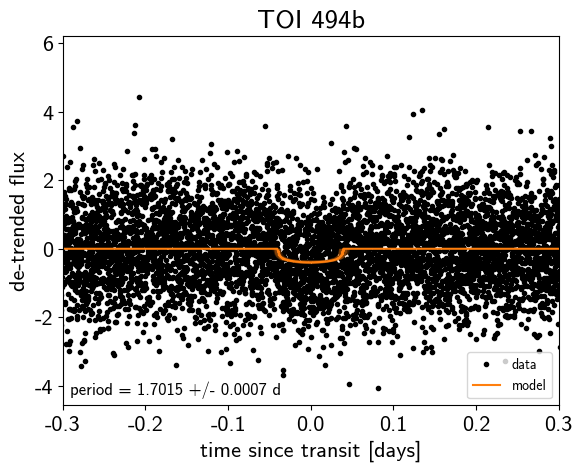

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

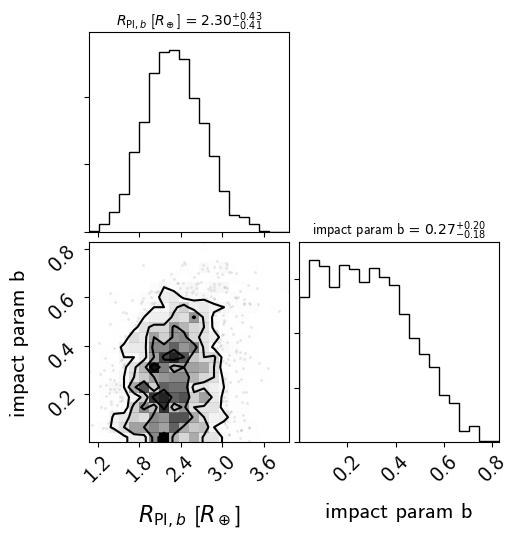

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

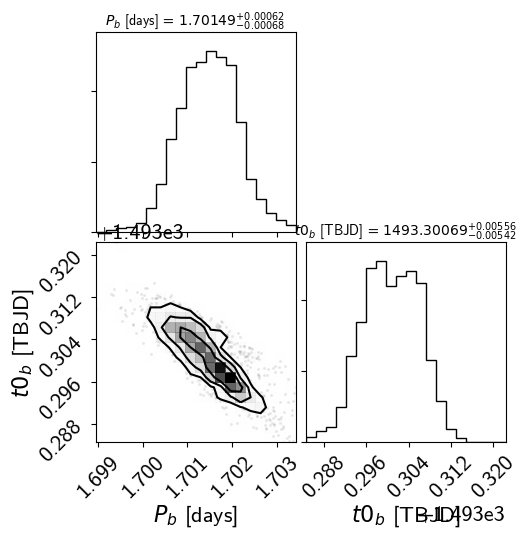

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

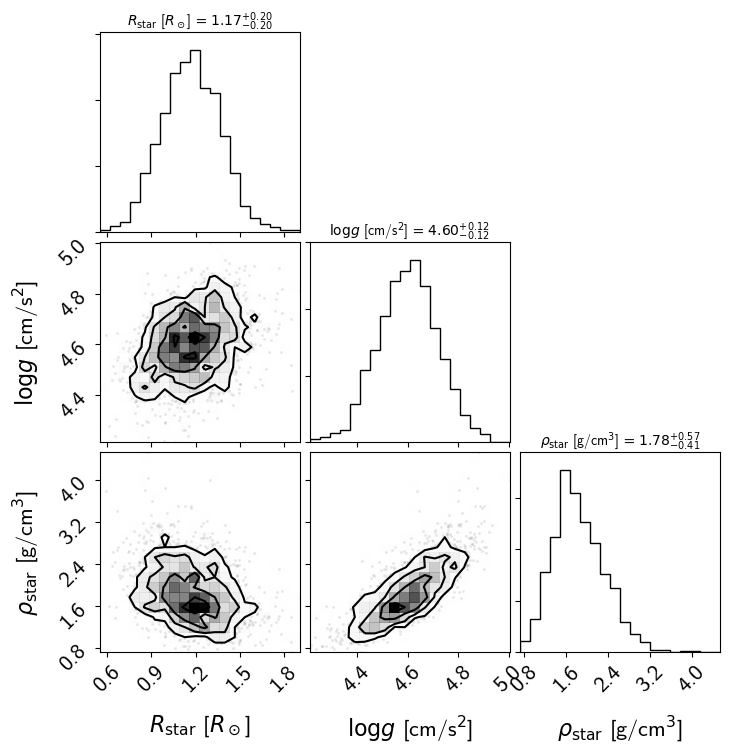

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3